# Deriving cancer gene's from expression data

See if it's possible to train a deep neural network tumor/normal binary classifier using just the Toil TCGA, TARGET and GTEX expression datasets:

https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net)

In [1]:
#get the tools
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras


/home/brad/anaconda3/envs/xenas/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/brad/anaconda3/envs/xenas/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# fix random seed for reproducibility
np.random.seed(42)

In [3]:
#Enable Tensorboard
TBoard=keras.callbacks.TensorBoard(
    log_dir='/media/brad/hd1/logs/tensorboard/', 
    histogram_freq=0, 
    batch_size=32, 
    write_graph=True, 
    write_grads=True, 
    write_images=False, 
    embeddings_freq=0, 
    embeddings_layer_names=None, 
    embeddings_metadata=None)

In [4]:
#"""
#Detect if there are GPU's on this box and if so use them politely. If not use the CPU.
#"""
#import re
#import subprocess
#import keras.backend.tensorflow_backend
#
#
#if "CUDA_HOME" in os.environ:
#    # Pick a GPU that isn't being used and then only use the memory we need (allow_growth)
#    print("Using GPU")
#    def get_session():
#        return tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True,
#                                                gpu_options=tf.GPUOptions(allow_growth=True)))
#    keras.backend.tensorflow_backend.set_session(get_session())
#
#    utilization = re.findall(r"Utilization.*?Gpu.*?(\d+).*?Memory.*?(\d+)",
#                             subprocess.check_output(["nvidia-smi", "-q"]), 
#                             flags=re.MULTILINE | re.DOTALL)
#    print("GPU Utilization", utilization)
#
#    if ('0', '0') in utilization:
#        print("Using GPU Device:", utilization.index(('0', '0')))
#        os.environ["CUDA_VISIBLE_DEVICES"] = str(utilization.index(('0', '0')))
#        os.environ["CUDA_DEVICE_ORDER"]  = "PCI_BUS_ID"  # To ensure the index matches
#    else:
#        print("All GPUs in Use")
#        exit    
#else:
#    print("Using CPU")

In [5]:
#get data

from keras.utils.io_utils import HDF5Matrix
import h5py

input_file = "data/tumor_normal.h5"

with h5py.File(input_file, "r") as f:
    print("Datasets:", list(f.keys()))
    
# Use a subset of the data if debugging
#if os.getenv("DEBUG", "True") == "True":
#    X_train = HDF5Matrix(input_file, "X_train", start=0, end=1000)
#    X_test = HDF5Matrix(input_file, "X_test", start=0, end=200)
#    y_train = HDF5Matrix(input_file, "y_train", start=0, end=1000)
#    y_test = HDF5Matrix(input_file, "y_test", start=0, end=200)
#    print("Training on partial dataset")
#    epochs=1
#    batch_size=256
#else:

#warning this conversion to np arrays takes time
X_train = np.array( HDF5Matrix(input_file, "X_train"))
X_test  = np.array( HDF5Matrix(input_file, "X_test"))
y_train = np.array( HDF5Matrix(input_file, "y_train"))
y_test  = np.array( HDF5Matrix(input_file, "y_test"))
classes_test   = np.array( HDF5Matrix(input_file, "classes_test"))
classes_train  = np.array( HDF5Matrix(input_file, "classes_train"))
features       = np.array( HDF5Matrix(input_file, "features"))
genes          = np.array( HDF5Matrix(input_file, "genes"))
labels         = np.array( HDF5Matrix(input_file, "labels"))
class_labels   = np.array( HDF5Matrix(input_file, "class_labels"))


print("Training on full dataset")
epochs=8
batch_size=128
    
print("X_train.shape:", X_train.shape, "epochs:", epochs, "batch_size:", batch_size)
print("X_test.shape:", X_test.shape)

 

Datasets: ['X_test', 'X_train', 'class_labels', 'classes_test', 'classes_train', 'features', 'genes', 'labels', 'y_test', 'y_train']
Training on full dataset
X_train.shape: (15300, 60498) epochs: 8 batch_size: 128
X_test.shape: (3826, 60498)


In [6]:
# get my printf
def printf(format, *values):
    print(format % values )

In [7]:
#list tissue types
Tclass_labels = np.concatenate((class_labels[:],class_labels[:]),axis=0)
print("classes_labels shape:", Tclass_labels.shape)
for i in range(92) :
    T= 'Normal'
    if i > 45: T='Tumor'
    printf("classes_label : %2.2d %s %s", i, T,  Tclass_labels[i])
 


classes_labels shape: (92, 1)
classes_label : 00 Normal [b'Adipose Ti']
classes_label : 01 Normal [b'Adrenal Gl']
classes_label : 02 Normal [b'Adrenal gl']
classes_label : 03 Normal [b'Bile duct']
classes_label : 04 Normal [b'Bladder']
classes_label : 05 Normal [b'Blood']
classes_label : 06 Normal [b'Blood Vess']
classes_label : 07 Normal [b'Bone Marro']
classes_label : 08 Normal [b'Brain']
classes_label : 09 Normal [b'Breast']
classes_label : 10 Normal [b'Cervix']
classes_label : 11 Normal [b'Cervix Ute']
classes_label : 12 Normal [b'Colon']
classes_label : 13 Normal [b'Endometriu']
classes_label : 14 Normal [b'Esophagus']
classes_label : 15 Normal [b'Eye']
classes_label : 16 Normal [b'Fallopian ']
classes_label : 17 Normal [b'Head and N']
classes_label : 18 Normal [b'Heart']
classes_label : 19 Normal [b'Kidney']
classes_label : 20 Normal [b'Lining of ']
classes_label : 21 Normal [b'Liver']
classes_label : 22 Normal [b'Lung']
classes_label : 23 Normal [b'Lymphatic ']
classes_label : 2

train classes


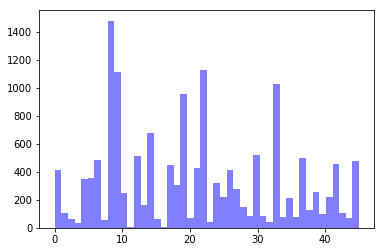

test classes


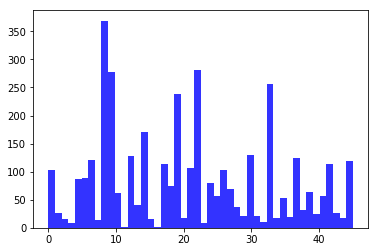

In [8]:
#Histogram
num_bins = 46
print('train classes')
n, bins, patches = plt.hist(classes_train, num_bins, facecolor='blue', alpha=0.5)
plt.show()

print('test classes')

n, bins, patches = plt.hist(classes_test, num_bins, facecolor='blue', alpha=0.8)
plt.show()

In [9]:
#expand classes to categorical
print("classes_test.shape:", classes_test.shape)
print("classes_train.shape:", classes_train.shape)
print("features.shape:", features.shape, features[0:10])
print("genes.shape:", genes.shape, genes[0:10])
print("labels.shape:", labels.shape, labels)
print("classes :", classes_train[0:100] )

Classes_train = keras.utils.to_categorical(classes_train, 46)
Classes_test  = keras.utils.to_categorical(classes_test,  46)

print("Classes :", Classes_train.shape )
class_labels.shape



classes_test.shape: (3826,)
classes_train.shape: (15300,)
features.shape: (60498,) [b'ENSG000002' b'ENSG000002' b'ENSG000002' b'ENSG000001' b'ENSG000002'
 b'ENSG000000' b'ENSG000002' b'ENSG000002' b'ENSG000001' b'ENSG000001']
genes.shape: (60498,) [b'RP11-368I2' b'RP11-167B3' b'RP11-742D1' b'RAB4B' b'AC104071.1' b'TIGAR'
 b'LINC01224' b'MIR4802' b'RNF44' b'DNAH3']
labels.shape: (2, 1) [[b'Normal']
 [b'Tumor']]
classes : [ 8  5 37 20  0 19  9 39 26  0 19 19 35  5 33  9 22  8  0 10 22  8  8  8
 26 21 12 21  0  9 35  4  9 22  9 19 22 35 24 22  6 27  5 25 30 41  9  8
  9 22  8 33  5  5 19  0  6 26  0 28 22  9  7 14 34  6 19 21  8 22 30  6
  9 21 39 21 33 23 10  9  8 37  8 33  9 33  8 14 13  6 25 33 22 19 19 10
  8 14 33 18]
Classes : (15300, 46)


(46, 1)

In [10]:
"""
Expand tissue type classes from 46 to 92 by including tumor status.
"""

print("y_test.shape:", y_test.shape, y_test[0:10], classes_test[0:10])
yt=y_test[:]
Yt=Classes_test[:]
yall0=Yt*               yt[:,np.newaxis]
yall1=Yt*np.logical_not(yt[:,np.newaxis])
Tclasses_test=np.concatenate((yall1, yall0), axis=1)
print("Tclasses_test.shape:", Tclasses_test.shape)
print("Tclasses_test:\n", Tclasses_test[7,:])

print("y_train.shape:", y_train.shape, y_train[0:10], classes_train[0:10])
yt=y_train[:]
Yt=Classes_train[:]
yall0=Yt*               yt[:,np.newaxis]
yall1=Yt*np.logical_not(yt[:,np.newaxis])
Tclasses_train=np.concatenate((yall1, yall0), axis=1)
print("Tclasses_train.shape:", Tclasses_train.shape)
print("Tclasses_train:\n", Tclasses_train[2,:])

from sklearn.utils import class_weight
sample_weights = class_weight.compute_sample_weight('balanced', classes_train[:]+46*y_train[:])

sample_weights[1:100]
#sample_weights.shape

y_test.shape: (3826,) [0 0 0 1 0 1 0 1 1 0] [33 41 24 33 22 19 14 30  4 31]
Tclasses_test.shape: (3826, 92)
Tclasses_test:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
y_train.shape: (15300,) [0 0 1 1 0 1 1 0 1 0] [ 8  5 37 20  0 19  9 39 26  0]
Tclasses_train.shape: (15300, 92)
Tclasses_train:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0.61569416, 0.66033664, 3.12244898, 0.53051318, 0.26785714,
       0.24697337, 1.72103487, 0.63909774, 0.53051318, 0.26785714,
       0.26785714, 1.04579631, 0.61569416, 0.58914132, 0.24697337,
       0.26950854, 0.23757764, 0.53051318, 0.89578454, 0.26950854,
       0.39240831, 0.23757764, 0.23757764, 0.63909774, 1.72103487,
       0.76961771, 0.73346117, 0.53051318, 0.24697337, 1.04579631,
       0.67460317, 0.24697337, 0.26950854, 0.24697337, 0.26785714,
       0.26950854, 1.04579631, 0.68949977, 0.26950854, 0.45066274,
       1.59541189, 0.61569416, 0.98455598, 0.56043956, 0.98014094,
       0.24697337, 0.23757764, 0.24697337, 0.26950854, 0.23757764,
       0.33420708, 0.61569416, 0.61569416, 0.26785714, 0.53051318,
       0.45066274, 0.63909774, 0.53051318, 1.50738916, 0.68949977,
       0.24697337, 3.90306122, 0.40854473, 2.95366795, 0.45066274,
       0.26785714, 0.73346117, 0.23757764, 0.26950854, 0.56043956,
       0.45066274, 0.24697337, 1.72103487, 1.72103487, 0.73346

In [ ]:
#select one class to predict

In [11]:
"""
Apply e^x to remove log 
"""
#eX_train=np.exp(X_train)
#eX_test =np.exp(X_test)



'\nApply e^x to remove log \n'

In [12]:

if(0):
    hist=np.zeros(92)
    class_weight=np.zeros(92)
    
    for i in range(92) :
        nc    = np.sum(Tclasses_test[ :,i] )  
        if(nc==0): class_weight[i]=0
        if(nc> 0): class_weight[i]=1000/nc
        hist[i]  = nc;  
    plt.bar( range(92),  class_weight)


#model.fit(X_train, Tclasses_train, epochs=20, batch_size=256, shuffle="true",class_weight = class_weight, validation_data=(X_test, Tclasses_test))


In [ ]:
#class_weight=np.zeros(92)
#class_weight[0:46]=1
#from sklearn.utils import class_weight
#sample_weights = class_weight.compute_sample_weight('balanced', classes_train[:]+46*y_train[:])


In [13]:
#initial sparse array of weights 
if(0):
    npaths=100
    #reg_path = np.random.random((X_train.shape[1],npaths))
    reg_path = np.zeros((X_train.shape[1],npaths))
    
    for i in range(100) :
        reg_path[i::100,i::100]=1
    #reg_path[:,0::2]=1
    
    reg_path1=np.logical_not(reg_path)+0
    print( reg_path.shape, reg_path)

In [18]:
#read genes pathways in array
# use to create regulation pattern, penalizing weights not in pathway
print("genes:", genes.shape, genes[1:10])

#Assign pathways to weights array
paths= pd.read_table("/home/brad/Downloads/c6.all.v6.1.symbols.gmt"
                     , sep='\t'
                     , header=None
                     , names=range(1000)
                      )
#for each path, mark each weight in neuron with a one if included in pathway
npaths=188 
nsamps = X_train.shape[1]
#nsamps = 4 
reg_path = np.zeros((nsamps,npaths))
for path in range(npaths) :
    pcol=paths[0]
    pname=pcol[path]
    printf("\npath%s name=%s: ", path,pname)
     
    for w in range (nsamps) :
        gene=genes[w]
        gene=gene.decode('UTF-8')
        #print(" gene, loc : ", gene, w)
        
        for i in range (500) :
            pcol=paths[i+2]
            gtest=pcol[path]

            #print("gtest=", gtest)
            if gtest != gtest : break
            if gtest == gene : 
                printf( 'found gene=%12s, path=%4d w=%5d', gtest,path, w )
                reg_path[w,path]=1

reg_path1=np.logical_not(reg_path)+0
print( reg_path.shape, reg_path)               

#pathcol=paths[0]
#print("paths:",patha.shape,pathcol[1])
#paths.info()

                     

genes: (60498,) [b'RP11-167B3' b'RP11-742D1' b'RAB4B' b'AC104071.1' b'TIGAR' b'LINC01224'
 b'MIR4802' b'RNF44' b'DNAH3']

path0 name=GLI1_UP.V1_DN: 
found gene=      BTBD16, path=   0 w=  990
found gene=       ESYT1, path=   0 w= 3285
found gene=     TMEM181, path=   0 w= 5354
found gene=         BBX, path=   0 w= 7269
found gene=       ACSL6, path=   0 w= 9495
found gene=      QRICH2, path=   0 w=10562
found gene=       PPIL1, path=   0 w=13931
found gene=       ACSL6, path=   0 w=14176
found gene=       RNF10, path=   0 w=17537
found gene=       SEPT9, path=   0 w=20099
found gene=       COPZ1, path=   0 w=23600
found gene=       ARPC2, path=   0 w=29950
found gene=       RSAD2, path=   0 w=32034
found gene=     ZMYND11, path=   0 w=34584
found gene=        OPN3, path=   0 w=34963
found gene=        SELM, path=   0 w=35010
found gene=       YIPF1, path=   0 w=35334
found gene=       FOLR1, path=   0 w=37311
found gene=       GTDC1, path=   0 w=37427
found gene=       RUNX1, path=   0

found gene=       RAP2B, path=   2 w=45317
found gene=        RGS2, path=   2 w=45377
found gene=     ZC3H12A, path=   2 w=45447
found gene=     TRAPPC4, path=   2 w=45731
found gene=        PKD1, path=   2 w=45982
found gene=        BCL6, path=   2 w=46038
found gene=     C18orf8, path=   2 w=46166
found gene=      A4GALT, path=   2 w=46566
found gene=    PDZK1IP1, path=   2 w=46792
found gene=       TGFB3, path=   2 w=46944
found gene=     UNC93B1, path=   2 w=47385
found gene=       EVI2A, path=   2 w=47846
found gene=      LCLAT1, path=   2 w=48744
found gene=        IDH1, path=   2 w=49282
found gene=     APBB1IP, path=   2 w=49508
found gene=       DCAF8, path=   2 w=50879
found gene=       PSEN2, path=   2 w=51387
found gene=       PLIN2, path=   2 w=51414
found gene=      POU5F1, path=   2 w=51575
found gene=        TGM2, path=   2 w=52372
found gene=     B4GALT3, path=   2 w=52405
found gene=        SGK1, path=   2 w=52686
found gene=       IL6ST, path=   2 w=53560
found gene=

found gene=        PIM1, path=   3 w=47941
found gene=       EFNB2, path=   3 w=48245
found gene=       DMBT1, path=   3 w=48281
found gene=       SPEF1, path=   3 w=48619
found gene=       MED20, path=   3 w=48768
found gene=      KLHL21, path=   3 w=48863
found gene=       ACTN3, path=   3 w=48986
found gene=       SMAD1, path=   3 w=49391
found gene=       SOCS2, path=   3 w=49407
found gene=       HMGB3, path=   3 w=49841
found gene=      VPS37B, path=   3 w=49996
found gene=      FAM60A, path=   3 w=50192
found gene=        CLN6, path=   3 w=50341
found gene=       CNOT7, path=   3 w=51628
found gene=       FRAT2, path=   3 w=51725
found gene=        MCM4, path=   3 w=51945
found gene=       PRIM2, path=   3 w=51949
found gene=     MAP3K11, path=   3 w=52102
found gene=        PRC1, path=   3 w=52460
found gene=       SGOL1, path=   3 w=53033
found gene=       TRAF3, path=   3 w=53336
found gene=       TYRO3, path=   3 w=53541
found gene=        DLX1, path=   3 w=54717
found gene=

found gene=        MICB, path=   4 w=45969
found gene=     C18orf8, path=   4 w=46166
found gene=     GOLGA8A, path=   4 w=46786
found gene=       PTBP2, path=   4 w=47063
found gene=       HERC6, path=   4 w=47134
found gene=     SLC6A14, path=   4 w=47161
found gene=       ASCL1, path=   4 w=47681
found gene=      HSPA4L, path=   4 w=47847
found gene=       EFNB2, path=   4 w=48245
found gene=    HIST1H1C, path=   4 w=48479
found gene=     TMEM187, path=   4 w=49581
found gene=       FANCL, path=   4 w=50262
found gene=    KIAA0430, path=   4 w=50889
found gene=        RCN1, path=   4 w=51016
found gene=         ID1, path=   4 w=51293
found gene=        CBR4, path=   4 w=51368
found gene=      ELOVL2, path=   4 w=51673
found gene=       NPY1R, path=   4 w=51891
found gene=     TBL1XR1, path=   4 w=51963
found gene=        PRR7, path=   4 w=52532
found gene=        MPDZ, path=   4 w=52942
found gene=   HIST1H2AG, path=   4 w=53652
found gene=   HIST1H2BG, path=   4 w=54184
found gene=

found gene=         FGG, path=   5 w=50211
found gene=        VAV3, path=   5 w=50739
found gene=      FERMT2, path=   5 w=50763
found gene=       EPAS1, path=   5 w=50932
found gene=        IQCG, path=   5 w=51377
found gene=         FGB, path=   5 w=51576
found gene=        CTGF, path=   5 w=51695
found gene=    APOBEC3B, path=   5 w=51849
found gene=        TAP1, path=   5 w=52108
found gene=  CSGALNACT1, path=   5 w=52529
found gene=       CMAHP, path=   5 w=52611
found gene=     SLC12A2, path=   5 w=52620
found gene=       ALAS1, path=   5 w=52717
found gene=      SEL1L3, path=   5 w=52952
found gene=         LPP, path=   5 w=53029
found gene=         GAL, path=   5 w=53141
found gene=       ETHE1, path=   5 w=53814
found gene=      RAB27A, path=   5 w=54170
found gene=        TFPI, path=   5 w=54263
found gene=        TNS3, path=   5 w=54512
found gene=      PDLIM7, path=   5 w=54524
found gene=       SPAG1, path=   5 w=54580
found gene=      PHLDA1, path=   5 w=54652
found gene=

found gene=     C18orf8, path=   6 w=46166
found gene=       RRP15, path=   6 w=46234
found gene=        MSH2, path=   6 w=46421
found gene=     GOLGA8A, path=   6 w=46786
found gene=     SLC26A2, path=   6 w=46843
found gene=       USP16, path=   6 w=46945
found gene=       PTBP2, path=   6 w=47063
found gene=       PRMT3, path=   6 w=47081
found gene=       HERC6, path=   6 w=47134
found gene=     SLC6A14, path=   6 w=47161
found gene=       ASCL1, path=   6 w=47681
found gene=       NRCAM, path=   6 w=47817
found gene=      HSPA4L, path=   6 w=47847
found gene=      LPGAT1, path=   6 w=48749
found gene=       RAB31, path=   6 w=51273
found gene=       FBXO5, path=   6 w=51359
found gene=        CBR4, path=   6 w=51368
found gene=        KRR1, path=   6 w=51562
found gene=      TM4SF1, path=   6 w=51675
found gene=       NPY1R, path=   6 w=51891
found gene=      ARMCX5, path=   6 w=52118
found gene=     FASTKD1, path=   6 w=52482
found gene=       RPAP3, path=   6 w=52925
found gene=

found gene=        KRT7, path=   7 w=48755
found gene=       CRLF1, path=   7 w=49117
found gene=     CEACAM5, path=   7 w=49502
found gene=       FADS2, path=   7 w=50769
found gene=       EPAS1, path=   7 w=50932
found gene=  ST6GALNAC2, path=   7 w=51059
found gene=       ALDOC, path=   7 w=51806
found gene=    APOBEC3B, path=   7 w=51849
found gene=        CAST, path=   7 w=52330
found gene=  CSGALNACT1, path=   7 w=52529
found gene=     SLC12A2, path=   7 w=52620
found gene=        PTMS, path=   7 w=52976
found gene=    HSD17B11, path=   7 w=54092
found gene=      MAPRE3, path=   7 w=54901
found gene=    TNFRSF21, path=   7 w=54904
found gene=       APH1B, path=   7 w=55261
found gene=      CHST11, path=   7 w=55445
found gene=       PRPS1, path=   7 w=55655
found gene=       DRAM1, path=   7 w=55702
found gene=       CXCR4, path=   7 w=55838
found gene=      BMPR1B, path=   7 w=56025
found gene=        ST13, path=   7 w=56067
found gene=        MIA3, path=   7 w=56272
found gene=

found gene=        LYST, path=   8 w=58237
found gene=         ID2, path=   8 w=58519
found gene=       RAMP1, path=   8 w=58746
found gene=       NR4A2, path=   8 w=58800
found gene=      CITED2, path=   8 w=59394
found gene=       ADCY9, path=   8 w=59405
found gene=      LRRC23, path=   8 w=59623

path9 name=GCNP_SHH_UP_EARLY.V1_UP: 
found gene=      FBXO45, path=   9 w=  250
found gene=     CXorf38, path=   9 w= 1335
found gene=       FCGRT, path=   9 w= 1513
found gene=       KIF1B, path=   9 w= 1914
found gene=       FNBP4, path=   9 w= 2302
found gene=    EPB41L4B, path=   9 w= 2609
found gene=        GNL3, path=   9 w= 2655
found gene=    KRTAP6-3, path=   9 w= 3855
found gene=       TNPO1, path=   9 w= 4037
found gene=        ZZZ3, path=   9 w= 4101
found gene=     SLC35E1, path=   9 w= 5135
found gene=       TOP2A, path=   9 w= 5351
found gene=        SDC3, path=   9 w= 5522
found gene=         SHE, path=   9 w= 5767
found gene=       MATR3, path=   9 w= 6236
found gene=     

found gene=        ART5, path=  10 w= 6119
found gene=    C19orf60, path=  10 w= 6120
found gene=   EIF4ENIF1, path=  10 w= 6135
found gene=        PAK4, path=  10 w= 6380
found gene=        EBI3, path=  10 w= 6439
found gene=       ADH1A, path=  10 w= 6706
found gene=        DDA1, path=  10 w= 6926
found gene=       NUDT1, path=  10 w= 6997
found gene=       ACTN4, path=  10 w= 7761
found gene=      ARID3A, path=  10 w= 7940
found gene=       LAMC2, path=  10 w= 8260
found gene=    SERPINF1, path=  10 w= 8402
found gene=       WIPI2, path=  10 w= 9872
found gene=       DPPA5, path=  10 w=10082
found gene=      NECAP2, path=  10 w=10091
found gene=        EIF6, path=  10 w=10422
found gene=        OGG1, path=  10 w=12325
found gene=      ZNHIT2, path=  10 w=12384
found gene=       UBE3C, path=  10 w=12454
found gene=     S100A13, path=  10 w=12632
found gene=      TUBA4B, path=  10 w=12915
found gene=        DLX5, path=  10 w=12994
found gene=       S1PR1, path=  10 w=12999
found gene=

found gene=       POLA2, path=  11 w= 7521
found gene=       VPRBP, path=  11 w= 7614
found gene=      INCENP, path=  11 w= 7653
found gene=         ZFX, path=  11 w= 7737
found gene=       MAGOH, path=  11 w= 7779
found gene=       CLIP4, path=  11 w= 8599
found gene=         UNG, path=  11 w= 8795
found gene=      PIK3CA, path=  11 w= 9115
found gene=        LIG1, path=  11 w= 9393
found gene=      TIMM8A, path=  11 w=10239
found gene=       CLCN5, path=  11 w=10566
found gene=       USP39, path=  11 w=10895
found gene=       NOP56, path=  11 w=11699
found gene=    C1orf174, path=  11 w=12379
found gene=     TNFSF10, path=  11 w=12451
found gene=       PSME4, path=  11 w=12869
found gene=       CFDP1, path=  11 w=13329
found gene=      YTHDF3, path=  11 w=13482
found gene=      SACM1L, path=  11 w=13681
found gene=      ZNF281, path=  11 w=13877
found gene=         DES, path=  11 w=14011
found gene=        SDC2, path=  11 w=14294
found gene=       CLIC4, path=  11 w=14819
found gene=

found gene=       GRIN1, path=  12 w=15452
found gene=       GFRA2, path=  12 w=15824
found gene=      IGFBP3, path=  12 w=16072
found gene=      PPAP2B, path=  12 w=16265
found gene=      INPP5J, path=  12 w=16591
found gene=        MID1, path=  12 w=17795
found gene=        CAV3, path=  12 w=17940
found gene=       GALNS, path=  12 w=18078
found gene=    SLC9A3R1, path=  12 w=18224
found gene=        BBC3, path=  12 w=18321
found gene=      HSPA1A, path=  12 w=18393
found gene=       NAGPA, path=  12 w=18471
found gene=       SNTA1, path=  12 w=19294
found gene=        WNK1, path=  12 w=20422
found gene=        MYCN, path=  12 w=21272
found gene=       BRMS1, path=  12 w=21412
found gene=       FOXI1, path=  12 w=22011
found gene=      PSMD13, path=  12 w=22156
found gene=      TSPAN4, path=  12 w=22588
found gene=      TFAP2A, path=  12 w=22791
found gene=       CRIP2, path=  12 w=23085
found gene=       FXYD1, path=  12 w=23511
found gene=      FAM49A, path=  12 w=23944
found gene=

found gene=         NRL, path=  13 w=15865
found gene=      TRIM38, path=  13 w=16344
found gene=        CLK1, path=  13 w=16425
found gene=       ITPKA, path=  13 w=16504
found gene=      NKX2-8, path=  13 w=17035
found gene=      FAM50A, path=  13 w=17122
found gene=       P2RX7, path=  13 w=17231
found gene=        CASK, path=  13 w=17427
found gene=       PAQR4, path=  13 w=17569
found gene=      ALOX15, path=  13 w=17973
found gene=         GML, path=  13 w=18025
found gene=     C1orf95, path=  13 w=18104
found gene=        CHD5, path=  13 w=18147
found gene=       CCDC9, path=  13 w=18311
found gene=         SST, path=  13 w=18909
found gene=     CCDC88C, path=  13 w=19046
found gene=       ESRRB, path=  13 w=19243
found gene=      ATP2C2, path=  13 w=19299
found gene=       GNG12, path=  13 w=19514
found gene=        DRD3, path=  13 w=19610
found gene=       CEBPA, path=  13 w=19897
found gene=       TCP10, path=  13 w=19899
found gene=       FSCN1, path=  13 w=19996
found gene=

found gene=       KRT13, path=  16 w= 9180
found gene=        PEPD, path=  16 w= 9277
found gene=        PPIG, path=  16 w= 9377
found gene=       SALL2, path=  16 w= 9397
found gene=       CAMK4, path=  16 w=10254
found gene=        MYH2, path=  16 w=11335
found gene=        COG2, path=  16 w=11640
found gene=        PENK, path=  16 w=11772
found gene=      ADARB1, path=  16 w=12073
found gene=       PRKCQ, path=  16 w=12102
found gene=       PDCD2, path=  16 w=12343
found gene=       PDE6H, path=  16 w=12692
found gene=        ATF2, path=  16 w=12694
found gene=       ACTC1, path=  16 w=12715
found gene=       PSME4, path=  16 w=12869
found gene=       KCNJ8, path=  16 w=13494
found gene=       TXLNA, path=  16 w=13700
found gene=      ANGPT1, path=  16 w=14105
found gene=       ADH1B, path=  16 w=14108
found gene=        PCP4, path=  16 w=14489
found gene=       ACTN2, path=  16 w=14957
found gene=       NEDD4, path=  16 w=15246
found gene=      CHRNB2, path=  16 w=15357
found gene=

found gene=        NEK3, path=  17 w=10033
found gene=      ZNF787, path=  17 w=10204
found gene=       TNNT2, path=  17 w=10264
found gene=         SLN, path=  17 w=10410
found gene=       PLCB2, path=  17 w=10454
found gene=       TCF12, path=  17 w=10548
found gene=     SKIV2L2, path=  17 w=11260
found gene=       PHKG2, path=  17 w=11396
found gene=        CDS1, path=  17 w=11577
found gene=        ARL3, path=  17 w=11861
found gene=       APOC1, path=  17 w=12076
found gene=       CASP3, path=  17 w=12499
found gene=        EGR3, path=  17 w=12688
found gene=        NPR2, path=  17 w=12931
found gene=     COL18A1, path=  17 w=13086
found gene=      KCNAB2, path=  17 w=13092
found gene=       MGAT5, path=  17 w=13162
found gene=       KDM5C, path=  17 w=14457
found gene=      SLC6A3, path=  17 w=14624
found gene=      ABLIM1, path=  17 w=15091
found gene=        FZD5, path=  17 w=15620
found gene=        HSF4, path=  17 w=15891
found gene=      S100A2, path=  17 w=16335
found gene=

found gene=        HPCA, path=  18 w=11240
found gene=        MYH2, path=  18 w=11335
found gene=        MYL9, path=  18 w=11467
found gene=        COG2, path=  18 w=11640
found gene=        IGF1, path=  18 w=11762
found gene=       PRKCQ, path=  18 w=12102
found gene=       SART3, path=  18 w=12167
found gene=       PDCD2, path=  18 w=12343
found gene=       GALK1, path=  18 w=12482
found gene=        ATF2, path=  18 w=12694
found gene=      S100A4, path=  18 w=12809
found gene=        CUL7, path=  18 w=13002
found gene=        HPS1, path=  18 w=13279
found gene=       TXLNA, path=  18 w=13700
found gene=      MRE11A, path=  18 w=14639
found gene=       NEDD4, path=  18 w=15246
found gene=     KIR2DL4, path=  18 w=15511
found gene=       ITGA3, path=  18 w=16300
found gene=       CASP9, path=  18 w=16519
found gene=      SPTLC2, path=  18 w=17213
found gene=        AMBP, path=  18 w=17258
found gene=       HERC1, path=  18 w=17759
found gene=        ROS1, path=  18 w=17988
found gene=

found gene=        MSLN, path=  19 w=14352
found gene=       KDM5C, path=  19 w=14457
found gene=        RXRA, path=  19 w=14619
found gene=      SLC6A3, path=  19 w=14624
found gene=      ABLIM1, path=  19 w=15091
found gene=        FZD5, path=  19 w=15620
found gene=       ANPEP, path=  19 w=15698
found gene=      MUC5AC, path=  19 w=16518
found gene=   HNRNPA3P1, path=  19 w=17360
found gene=        HAGH, path=  19 w=17899
found gene=        DVL1, path=  19 w=18060
found gene=       GALNS, path=  19 w=18078
found gene=       REEP5, path=  19 w=18650
found gene=        NFE2, path=  19 w=18864
found gene=     SLC18A3, path=  19 w=18881
found gene=        BATF, path=  19 w=19091
found gene=       AXIN1, path=  19 w=19461
found gene=       APOC4, path=  19 w=19924
found gene=         GP2, path=  19 w=19951
found gene=       MKI67, path=  19 w=20197
found gene=        NKG7, path=  19 w=20227
found gene=        DMWD, path=  19 w=20346
found gene=      CACNG1, path=  19 w=20891
found gene=

found gene=        UBN2, path=  20 w=19809
found gene=      TRIM69, path=  20 w=20257
found gene=     RABGAP1, path=  20 w=20744
found gene=     MAB21L1, path=  20 w=21482
found gene=     ZNF37BP, path=  20 w=22149
found gene=       LRIG3, path=  20 w=22301
found gene=       DCP1B, path=  20 w=22403
found gene=      TFAP2A, path=  20 w=22791
found gene=        NMT2, path=  20 w=23102
found gene=        SDPR, path=  20 w=23205
found gene=     ALDH3B2, path=  20 w=23209
found gene=      ANKZF1, path=  20 w=23317
found gene=       APBB3, path=  20 w=23735
found gene=        POLL, path=  20 w=24655
found gene=       CDRT4, path=  20 w=26451
found gene=      ZNF226, path=  20 w=27326
found gene=     SLC7A14, path=  20 w=27531
found gene=        SNPH, path=  20 w=27607
found gene=         ADM, path=  20 w=28006
found gene=     SLC16A7, path=  20 w=28113
found gene=         AMT, path=  20 w=28662
found gene=       AP4S1, path=  20 w=30315
found gene=       STX16, path=  20 w=30543
found gene=

found gene=       PLCH1, path=  21 w=40846
found gene=      SEC24A, path=  21 w=40954
found gene=      ZNF697, path=  21 w=41353
found gene=       INHBA, path=  21 w=41510
found gene=        NIP7, path=  21 w=42798
found gene=    KIAA0020, path=  21 w=42959
found gene=        FJX1, path=  21 w=43173
found gene=        GNL2, path=  21 w=43312
found gene=     D4S234E, path=  21 w=43496
found gene=     SLC28A1, path=  21 w=43855
found gene=         HLX, path=  21 w=44016
found gene=        NT5E, path=  21 w=44243
found gene=       BRPF1, path=  21 w=44773
found gene=        NET1, path=  21 w=44814
found gene=       SPRY4, path=  21 w=44823
found gene=      ZNF800, path=  21 w=44831
found gene=         NCL, path=  21 w=45081
found gene=       YWHAG, path=  21 w=45491
found gene=        ETS1, path=  21 w=45511
found gene=       DOT1L, path=  21 w=45901
found gene=     SMARCA4, path=  21 w=46658
found gene=      DNAJA1, path=  21 w=47633
found gene=     TXNDC12, path=  21 w=47755
found gene=

found gene=      EPSTI1, path=  22 w=49875
found gene=       FADS2, path=  22 w=50769
found gene=     ANKRD29, path=  22 w=51058
found gene=         TOX, path=  22 w=51272
found gene=    DYNC2LI1, path=  22 w=51282
found gene=      TRERF1, path=  22 w=51840
found gene=       APOL3, path=  22 w=52558
found gene=         OAF, path=  22 w=52805
found gene=       BACH1, path=  22 w=52912
found gene=       FADS1, path=  22 w=54259
found gene=        TNXB, path=  22 w=54527
found gene=         LSS, path=  22 w=54833
found gene=     C14orf1, path=  22 w=55370
found gene=       PAMR1, path=  22 w=55529
found gene=        IL1B, path=  22 w=55606
found gene=       DRAM1, path=  22 w=55702
found gene=          F8, path=  22 w=57081
found gene=     FAM131C, path=  22 w=57310
found gene=        BTG2, path=  22 w=57520
found gene=        SOD2, path=  22 w=57712
found gene=      ADAM17, path=  22 w=57841
found gene=         EBP, path=  22 w=58185
found gene=     TBC1D2B, path=  22 w=58604
found gene=

found gene=     ARHGEF1, path=  23 w=59512
found gene=       POLE3, path=  23 w=59964
found gene=       TIMP1, path=  23 w=60452

path24 name=AKT_UP_MTOR_DN.V1_DN: 
found gene=      PHLDA2, path=  24 w=  479
found gene=         OGN, path=  24 w=  988
found gene=      SH3BGR, path=  24 w= 1186
found gene=       GNAT2, path=  24 w= 1637
found gene=       TIPIN, path=  24 w= 1654
found gene=        BDH1, path=  24 w= 1661
found gene=        BMP7, path=  24 w= 2539
found gene=       BCS1L, path=  24 w= 2652
found gene=       MOCOS, path=  24 w= 2867
found gene=      FKBP10, path=  24 w= 2970
found gene=      CAMKK2, path=  24 w= 3031
found gene=      LANCL2, path=  24 w= 3248
found gene=      IL17RC, path=  24 w= 3266
found gene=       KRBA1, path=  24 w= 3364
found gene=       CD200, path=  24 w= 3614
found gene=        MEPE, path=  24 w= 3699
found gene=      ZC3HC1, path=  24 w= 3841
found gene=        TYMP, path=  24 w= 3946
found gene=       ASF1A, path=  24 w= 3996
found gene=       

found gene=      CAMKK1, path=  25 w= 2981
found gene=     TMPRSS4, path=  25 w= 3095
found gene=        BSND, path=  25 w= 3118
found gene=       PFDN2, path=  25 w= 3573
found gene=       PARM1, path=  25 w= 4508
found gene=        PLK2, path=  25 w= 4567
found gene=  ST6GALNAC6, path=  25 w= 4966
found gene=       FKBP8, path=  25 w= 5115
found gene=       FXYD4, path=  25 w= 5568
found gene=       SOCS6, path=  25 w= 5849
found gene=       DHCR7, path=  25 w= 6622
found gene=       MPZL2, path=  25 w= 7021
found gene=       SFTPD, path=  25 w= 7076
found gene=        FXR2, path=  25 w= 7488
found gene=        VAT1, path=  25 w= 7949
found gene=      WFDC12, path=  25 w= 7957
found gene=       LAMC2, path=  25 w= 8260
found gene=         AK4, path=  25 w= 8591
found gene=       LYPD1, path=  25 w= 8786
found gene=        ATF3, path=  25 w= 8907
found gene=        SAA2, path=  25 w= 9185
found gene=       BMP8B, path=  25 w= 9199
found gene=        GDE1, path=  25 w= 9248
found gene=

found gene=     PLA2G4A, path=  26 w= 5799
found gene=        POLI, path=  26 w= 5818
found gene=       MSRB2, path=  26 w= 6044
found gene=     SLC37A4, path=  26 w= 6275
found gene=    SLC39A13, path=  26 w= 6999
found gene=     ANGPTL4, path=  26 w= 7646
found gene=       PDE4B, path=  26 w= 8848
found gene=        RXRB, path=  26 w= 9272
found gene=      FBXO32, path=  26 w= 9289
found gene=      SCCPDH, path=  26 w= 9565
found gene=       ITPKB, path=  26 w= 9595
found gene=       SFRP2, path=  26 w=10496
found gene=        FMO3, path=  26 w=10900
found gene=     C7orf73, path=  26 w=10978
found gene=       TCF21, path=  26 w=11559
found gene=       TULP3, path=  26 w=11795
found gene=      EXOSC1, path=  26 w=12247
found gene=       SYPL2, path=  26 w=12659
found gene=      KCTD12, path=  26 w=12686
found gene=       MATN2, path=  26 w=12992
found gene=        PUS7, path=  26 w=13144
found gene=        HPS1, path=  26 w=13279
found gene=      PM20D1, path=  26 w=13535
found gene=

found gene=       TMCC3, path=  27 w=10294
found gene=        GPX2, path=  27 w=11011
found gene=        TESC, path=  27 w=12708
found gene=        PLAT, path=  27 w=12729
found gene=     PPP1R3F, path=  27 w=12889
found gene=     TPD52L3, path=  27 w=12958
found gene=      METRNL, path=  27 w=13305
found gene=       KCNQ1, path=  27 w=13384
found gene=        CIR1, path=  27 w=13636
found gene=     PACSIN3, path=  27 w=13947
found gene=       PRKCH, path=  27 w=13958
found gene=        BPGM, path=  27 w=14555
found gene=     CYP51A1, path=  27 w=15051
found gene=     DNAJB13, path=  27 w=15202
found gene=       SYT17, path=  27 w=15685
found gene=      DHCR24, path=  27 w=15719
found gene=       GDPD2, path=  27 w=16228
found gene=      TOM1L1, path=  27 w=16526
found gene=     FAM129A, path=  27 w=17638
found gene=        PSCA, path=  27 w=17998
found gene=       CTRB1, path=  27 w=18007
found gene=       KRT23, path=  27 w=18506
found gene=       ASB11, path=  27 w=18541
found gene=

found gene=        ISL1, path=  28 w=18588
found gene=     SLC44A1, path=  28 w=18596
found gene=        NCF4, path=  28 w=18967
found gene=        UPB1, path=  28 w=20175
found gene=     PPP1R3C, path=  28 w=20464
found gene=      OSGIN1, path=  28 w=20857
found gene=     TMEM186, path=  28 w=21073
found gene=        MYCN, path=  28 w=21272
found gene=      CHST12, path=  28 w=21376
found gene=       FANK1, path=  28 w=22289
found gene=        ARTN, path=  28 w=22538
found gene=      TSPAN4, path=  28 w=22588
found gene=      SNHG11, path=  28 w=22803
found gene=       HTRA1, path=  28 w=22866
found gene=       FXYD1, path=  28 w=23511
found gene=        KLF2, path=  28 w=23707
found gene=      MED12L, path=  28 w=23742
found gene=       PRDM4, path=  28 w=24000
found gene=      ZNF746, path=  28 w=24061
found gene=      SH2D1B, path=  28 w=24161
found gene=       BACE1, path=  28 w=24347
found gene=        PI16, path=  28 w=24473
found gene=        OSMR, path=  28 w=24622
found gene=

found gene=        LDHC, path=  29 w=19798
found gene=          TG, path=  29 w=19865
found gene=        CMBL, path=  29 w=19886
found gene=       SEPT9, path=  29 w=20099
found gene=       STMN1, path=  29 w=20210
found gene=         GSS, path=  29 w=20477
found gene=       HELLS, path=  29 w=20842
found gene=        ERN1, path=  29 w=20928
found gene=       FOXI1, path=  29 w=22011
found gene=      ADRA1B, path=  29 w=22119
found gene=     IL18RAP, path=  29 w=22254
found gene=       HSPE1, path=  29 w=22287
found gene=        NQO2, path=  29 w=23699
found gene=        PCNA, path=  29 w=23741
found gene=       UHRF1, path=  29 w=23759
found gene=    TMEM106A, path=  29 w=23787
found gene=       AP2B1, path=  29 w=24170
found gene=      CCDC86, path=  29 w=24698
found gene=       IDH3A, path=  29 w=25161
found gene=         BLK, path=  29 w=25441
found gene=      SPRR1A, path=  29 w=26115
found gene=     S100A14, path=  29 w=26347
found gene=      NKAIN1, path=  29 w=26388
found gene=

found gene=     IRF2BP1, path=  30 w=26327
found gene=      ZNF185, path=  30 w=26367
found gene=       MAST1, path=  30 w=26381
found gene=       GRIA1, path=  30 w=26493
found gene=         CRX, path=  30 w=27089
found gene=      CLPTM1, path=  30 w=27201
found gene=       NPAS3, path=  30 w=27480
found gene=      CLASRP, path=  30 w=27872
found gene=       RIMS3, path=  30 w=28108
found gene=       OBSCN, path=  30 w=29106
found gene=        GNB3, path=  30 w=29393
found gene=        KRT9, path=  30 w=29606
found gene=        PAX2, path=  30 w=29768
found gene=       PDE1B, path=  30 w=29829
found gene=       MYO1F, path=  30 w=30180
found gene=       AMELX, path=  30 w=30248
found gene=       TROAP, path=  30 w=30266
found gene=        NCR3, path=  30 w=30440
found gene=         ERF, path=  30 w=31764
found gene=      DLGAP1, path=  30 w=32017
found gene=      ENTPD2, path=  30 w=32090
found gene=        GNAL, path=  30 w=32157
found gene=    SERPINA3, path=  30 w=32266
found gene=

found gene=      NUP155, path=  31 w=30868
found gene=       ABCA8, path=  31 w=31049
found gene=        UGP2, path=  31 w=32103
found gene=       DHX29, path=  31 w=32477
found gene=      TGFBR3, path=  31 w=32745
found gene=     ANAPC13, path=  31 w=32866
found gene=       STAU2, path=  31 w=33410
found gene=        RPGR, path=  31 w=33579
found gene=      CEP350, path=  31 w=33612
found gene=      CRYBG3, path=  31 w=33618
found gene=     RASGRP3, path=  31 w=34200
found gene=        AMPH, path=  31 w=34263
found gene=       GRB14, path=  31 w=34655
found gene=    KIAA1033, path=  31 w=34660
found gene=      RCBTB2, path=  31 w=34673
found gene=        UFL1, path=  31 w=35099
found gene=        PISD, path=  31 w=35285
found gene=     RUNX1T1, path=  31 w=35493
found gene=     SLC38A6, path=  31 w=35620
found gene=      SLC4A7, path=  31 w=35678
found gene=      ZNF117, path=  31 w=35898
found gene=      CLEC2B, path=  31 w=36328
found gene=     HSD17B4, path=  31 w=36442
found gene=

found gene=      MRPL19, path=  32 w=27698
found gene=        YES1, path=  32 w=28758
found gene=        ATIC, path=  32 w=29601
found gene=       CCL23, path=  32 w=29607
found gene=   HIST1H2BN, path=  32 w=29660
found gene=        HMMR, path=  32 w=30130
found gene=       PTPRD, path=  32 w=30447
found gene=       PLCL1, path=  32 w=30712
found gene=        MEST, path=  32 w=30727
found gene=      NUP155, path=  32 w=30868
found gene=         CHM, path=  32 w=31441
found gene=      GABBR2, path=  32 w=31543
found gene=        VRK1, path=  32 w=31775
found gene=        UGP2, path=  32 w=32103
found gene=      ZC3H15, path=  32 w=32210
found gene=       CDKN3, path=  32 w=32274
found gene=        PSD3, path=  32 w=32454
found gene=       DHX29, path=  32 w=32477
found gene=      CEP170, path=  32 w=32708
found gene=       MFAP3, path=  32 w=33507
found gene=        PLK4, path=  32 w=33565
found gene=        RPGR, path=  32 w=33579
found gene=         NBN, path=  32 w=33625
found gene=

found gene=        PAX1, path=  33 w=30373
found gene=       TNNC2, path=  33 w=30460
found gene=       CLIP2, path=  33 w=30569
found gene=       KANK3, path=  33 w=30630
found gene=       OVOL1, path=  33 w=31825
found gene=    SERPINA3, path=  33 w=32266
found gene=      ZNF205, path=  33 w=32308
found gene=       TKTL1, path=  33 w=32479
found gene=       CD79A, path=  33 w=32761
found gene=       TRAF5, path=  33 w=33236
found gene=        SDC4, path=  33 w=34241
found gene=       ITGB4, path=  33 w=34281
found gene=       PART1, path=  33 w=34319
found gene=       PTGFR, path=  33 w=34460
found gene=     RAB40AL, path=  33 w=34474
found gene=       GDF11, path=  33 w=34477
found gene=        THY1, path=  33 w=34514
found gene=      CCDC57, path=  33 w=34728
found gene=         TUB, path=  33 w=34874
found gene=     TP53I11, path=  33 w=35332
found gene=     ZCCHC24, path=  33 w=35367
found gene=        SHC2, path=  33 w=35430
found gene=        GLI1, path=  33 w=35494
found gene=


path36 name=BCAT.100_UP.V1_DN: 
found gene=      CHRNA2, path=  36 w= 3223
found gene=     KRT19P2, path=  36 w= 3475
found gene=        DSG3, path=  36 w= 5877
found gene=     C5orf42, path=  36 w= 8233
found gene=       DOCK3, path=  36 w= 8631
found gene=         TTR, path=  36 w= 9128
found gene=         PIP, path=  36 w=10047
found gene=      ZNF711, path=  36 w=11342
found gene=       SNAI2, path=  36 w=14099
found gene=        IGHM, path=  36 w=17374
found gene=  HIST2H2AA3, path=  36 w=19087
found gene=        TLN2, path=  36 w=21489
found gene=      SERGEF, path=  36 w=22172
found gene=        NAT6, path=  36 w=23179
found gene=       SLMO1, path=  36 w=26147
found gene=     RALGPS2, path=  36 w=27104
found gene=       EBLN2, path=  36 w=30365
found gene=         AMH, path=  36 w=33266
found gene=       GLRA2, path=  36 w=34538
found gene=      CCDC53, path=  36 w=34610
found gene=      ZNF749, path=  36 w=35189
found gene=        DAZL, path=  36 w=35785
found gene=    C10orf

found gene=     KBTBD11, path=  38 w=33290
found gene=       KCND2, path=  38 w=33314
found gene=     HSD17B1, path=  38 w=33868
found gene=       LAMA2, path=  38 w=34354
found gene=     GPRASP1, path=  38 w=34534
found gene=       GLRA2, path=  38 w=34538
found gene=      CYP1B1, path=  38 w=34567
found gene=        MYH1, path=  38 w=34579
found gene=        DPP4, path=  38 w=34617
found gene=      SNCAIP, path=  38 w=34786
found gene=        IL33, path=  38 w=35147
found gene=        PISD, path=  38 w=35285
found gene=        ENO2, path=  38 w=36595
found gene=      PARD6B, path=  38 w=36612
found gene=       MYO1D, path=  38 w=36707
found gene=       NEAT1, path=  38 w=36786
found gene=    SERPINA3, path=  38 w=37813
found gene=       ERO1L, path=  38 w=38172
found gene=      KLHL28, path=  38 w=38198
found gene=      COBLL1, path=  38 w=38235
found gene=         FOS, path=  38 w=38464
found gene=     SLC39A8, path=  38 w=38510
found gene=      SLC1A3, path=  38 w=38555
found gene=

found gene=      ATP2B2, path=  39 w=33981
found gene=       HOXD1, path=  39 w=34167
found gene=     SLC13A4, path=  39 w=34480
found gene=     FAM107A, path=  39 w=35081
found gene=      UGT2A1, path=  39 w=36849
found gene=    C1orf115, path=  39 w=36888
found gene=       CXCL1, path=  39 w=37164
found gene=       CLDN1, path=  39 w=37234
found gene=        NEFM, path=  39 w=37378
found gene=     RASGRP1, path=  39 w=37781
found gene=   TNFRSF13B, path=  39 w=38660
found gene=      LRRC17, path=  39 w=38667
found gene=        SSPN, path=  39 w=38772
found gene=       ITGA6, path=  39 w=39296
found gene=       C3AR1, path=  39 w=39502
found gene=        MAS1, path=  39 w=39510
found gene=       FMO6P, path=  39 w=40017
found gene=       NLGN1, path=  39 w=40038
found gene=       FOXH1, path=  39 w=40706
found gene=      CCDC81, path=  39 w=41184
found gene=       GRHL2, path=  39 w=42285
found gene=        LHX2, path=  39 w=42484
found gene=        NNAT, path=  39 w=42592
found gene=

found gene=    SERPINB9, path=  40 w=34927
found gene=        IL33, path=  40 w=35147
found gene=        PISD, path=  40 w=35285
found gene=      ADAM15, path=  40 w=35385
found gene=       MYO1D, path=  40 w=36707
found gene=       NEAT1, path=  40 w=36786
found gene=      ZNF652, path=  40 w=36905
found gene=         SCD, path=  40 w=37371
found gene=    SERPINA3, path=  40 w=37813
found gene=    C10orf10, path=  40 w=37975
found gene=       ERO1L, path=  40 w=38172
found gene=         FOS, path=  40 w=38464
found gene=     SLC39A8, path=  40 w=38510
found gene=        RBL2, path=  40 w=39794
found gene=        CCL2, path=  40 w=39925
found gene=       SHOX2, path=  40 w=40081
found gene=        ROR1, path=  40 w=40142
found gene=       CDH13, path=  40 w=40528
found gene=       EDIL3, path=  40 w=40618
found gene=      IGFBP2, path=  40 w=40845
found gene=       SCRG1, path=  40 w=41556
found gene=       SVEP1, path=  40 w=41892
found gene=     DENND4C, path=  40 w=41930
found gene=

found gene=        VRTN, path=  41 w=36100
found gene=        GZMK, path=  41 w=36152
found gene=       ABCB9, path=  41 w=36223
found gene=       GINS2, path=  41 w=36259
found gene=       FRMD1, path=  41 w=36622
found gene=        BRAP, path=  41 w=36938
found gene=      INPP4B, path=  41 w=37036
found gene=       TSSK2, path=  41 w=37049
found gene=       CLDN1, path=  41 w=37234
found gene=        NEFM, path=  41 w=37378
found gene=       PCDH1, path=  41 w=37712
found gene=   TNFRSF13B, path=  41 w=38660
found gene=      HOXD11, path=  41 w=38929
found gene=       NRXN2, path=  41 w=39190
found gene=       C3AR1, path=  41 w=39502
found gene=        MAS1, path=  41 w=39510
found gene=      GTF3C5, path=  41 w=41276
found gene=       DIP2A, path=  41 w=41648
found gene=       CNTN5, path=  41 w=41795
found gene=       CENPO, path=  41 w=41899
found gene=         SAG, path=  41 w=41958
found gene=      PRSS50, path=  41 w=42263
found gene=      SPRR2C, path=  41 w=42317
found gene=

found gene=       CNTN1, path=  42 w=45070
found gene=       NCOA2, path=  42 w=45733
found gene=     IL12RB1, path=  42 w=46251
found gene=        LHX1, path=  42 w=47224
found gene=       MAPK7, path=  42 w=47245
found gene=        CORT, path=  42 w=47260
found gene=       OLFM1, path=  42 w=47435
found gene=     ST3GAL2, path=  42 w=47747
found gene=       EFNB2, path=  42 w=48245
found gene=     CEACAM1, path=  42 w=48644
found gene=        PCP2, path=  42 w=49591
found gene=      FAM60A, path=  42 w=50192
found gene=      HDGFL1, path=  42 w=50293
found gene=        PIM2, path=  42 w=50419
found gene=       HAND1, path=  42 w=50531
found gene=        DIO2, path=  42 w=51197
found gene=        PIGN, path=  42 w=51464
found gene=      CLEC4D, path=  42 w=52205
found gene=    KRTAP3-1, path=  42 w=52860
found gene=        CLN3, path=  42 w=53038
found gene=        CPN1, path=  42 w=53413
found gene=       KCNA2, path=  42 w=54030
found gene=      SH2D2A, path=  42 w=54158
found gene=

found gene=       CLDN8, path=  43 w=48513
found gene=        CCR3, path=  43 w=48551
found gene=       HYOU1, path=  43 w=48796
found gene=      GALNT6, path=  43 w=49061
found gene=        BTG4, path=  43 w=49269
found gene=       POLD2, path=  43 w=49778
found gene=        CD74, path=  43 w=50355
found gene=        SYT9, path=  43 w=50543
found gene=       FGF18, path=  43 w=50707
found gene=        MC1R, path=  43 w=50909
found gene=        GNMT, path=  43 w=51534
found gene=        CCR8, path=  43 w=51636
found gene=       VAMP1, path=  43 w=52106
found gene=       RPAP3, path=  43 w=52925
found gene=       MYOM1, path=  43 w=53980
found gene=        GJD2, path=  43 w=54016
found gene=        LCN2, path=  43 w=54230
found gene=       HOXD3, path=  43 w=54698
found gene=       P2RY2, path=  43 w=55367
found gene=      SLC7A2, path=  43 w=55799
found gene=      CHRNA7, path=  43 w=57004
found gene=       AURKB, path=  43 w=57304
found gene=       POSTN, path=  43 w=57579
found gene=

found gene=        ENO3, path=  45 w= 5222
found gene=         LCT, path=  45 w= 5453
found gene=        GDF2, path=  45 w= 5786
found gene=       HCAR3, path=  45 w= 5951
found gene=       MEP1B, path=  45 w= 6124
found gene=     NFKBIL1, path=  45 w= 6151
found gene=        GAB2, path=  45 w= 6537
found gene=       RAB3A, path=  45 w= 6636
found gene=       CLIC2, path=  45 w= 7393
found gene=       CSF3R, path=  45 w= 7951
found gene=       CLIC5, path=  45 w= 8015
found gene=        IL24, path=  45 w= 8072
found gene=         TTR, path=  45 w= 9128
found gene=         TXK, path=  45 w= 9722
found gene=     SLCO1B3, path=  45 w=10277
found gene=        LHPP, path=  45 w=10281
found gene=      ADAM18, path=  45 w=11261
found gene=       AKAP5, path=  45 w=11413
found gene=      TRIM31, path=  45 w=11637
found gene=        BCHE, path=  45 w=11935
found gene=      ADARB1, path=  45 w=12073
found gene=       RPE65, path=  45 w=12298
found gene=      N6AMT1, path=  45 w=12773
found gene=

found gene=      GUCY2C, path=  46 w=26195
found gene=       BEST1, path=  46 w=26256
found gene=     SLCO2A1, path=  46 w=26733
found gene=       ACSM3, path=  46 w=26975
found gene=        GMIP, path=  46 w=27085
found gene=    ATP6V1B1, path=  46 w=27391
found gene=        SNPH, path=  46 w=27607
found gene=        HCG9, path=  46 w=27914
found gene=      CLEC4M, path=  46 w=28225
found gene=     HNRNPA0, path=  46 w=28814
found gene=       PNMA3, path=  46 w=28942
found gene=       RAB8B, path=  46 w=29014
found gene=       SNTB1, path=  46 w=29366
found gene=        HMMR, path=  46 w=30130
found gene=     TINAGL1, path=  46 w=30438
found gene=       TNNC2, path=  46 w=30460
found gene=      AGPAT3, path=  46 w=30470
found gene=        PBX2, path=  46 w=30622
found gene=        HTN1, path=  46 w=30661
found gene=        CNTF, path=  46 w=31359
found gene=       RAB38, path=  46 w=31382
found gene=       KCNJ9, path=  46 w=31613
found gene=       ABCG5, path=  46 w=31669
found gene=

found gene=     SLC38A3, path=  47 w=44626
found gene=       CXCL5, path=  47 w=44763
found gene=       MMP17, path=  47 w=44986
found gene=       FOSL2, path=  47 w=45462
found gene=       CHST8, path=  47 w=47002
found gene=   HIST1H2AB, path=  47 w=47006
found gene=       EVI2A, path=  47 w=47846
found gene=         TNR, path=  47 w=47976
found gene=       CLCF1, path=  47 w=48012
found gene=       BARX2, path=  47 w=48707
found gene=     CEACAM5, path=  47 w=49502
found gene=        MT1G, path=  47 w=49785
found gene=      CYP2C8, path=  47 w=50158
found gene=      ANXA10, path=  47 w=50181
found gene=    HIST1H1T, path=  47 w=50253
found gene=      PKD2L1, path=  47 w=50903
found gene=        RFX2, path=  47 w=50974
found gene=         PYY, path=  47 w=51195
found gene=       RFPL2, path=  47 w=51285
found gene=        SYN1, path=  47 w=51429
found gene=       IKZF1, path=  47 w=51801
found gene=        GYPB, path=  47 w=52320
found gene=       APOL3, path=  47 w=52558
found gene=

found gene=      PRDM11, path=  49 w= 6576
found gene=       BPNT1, path=  49 w= 6956
found gene=       LAMC2, path=  49 w= 8260
found gene=       TREX1, path=  49 w= 8716
found gene=        BIN1, path=  49 w= 8770
found gene=        ATF3, path=  49 w= 8907
found gene=      MTMR11, path=  49 w=10002
found gene=         PIP, path=  49 w=10047
found gene=     ZNF286A, path=  49 w=10119
found gene=       KDM5D, path=  49 w=10526
found gene=      ZNHIT2, path=  49 w=12384
found gene=        EGR3, path=  49 w=12688
found gene=      CDK5R2, path=  49 w=12898
found gene=        INE1, path=  49 w=12955
found gene=      P2RY11, path=  49 w=13006
found gene=       ETFDH, path=  49 w=13990
found gene=        MC3R, path=  49 w=14295
found gene=        FZD9, path=  49 w=14573
found gene=        DYSF, path=  49 w=14905
found gene=        GLS2, path=  49 w=15289
found gene=        FGF2, path=  49 w=15979
found gene=      TRIM38, path=  49 w=16344
found gene=        CLK1, path=  49 w=16425
found gene=

found gene=       GPNMB, path=  50 w=18532
found gene=      UGT2B7, path=  50 w=19408
found gene=       APOC2, path=  50 w=19813
found gene=       VPS41, path=  50 w=20118
found gene=       PTPRM, path=  50 w=20636
found gene=        SPP1, path=  50 w=21122
found gene=      RAD51C, path=  50 w=21336
found gene=       MTUS1, path=  50 w=21764
found gene=       CRYAB, path=  50 w=21946
found gene=         VIM, path=  50 w=22442
found gene=       ABCC2, path=  50 w=22602
found gene=       PPM1D, path=  50 w=23321
found gene=     ST3GAL5, path=  50 w=23523
found gene=       MYO5A, path=  50 w=23918
found gene=      ADAM23, path=  50 w=23960
found gene=       PLCB4, path=  50 w=24103
found gene=       MLANA, path=  50 w=24131
found gene=         FAS, path=  50 w=24181
found gene=        MITF, path=  50 w=24744
found gene=       NINJ1, path=  50 w=25771
found gene=        LY96, path=  50 w=26203
found gene=      IGFBP7, path=  50 w=26368
found gene=       FXYD2, path=  50 w=26399
found gene=

found gene=        PTK7, path=  51 w=19537
found gene=        AIM1, path=  51 w=20178
found gene=        AGR2, path=  51 w=20466
found gene=     SLC16A2, path=  51 w=20820
found gene=       ITGA2, path=  51 w=21416
found gene=    CTNNBIP1, path=  51 w=21476
found gene=        SUN1, path=  51 w=21524
found gene=       PPARG, path=  51 w=21591
found gene=     KHDRBS3, path=  51 w=21903
found gene=       S100P, path=  51 w=21961
found gene=       DAAM1, path=  51 w=22182
found gene=        FHL2, path=  51 w=22304
found gene=       PRSS2, path=  51 w=22312
found gene=      SCNN1A, path=  51 w=22592
found gene=        IL18, path=  51 w=23003
found gene=       PRSS3, path=  51 w=23842
found gene=       BCL10, path=  51 w=23908
found gene=      MAP3K5, path=  51 w=24123
found gene=       LOXL1, path=  51 w=24538
found gene=       NR2F2, path=  51 w=24598
found gene=       INHBB, path=  51 w=24707
found gene=       SNHG3, path=  51 w=24816
found gene=      COL3A1, path=  51 w=24886
found gene=

found gene=      RPL27A, path=  53 w=24373
found gene=        DTX2, path=  53 w=25786
found gene=       PALMD, path=  53 w=29189
found gene=     CYP24A1, path=  53 w=29715
found gene=     C4orf36, path=  53 w=30424
found gene=    KRTAP2-1, path=  53 w=32262
found gene=       AXIN2, path=  53 w=32442
found gene=     B4GALT1, path=  53 w=38440
found gene=      KLHL15, path=  53 w=43058
found gene=      STXBP2, path=  53 w=47740
found gene=       WIPI1, path=  53 w=47772
found gene=       CD151, path=  53 w=48627
found gene=       MYADM, path=  53 w=48873
found gene=      ZNF703, path=  53 w=49141
found gene=       MTCH2, path=  53 w=50157
found gene=      CAMKMT, path=  53 w=50272
found gene=      CD2BP2, path=  53 w=50477
found gene=  ST6GALNAC2, path=  53 w=51059
found gene=       ICAM5, path=  53 w=51135
found gene=       CNOT3, path=  53 w=51289
found gene=        EEF2, path=  53 w=51703
found gene=       TAGLN, path=  53 w=52354
found gene=     RPS6KA1, path=  53 w=58049
found gene=

found gene=       GKAP1, path=  55 w= 8461
found gene=         UNG, path=  55 w= 8795
found gene=     TMEM121, path=  55 w= 9079
found gene=       CHST7, path=  55 w= 9172
found gene=      SLC6A2, path=  55 w= 9183
found gene=       FANCA, path=  55 w= 9372
found gene=    ANKRD18A, path=  55 w=10013
found gene=      FBXL16, path=  55 w=10461
found gene=        FEN1, path=  55 w=10557
found gene=      NUDT22, path=  55 w=10616
found gene=        LCN6, path=  55 w=11061
found gene=        POLE, path=  55 w=11695
found gene=      TM6SF1, path=  55 w=12100
found gene=      FAM78A, path=  55 w=12368
found gene=    C11orf96, path=  55 w=12522
found gene=      PLXND1, path=  55 w=12667
found gene=       HSPA2, path=  55 w=12870
found gene=        SBK1, path=  55 w=12876
found gene=        TPPP, path=  55 w=12956
found gene=       PTCH1, path=  55 w=13107
found gene=       POLE2, path=  55 w=13231
found gene=     EPB41L3, path=  55 w=14006
found gene=      SLC4A3, path=  55 w=14039
found gene=

found gene=        PLK1, path=  56 w=12201
found gene=        PLAT, path=  56 w=12729
found gene=       PPARD, path=  56 w=14547
found gene=       CPNE2, path=  56 w=15914
found gene=      ZNF467, path=  56 w=16131
found gene=        PDK2, path=  56 w=16260
found gene=       PDZD2, path=  56 w=16706
found gene=      ZNF334, path=  56 w=17244
found gene=       IRAK2, path=  56 w=17396
found gene=      S100A9, path=  56 w=17650
found gene=      NYNRIN, path=  56 w=18349
found gene=       MCHR1, path=  56 w=18445
found gene=      CARD16, path=  56 w=18489
found gene=      ZNF414, path=  56 w=18944
found gene=      TUBA1A, path=  56 w=19616
found gene=       RAP1A, path=  56 w=19945
found gene=        POGZ, path=  56 w=20902
found gene=      PCDHB4, path=  56 w=21084
found gene=   HIST1H2AC, path=  56 w=21379
found gene=      ZNF236, path=  56 w=21396
found gene=     SLITRK6, path=  56 w=21964
found gene=       ZBED2, path=  56 w=22932
found gene=        IL18, path=  56 w=23003
found gene=

found gene=      CCDC78, path=  57 w=24445
found gene=       APOA4, path=  57 w=25813
found gene=       SLMO1, path=  57 w=26147
found gene=       KLRG2, path=  57 w=26270
found gene=     DENND2D, path=  57 w=26687
found gene=       PRAP1, path=  57 w=26800
found gene=      POLR1E, path=  57 w=27515
found gene=        SORD, path=  57 w=27662
found gene=      ZNF667, path=  57 w=29537
found gene=       DDX10, path=  57 w=30340
found gene=      AGPAT3, path=  57 w=30470
found gene=   MPHOSPH10, path=  57 w=30624
found gene=       TSSC4, path=  57 w=30805
found gene=        TAF5, path=  57 w=31738
found gene=      TDRD10, path=  57 w=31865
found gene=      ZNF215, path=  57 w=32432
found gene=     SLC19A1, path=  57 w=33204
found gene=       TFB2M, path=  57 w=35164
found gene=    SLC25A26, path=  57 w=35379
found gene=       NOP14, path=  57 w=35473
found gene=      CDCA7L, path=  57 w=35616
found gene=     CHCHD10, path=  57 w=35807
found gene=        PRR3, path=  57 w=37776
found gene=

found gene=     C9orf41, path=  58 w=32670
found gene=       SPNS3, path=  58 w=33046
found gene=        PLK4, path=  58 w=33565
found gene=        PAK3, path=  58 w=34672
found gene=      RCBTB2, path=  58 w=34673
found gene=      DCAF17, path=  58 w=35423
found gene=       ATAD2, path=  58 w=35918
found gene=   C14orf142, path=  58 w=36038
found gene=        LFNG, path=  58 w=36081
found gene=      SLC2A6, path=  58 w=36560
found gene=      ZNF135, path=  58 w=36637
found gene=       CDCA7, path=  58 w=37344
found gene=       SCRN2, path=  58 w=37466
found gene=       IFIT1, path=  58 w=37721
found gene=    C10orf10, path=  58 w=37975
found gene=      GTF2H2, path=  58 w=38160
found gene=     FAM153A, path=  58 w=39136
found gene=       NPY5R, path=  58 w=39861
found gene=      PRSS33, path=  58 w=39910
found gene=    C11orf72, path=  58 w=40415
found gene=       MMP10, path=  58 w=40489
found gene=       ARL15, path=  58 w=40705
found gene=      OTUD6B, path=  58 w=40818
found gene=

found gene=       OR1F1, path=  59 w=45352
found gene=       LEKR1, path=  59 w=45364
found gene=      TMEFF2, path=  59 w=45373
found gene=      CCDC65, path=  59 w=45741
found gene=       BCRP3, path=  59 w=46193
found gene=      MRPS34, path=  59 w=46681
found gene=       ABTB1, path=  59 w=46742
found gene=      CDRT15, path=  59 w=47011
found gene=        AIM2, path=  59 w=47700
found gene=       TTC25, path=  59 w=48168
found gene=      UBIAD1, path=  59 w=48765
found gene=       CPLX2, path=  59 w=48870
found gene=         HPX, path=  59 w=49136
found gene=       BAHD1, path=  59 w=50415
found gene=     KCNQ1DN, path=  59 w=50704
found gene=       ICAM5, path=  59 w=51135
found gene=        SYN1, path=  59 w=51429
found gene=        DLL3, path=  59 w=51448
found gene=     C2orf73, path=  59 w=51678
found gene=     PPP1R3B, path=  59 w=51854
found gene=        PIN1, path=  59 w=52377
found gene=       MORN3, path=  59 w=52974
found gene=       LELP1, path=  59 w=53192
found gene=

found gene=    TNFRSF21, path=  60 w=54904
found gene=        LY75, path=  60 w=55071
found gene=       P2RX5, path=  60 w=55491
found gene=    TRAPPC6A, path=  60 w=56404
found gene=     SLC44A4, path=  60 w=56489
found gene=      KCNAB1, path=  60 w=56624
found gene=         CTH, path=  60 w=57238
found gene=        RGS5, path=  60 w=57395
found gene=        GPX3, path=  60 w=57697
found gene=       CDH10, path=  60 w=58218
found gene=     SLC30A4, path=  60 w=58929
found gene=       LMOD1, path=  60 w=59398
found gene=     PCOLCE2, path=  60 w=59531
found gene=      DNAJA4, path=  60 w=59725

path61 name=SNF5_DN.V1_UP: 
found gene=       PLCE1, path=  61 w=  198
found gene=       DDX3X, path=  61 w=  635
found gene=       PPP4C, path=  61 w=  720
found gene=        GALC, path=  61 w=  741
found gene=        NCAN, path=  61 w=  837
found gene=     SOSTDC1, path=  61 w=  901
found gene=        LSM2, path=  61 w= 1054
found gene=        SPI1, path=  61 w= 1364
found gene=       TIPIN, 

found gene=        FUT8, path=  62 w= 2750
found gene=         BSN, path=  62 w= 2777
found gene=       FOXN3, path=  62 w= 2982
found gene=       ESYT1, path=  62 w= 3285
found gene=       UNC79, path=  62 w= 3605
found gene=      ATP2B4, path=  62 w= 4122
found gene=       UBTD2, path=  62 w= 4411
found gene=      TSPAN5, path=  62 w= 4435
found gene=      ANKRD6, path=  62 w= 4715
found gene=        ERC2, path=  62 w= 5063
found gene=      CAMK2D, path=  62 w= 5116
found gene=       ANXA1, path=  62 w= 5359
found gene=        PAEP, path=  62 w= 5542
found gene=        CCR9, path=  62 w= 6153
found gene=        PCLO, path=  62 w= 6371
found gene=         IDS, path=  62 w= 7016
found gene=       CHST2, path=  62 w= 7664
found gene=      RNF138, path=  62 w= 7705
found gene=      CAPN12, path=  62 w= 7721
found gene=      NAP1L2, path=  62 w= 7843
found gene=      ATP8A1, path=  62 w= 8318
found gene=        ATL1, path=  62 w= 8430
found gene=        RGS1, path=  62 w= 8765
found gene=


path63 name=CAMP_UP.V1_UP: 
found gene=        UPP1, path=  63 w=  329
found gene=      PCMTD1, path=  63 w=  358
found gene=       ALDOA, path=  63 w=  727
found gene=       HMGB2, path=  63 w= 1049
found gene=       PDIA3, path=  63 w= 1419
found gene=       SDAD1, path=  63 w= 1503
found gene=       PRMT1, path=  63 w= 2283
found gene=        URM1, path=  63 w= 2457
found gene=       NLRP1, path=  63 w= 2703
found gene=       CEP41, path=  63 w= 2711
found gene=     SLC25A5, path=  63 w= 2753
found gene=      IFITM1, path=  63 w= 2935
found gene=        MIDN, path=  63 w= 3532
found gene=        IPO4, path=  63 w= 3632
found gene=       BSCL2, path=  63 w= 3654
found gene=        TYMP, path=  63 w= 3946
found gene=       HSPA5, path=  63 w= 4439
found gene=    IVNS1ABP, path=  63 w= 4556
found gene=       LONP1, path=  63 w= 4579
found gene=          CS, path=  63 w= 4675
found gene=         ELN, path=  63 w= 4981
found gene=     TRMT61A, path=  63 w= 5110
found gene=        DAP3, 

found gene=        MAEA, path=  63 w=58741
found gene=      DPAGT1, path=  63 w=59228
found gene=       CNDP2, path=  63 w=60453

path64 name=LTE2_UP.V1_DN: 
found gene=       CALB2, path=  64 w=   16
found gene=     EPB41L2, path=  64 w=  523
found gene=        CDK8, path=  64 w=  789
found gene=     SLC7A11, path=  64 w=  833
found gene=       USP18, path=  64 w=  892
found gene=        CHD1, path=  64 w= 1481
found gene=       ANXA3, path=  64 w= 1535
found gene=       IGF1R, path=  64 w= 1568
found gene=     EIF2AK2, path=  64 w= 2009
found gene=        FKTN, path=  64 w= 2668
found gene=        KLF4, path=  64 w= 2824
found gene=       MOCOS, path=  64 w= 2867
found gene=      IFITM1, path=  64 w= 2935
found gene=       SP110, path=  64 w= 3862
found gene=       WISP2, path=  64 w= 4223
found gene=       IFIT5, path=  64 w= 4334
found gene=       NUPL1, path=  64 w= 5071
found gene=        RNF6, path=  64 w= 5205
found gene=        LGR4, path=  64 w= 5731
found gene=        POLI, 

found gene=       PCSK6, path=  64 w=59577
found gene=       NCOR2, path=  64 w=59619
found gene=       NRIP1, path=  64 w=59677

path65 name=LTE2_UP.V1_UP: 
found gene=       NUCB2, path=  65 w=   72
found gene=       TNNT1, path=  65 w=  433
found gene=       ACOX2, path=  65 w=  584
found gene=      CALML5, path=  65 w= 1146
found gene=       FGFR4, path=  65 w= 1291
found gene=         PBK, path=  65 w= 2340
found gene=        BMP7, path=  65 w= 2539
found gene=      HMGCS2, path=  65 w= 2806
found gene=       RRAGD, path=  65 w= 3051
found gene=      KATNA1, path=  65 w= 3139
found gene=      PPFIA3, path=  65 w= 3284
found gene=         KIN, path=  65 w= 3417
found gene=       P2RX4, path=  65 w= 4022
found gene=   TNFRSF11B, path=  65 w= 5085
found gene=       RAB4A, path=  65 w= 5518
found gene=       SDCBP, path=  65 w= 5690
found gene=       SORL1, path=  65 w= 5720
found gene=      MICAL3, path=  65 w= 5952
found gene=        GBAS, path=  65 w= 6694
found gene=     GALNT12, 

found gene=       LRIG1, path=  66 w= 1668
found gene=    KIAA1324, path=  66 w= 1743
found gene=        FKTN, path=  66 w= 2668
found gene=       MOCOS, path=  66 w= 2867
found gene=      IFITM1, path=  66 w= 2935
found gene=       MTIF2, path=  66 w= 3355
found gene=       SP110, path=  66 w= 3862
found gene=       MOCS2, path=  66 w= 4172
found gene=       WISP2, path=  66 w= 4223
found gene=       IFIT5, path=  66 w= 4334
found gene=        SGCG, path=  66 w= 5151
found gene=      GOLGA4, path=  66 w= 5176
found gene=        NOL8, path=  66 w= 5466
found gene=        POLI, path=  66 w= 5818
found gene=       DDX58, path=  66 w= 6107
found gene=        PTER, path=  66 w= 6525
found gene=       BAZ2B, path=  66 w= 6858
found gene=       GFRA1, path=  66 w= 7809
found gene=        HIRA, path=  66 w= 7979
found gene=         MYC, path=  66 w= 8446
found gene=        ATF3, path=  66 w= 8907
found gene=   HIST1H2BI, path=  66 w= 9133
found gene=       GREB1, path=  66 w= 9617
found gene=

found gene=        KLF4, path=  67 w= 2824
found gene=      S100A6, path=  67 w= 3062
found gene=     TMPRSS4, path=  67 w= 3095
found gene=       COTL1, path=  67 w= 3516
found gene=        VASP, path=  67 w= 3651
found gene=      CADPS2, path=  67 w= 3695
found gene=       PARM1, path=  67 w= 4508
found gene=     AKR1B10, path=  67 w= 4591
found gene=     EHBP1L1, path=  67 w= 4847
found gene=      CUEDC1, path=  67 w= 5008
found gene=   TNFRSF11B, path=  67 w= 5085
found gene=      DBNDD2, path=  67 w= 5281
found gene=       SDCBP, path=  67 w= 5690
found gene=       SORL1, path=  67 w= 5720
found gene=       MPZL2, path=  67 w= 7021
found gene=       EPHA1, path=  67 w= 7083
found gene=     GALNT12, path=  67 w= 7353
found gene=     ANGPTL4, path=  67 w= 7646
found gene=      TBC1D8, path=  67 w= 7783
found gene=      SEPT10, path=  67 w= 8254
found gene=        LRP5, path=  67 w= 8343
found gene=       UPK3B, path=  67 w= 8807
found gene=       PTOV1, path=  67 w= 8825
found gene=

found gene=       LRIG1, path=  68 w= 1668
found gene=    KIAA1324, path=  68 w= 1743
found gene=        PXDN, path=  68 w= 2382
found gene=    EPB41L4B, path=  68 w= 2609
found gene=     TMPRSS3, path=  68 w= 2694
found gene=      TSPAN3, path=  68 w= 2699
found gene=     SHROOM2, path=  68 w= 3200
found gene=       WISP2, path=  68 w= 4223
found gene=        PLK2, path=  68 w= 4567
found gene=     CTNNAL1, path=  68 w= 4682
found gene=        SGCG, path=  68 w= 5151
found gene=     SLC19A2, path=  68 w= 5814
found gene=       MEGF9, path=  68 w= 5958
found gene=        ZHX2, path=  68 w= 6568
found gene=       GFRA1, path=  68 w= 7809
found gene=        IL24, path=  68 w= 8072
found gene=         AK4, path=  68 w= 8591
found gene=     CBFA2T3, path=  68 w= 8684
found gene=      SCUBE2, path=  68 w= 8707
found gene=     HDGFRP3, path=  68 w= 8890
found gene=        DLG5, path=  68 w= 9226
found gene=       GREB1, path=  68 w= 9617
found gene=      CSTF2T, path=  68 w=10362
found gene=

found gene=       COTL1, path=  69 w= 3516
found gene=      ANKRD6, path=  69 w= 4715
found gene=       GNAI1, path=  69 w= 4719
found gene=        MSX2, path=  69 w= 4836
found gene=         FYN, path=  69 w= 5267
found gene=      DBNDD2, path=  69 w= 5281
found gene=       SDCBP, path=  69 w= 5690
found gene=        PTER, path=  69 w= 6525
found gene=       MPZL2, path=  69 w= 7021
found gene=     GALNT12, path=  69 w= 7353
found gene=     ANGPTL4, path=  69 w= 7646
found gene=      TBC1D8, path=  69 w= 7783
found gene=      SEPT10, path=  69 w= 8254
found gene=        LRP5, path=  69 w= 8343
found gene=        JAM2, path=  69 w= 9080
found gene=         CGA, path=  69 w= 9122
found gene=      FCHSD2, path=  69 w= 9517
found gene=      SCCPDH, path=  69 w= 9565
found gene=      MTMR11, path=  69 w=10002
found gene=       NDC80, path=  69 w=10075
found gene=        FGF1, path=  69 w=10708
found gene=     TSPAN12, path=  69 w=10745
found gene=     TNFAIP8, path=  69 w=11028
found gene=

found gene=        SLPI, path=  70 w= 1435
found gene=        MAFK, path=  70 w= 1909
found gene=        DCP2, path=  70 w= 1979
found gene=    HIST1H3I, path=  70 w= 2306
found gene=     TNFAIP3, path=  70 w= 2324
found gene=     PGLYRP4, path=  70 w= 2575
found gene=        RBM4, path=  70 w= 2578
found gene=        FPR3, path=  70 w= 2648
found gene=       FOXG1, path=  70 w= 2961
found gene=        OPA3, path=  70 w= 3530
found gene=     GADD45G, path=  70 w= 3569
found gene=       DPEP1, path=  70 w= 3961
found gene=       ABCB4, path=  70 w= 3984
found gene=       NUPL1, path=  70 w= 5071
found gene=     NEUROD6, path=  70 w= 5806
found gene=     SLC19A2, path=  70 w= 5814
found gene=     SLC6A15, path=  70 w= 5875
found gene=        GRM2, path=  70 w= 5949
found gene=       HCAR3, path=  70 w= 5951
found gene=       ERAP2, path=  70 w= 6217
found gene=       PDE6A, path=  70 w= 7074
found gene=      SOHLH2, path=  70 w= 7115
found gene=         DYM, path=  70 w= 7248
found gene=

found gene=       FOXJ1, path=  71 w= 5975
found gene=     RAD54L2, path=  71 w= 6023
found gene=        RNF2, path=  71 w= 6329
found gene=      SHANK1, path=  71 w= 6456
found gene=    HLA-DPB1, path=  71 w= 6713
found gene=       BPNT1, path=  71 w= 6956
found gene=       PLA1A, path=  71 w= 7090
found gene=       EPHX2, path=  71 w= 7807
found gene=       PLIN1, path=  71 w= 8537
found gene=       UPK1A, path=  71 w= 9093
found gene=   HIST1H2BI, path=  71 w= 9133
found gene=         MIA, path=  71 w= 9422
found gene=       TNNT2, path=  71 w=10264
found gene=     TSPAN12, path=  71 w=10745
found gene=      MPPED1, path=  71 w=11827
found gene=       FKBP5, path=  71 w=12437
found gene=       GALK1, path=  71 w=12482
found gene=       MFSD6, path=  71 w=12732
found gene=       ZNRF4, path=  71 w=13100
found gene=      TBXAS1, path=  71 w=13284
found gene=       PQLC3, path=  71 w=13455
found gene=     PACSIN3, path=  71 w=13947
found gene=    SLC16A10, path=  71 w=15195
found gene=

found gene=      INCENP, path=  72 w= 7653
found gene=      ZNF446, path=  72 w= 8527
found gene=      NUP188, path=  72 w= 8831
found gene=     TUBGCP2, path=  72 w= 9099
found gene=         MIA, path=  72 w= 9422
found gene=       ITPKB, path=  72 w= 9595
found gene=      TGFBR1, path=  72 w= 9835
found gene=      CHAF1B, path=  72 w= 9923
found gene=      SEMA3B, path=  72 w=10044
found gene=       PHKG2, path=  72 w=11396
found gene=     ATP13A2, path=  72 w=11416
found gene=      PRKACG, path=  72 w=11905
found gene=         SP1, path=  72 w=12133
found gene=        PLK1, path=  72 w=12201
found gene=       FKBP5, path=  72 w=12437
found gene=       GALK1, path=  72 w=12482
found gene=      AMDHD2, path=  72 w=12510
found gene=     PACSIN3, path=  72 w=13947
found gene=        PWP2, path=  72 w=14115
found gene=         CAD, path=  72 w=14201
found gene=        H1FX, path=  72 w=14260
found gene=       PACS1, path=  72 w=15219
found gene=       CHST3, path=  72 w=15313
found gene=

found gene=     DNAJC12, path=  73 w=11836
found gene=      ZNHIT2, path=  73 w=12384
found gene=        ASB4, path=  73 w=12631
found gene=      RAB40B, path=  73 w=12988
found gene=         AFP, path=  73 w=13477
found gene=      SEMA6D, path=  73 w=13599
found gene=       RNF38, path=  73 w=13732
found gene=         CA6, path=  73 w=14313
found gene=        MRS2, path=  73 w=14375
found gene=      CDKN1C, path=  73 w=15430
found gene=       FUCA1, path=  73 w=16115
found gene=        SCG2, path=  73 w=16294
found gene=    SLC30A10, path=  73 w=16395
found gene=       CCND2, path=  73 w=16525
found gene=    SUV420H1, path=  73 w=16556
found gene=       BMP2K, path=  73 w=16574
found gene=       ASCL3, path=  73 w=16819
found gene=     MTHFD2L, path=  73 w=16828
found gene=    TOR1AIP2, path=  73 w=16855
found gene=      ZBTB20, path=  73 w=17042
found gene=     FAM129A, path=  73 w=17638
found gene=        GPC5, path=  73 w=17772
found gene=    MAPK8IP3, path=  73 w=18102
found gene=

found gene=     DNAJC12, path=  74 w=11836
found gene=       ORAI2, path=  74 w=11970
found gene=       L1CAM, path=  74 w=12450
found gene=      SLC2A3, path=  74 w=12617
found gene=      KCTD12, path=  74 w=12686
found gene=       HYAL3, path=  74 w=12848
found gene=      TBXAS1, path=  74 w=13284
found gene=         AFP, path=  74 w=13477
found gene=        APOF, path=  74 w=13593
found gene=    B4GALNT1, path=  74 w=13722
found gene=     B3GALT4, path=  74 w=13950
found gene=     SMPDL3A, path=  74 w=14013
found gene=       EPHB2, path=  74 w=14274
found gene=        BPGM, path=  74 w=14555
found gene=      COL4A6, path=  74 w=14967
found gene=     KIR2DL4, path=  74 w=15511
found gene=       ANPEP, path=  74 w=15698
found gene=         IDS, path=  74 w=15851
found gene=     MTHFD2L, path=  74 w=16828
found gene=      TSPAN7, path=  74 w=17488
found gene=         PIR, path=  74 w=17951
found gene=       GPR37, path=  74 w=18609
found gene=        EDN1, path=  74 w=19576
found gene=

found gene=       CASC3, path=  75 w=14740
found gene=    SLC16A10, path=  75 w=15195
found gene=        CDT1, path=  75 w=15355
found gene=        RFC4, path=  75 w=15898
found gene=      PCYT1B, path=  75 w=17126
found gene=      INO80D, path=  75 w=17180
found gene=       KCNS1, path=  75 w=17849
found gene=        UTF1, path=  75 w=18171
found gene=       KIF4A, path=  75 w=18219
found gene=       TACC3, path=  75 w=18263
found gene=        NFE2, path=  75 w=18864
found gene=        MXD3, path=  75 w=19797
found gene=       DOC2B, path=  75 w=19822
found gene=       HELLS, path=  75 w=20842
found gene=        GRM4, path=  75 w=20887
found gene=      DNMT3L, path=  75 w=21421
found gene=       HJURP, path=  75 w=21543
found gene=       MYBL2, path=  75 w=21704
found gene=      POLR3G, path=  75 w=21790
found gene=       SCN3A, path=  75 w=21849
found gene=         NGF, path=  75 w=21980
found gene=       LIN7A, path=  75 w=22070
found gene=        MEFV, path=  75 w=23659
found gene=

found gene=     CYP4F12, path=  76 w=14642
found gene=      CAB39L, path=  76 w=15004
found gene=        COCH, path=  76 w=15885
found gene=       PTCD2, path=  76 w=17149
found gene=      TRIM58, path=  76 w=17394
found gene=       CCNT1, path=  76 w=17623
found gene=        FCN2, path=  76 w=18893
found gene=         SST, path=  76 w=18909
found gene=       PLEK2, path=  76 w=19141
found gene=        EDN1, path=  76 w=19576
found gene=      TOM1L2, path=  76 w=19719
found gene=      NKX6-1, path=  76 w=20454
found gene=      SEMA3E, path=  76 w=20986
found gene=       BFSP1, path=  76 w=21009
found gene=    KIAA1024, path=  76 w=21207
found gene=       ITGA2, path=  76 w=21416
found gene=      SERGEF, path=  76 w=22172
found gene=       NEIL1, path=  76 w=22188
found gene=       SRPK3, path=  76 w=22568
found gene=      ZNF177, path=  76 w=22599
found gene=       FCHO1, path=  76 w=22778
found gene=      DCBLD2, path=  76 w=23248
found gene=       CXCR3, path=  76 w=23460
found gene=

found gene=       IL23A, path=  77 w=19544
found gene=         NPY, path=  77 w=20584
found gene=       IMPG2, path=  77 w=20749
found gene=     SDCCAG3, path=  77 w=20757
found gene=      SRSF11, path=  77 w=21139
found gene=     CXorf56, path=  77 w=21332
found gene=       CCNE1, path=  77 w=21469
found gene=         GP9, path=  77 w=21800
found gene=       DNAI1, path=  77 w=22430
found gene=        CIB1, path=  77 w=22439
found gene=      NPFFR1, path=  77 w=22696
found gene=      RECQL4, path=  77 w=22763
found gene=       FXYD1, path=  77 w=23511
found gene=     SLITRK3, path=  77 w=24081
found gene=        DRP2, path=  77 w=24360
found gene=      PNPLA3, path=  77 w=24794
found gene=    C22orf31, path=  77 w=25147
found gene=      UBQLN3, path=  77 w=25639
found gene=      ZNF696, path=  77 w=26868
found gene=     SLC35D1, path=  77 w=26899
found gene=       OPCML, path=  77 w=27029
found gene=      OR52A1, path=  77 w=27192
found gene=      CLDN14, path=  77 w=27409
found gene=

found gene=        NRGN, path=  78 w=19833
found gene=     FAM131B, path=  78 w=20235
found gene=       DUSP8, path=  78 w=20312
found gene=       PACRG, path=  78 w=20817
found gene=       FABP6, path=  78 w=20939
found gene=      CYP1A1, path=  78 w=21176
found gene=        FBP2, path=  78 w=22563
found gene=       GCNT1, path=  78 w=22654
found gene=       NR2E1, path=  78 w=22776
found gene=    CDC42EP2, path=  78 w=23100
found gene=       RGS16, path=  78 w=24455
found gene=       PCDH9, path=  78 w=25308
found gene=       DYRK3, path=  78 w=25841
found gene=       STON1, path=  78 w=25892
found gene=        IDUA, path=  78 w=25900
found gene=        CTRC, path=  78 w=26105
found gene=         FER, path=  78 w=26129
found gene=       MAP1B, path=  78 w=26248
found gene=     IRF2BP1, path=  78 w=26327
found gene=       FXYD2, path=  78 w=26399
found gene=         SRC, path=  78 w=26677
found gene=       ABHD2, path=  78 w=27003
found gene=         CRX, path=  78 w=27089
found gene=

found gene=      GABRR2, path=  79 w=25111
found gene=       ABCD1, path=  79 w=25398
found gene=      PAPSS2, path=  79 w=25489
found gene=       EPHA4, path=  79 w=27176
found gene=       CRMP1, path=  79 w=27444
found gene=       UHRF2, path=  79 w=27501
found gene=        MRAS, path=  79 w=27702
found gene=       ARL4A, path=  79 w=27727
found gene=       CLCN4, path=  79 w=27866
found gene=       KCND3, path=  79 w=28282
found gene=       OR2J2, path=  79 w=28544
found gene=         MVD, path=  79 w=29201
found gene=   HIST1H2AK, path=  79 w=29425
found gene=     IL13RA2, path=  79 w=29566
found gene=        KRT9, path=  79 w=29606
found gene=   HIST1H2BN, path=  79 w=29660
found gene=     N4BP2L2, path=  79 w=29765
found gene=        PROZ, path=  79 w=30196
found gene=       MED13, path=  79 w=30794
found gene=       HOXC4, path=  79 w=30823
found gene=    SLC26A10, path=  79 w=30841
found gene=       KCNJ9, path=  79 w=31613
found gene=     B3GALT5, path=  79 w=32623
found gene=

found gene=        ICMT, path=  80 w=33953
found gene=     TMEM143, path=  80 w=35419
found gene=       AURKC, path=  80 w=36185
found gene=       ZNF32, path=  80 w=36607
found gene=       GNA12, path=  80 w=36750
found gene=        MSH5, path=  80 w=36940
found gene=        EXD3, path=  80 w=37517
found gene=     CYSLTR2, path=  80 w=38580
found gene=      LRRC17, path=  80 w=38667
found gene=      RAB40C, path=  80 w=38759
found gene=        PMCH, path=  80 w=38980
found gene=      ARF1P1, path=  80 w=38990
found gene=   TMPRSS11D, path=  80 w=39088
found gene=      PCDHB1, path=  80 w=39189
found gene=      SCN10A, path=  80 w=39495
found gene=       LYVE1, path=  80 w=39982
found gene=      CTDSP1, path=  80 w=40429
found gene=        IL19, path=  80 w=41797
found gene=        GDF5, path=  80 w=42292
found gene=       CYTH3, path=  80 w=43307
found gene=      CLCA3P, path=  80 w=44566
found gene=      PDLIM3, path=  80 w=44833
found gene=     CCDC132, path=  80 w=44862
found gene=

found gene=        FMO5, path=  82 w= 2390
found gene=       WNT16, path=  82 w= 3079
found gene=      RNF125, path=  82 w= 3227
found gene=       PKI55, path=  82 w= 3581
found gene=       ABCB4, path=  82 w= 3984
found gene=      CYBRD1, path=  82 w= 4192
found gene=     TFCP2L1, path=  82 w= 4524
found gene=      PTPRZ1, path=  82 w= 4612
found gene=        TGM1, path=  82 w= 4887
found gene=       NUPL1, path=  82 w= 5071
found gene=      CCDC82, path=  82 w= 5148
found gene=       LAIR1, path=  82 w= 6163
found gene=       RGS11, path=  82 w= 6394
found gene=       TTLL3, path=  82 w= 6994
found gene=       GPR19, path=  82 w= 7828
found gene=       IL1RN, path=  82 w= 7859
found gene=       APBA1, path=  82 w= 7981
found gene=    PSORS1C2, path=  82 w= 8053
found gene=       KRT13, path=  82 w= 9180
found gene=      ZBTB22, path=  82 w=10092
found gene=       PYCRL, path=  82 w=10467
found gene=       KCNH7, path=  82 w=13211
found gene=      CX3CL1, path=  82 w=13266
found gene=

found gene=        KLK1, path=  83 w=34441
found gene=       PTGFR, path=  83 w=34460
found gene=        CD22, path=  83 w=34848
found gene=       OXCT2, path=  83 w=35082
found gene=      PCDHA5, path=  83 w=35169
found gene=       FFAR2, path=  83 w=35215
found gene=        MYH6, path=  83 w=36291
found gene=        ROM1, path=  83 w=36333
found gene=       KCNB2, path=  83 w=36792
found gene=     RPGRIP1, path=  83 w=37030
found gene=       TSSK2, path=  83 w=37049
found gene=       TULP1, path=  83 w=37202
found gene=      KLHL28, path=  83 w=38198
found gene=        NPPA, path=  83 w=38587
found gene=     FAM153A, path=  83 w=39136
found gene=       UPK1B, path=  83 w=39139
found gene=       DDIT3, path=  83 w=39145
found gene=      CLEC3B, path=  83 w=39402
found gene=      COL1A2, path=  83 w=39695
found gene=      LIN28A, path=  83 w=40068
found gene=        GNG7, path=  83 w=40457
found gene=        PSG7, path=  83 w=41090
found gene=         EFS, path=  83 w=41263
found gene=

found gene=       TNNI2, path=  84 w=49745
found gene=       BARD1, path=  84 w=50041
found gene=       PSAT1, path=  84 w=50136
found gene=        EDN3, path=  84 w=50631
found gene=        MC1R, path=  84 w=50909
found gene=        RFX2, path=  84 w=50974
found gene=     PCDHB15, path=  84 w=51844
found gene=      CLEC4D, path=  84 w=52205
found gene=      BCKDHB, path=  84 w=52618
found gene=        DLG4, path=  84 w=52934
found gene=   TNFRSF12A, path=  84 w=53030
found gene=     PRPF40A, path=  84 w=53185
found gene=       KLHL1, path=  84 w=54557
found gene=        PLAU, path=  84 w=54752
found gene=       PARK2, path=  84 w=55311
found gene=    ARHGEF10, path=  84 w=55522
found gene=       SLIT3, path=  84 w=56557
found gene=       WDFY3, path=  84 w=56733
found gene=     COL25A1, path=  84 w=56833
found gene=      ZNF319, path=  84 w=57614
found gene=        CD19, path=  84 w=57681
found gene=       TTC36, path=  84 w=57721
found gene=         MSC, path=  84 w=58398
found gene=

found gene=       PIPOX, path=  85 w=58054
found gene=       GATA4, path=  85 w=58125
found gene=       GSTA4, path=  85 w=58308
found gene=       PAQR7, path=  85 w=58465
found gene=     ADORA2B, path=  85 w=58723
found gene=        G6PC, path=  85 w=58886
found gene=         LPO, path=  85 w=59012
found gene=      OR51B6, path=  85 w=59040
found gene=     SLC20A1, path=  85 w=59157
found gene=     C3orf62, path=  85 w=59635
found gene=        SGK3, path=  85 w=60287

path86 name=MTOR_UP.N4.V1_DN: 
found gene=       RNF44, path=  86 w=    8
found gene=       DACH1, path=  86 w=   17
found gene=      CYP2E1, path=  86 w=  599
found gene=        CD1C, path=  86 w=  658
found gene=         MNT, path=  86 w=  682
found gene=        VNN2, path=  86 w=  712
found gene=      ZNF180, path=  86 w=  979
found gene=       PDCD4, path=  86 w= 1468
found gene=       EFHC1, path=  86 w= 2284
found gene=     PTPRCAP, path=  86 w= 2620
found gene=       TRA2A, path=  86 w= 3515
found gene=     C1orf5

found gene=       ANXA3, path=  87 w= 1535
found gene=       PHGDH, path=  87 w= 2262
found gene=         PTS, path=  87 w= 2289
found gene=        RRP9, path=  87 w= 3014
found gene=      KIF21B, path=  87 w= 3630
found gene=       RPAP1, path=  87 w= 3835
found gene=       ITPR1, path=  87 w= 3973
found gene=       COASY, path=  87 w= 4337
found gene=        CARS, path=  87 w= 4558
found gene=        STX4, path=  87 w= 5191
found gene=       DLEU1, path=  87 w= 5192
found gene=       SQRDL, path=  87 w= 5501
found gene=       CCBL1, path=  87 w= 5687
found gene=        GRM2, path=  87 w= 5949
found gene=       SYNPO, path=  87 w= 6020
found gene=       GALK2, path=  87 w= 6515
found gene=       DHCR7, path=  87 w= 6622
found gene=      LPCAT4, path=  87 w= 7490
found gene=     SLC31A1, path=  87 w= 8194
found gene=      MGAT4A, path=  87 w= 8421
found gene=        ATF3, path=  87 w= 8907
found gene=      PECAM1, path=  87 w= 9184
found gene=        UGCG, path=  87 w= 9232
found gene=

found gene=      ATP11B, path=  88 w= 4268
found gene=       OR2H1, path=  88 w= 4814
found gene=       DDX3Y, path=  88 w= 4972
found gene=    ARHGAP33, path=  88 w= 4985
found gene=       DHRS2, path=  88 w= 6959
found gene=      HOXB13, path=  88 w= 6977
found gene=       COPZ2, path=  88 w= 7035
found gene=       PRMT7, path=  88 w= 7586
found gene=      ZNF446, path=  88 w= 8527
found gene=       FANCA, path=  88 w= 9372
found gene=        GFM1, path=  88 w= 9778
found gene=        ATF5, path=  88 w= 9936
found gene=       NDOR1, path=  88 w= 9968
found gene=      ENTPD7, path=  88 w=10133
found gene=       AP4M1, path=  88 w=10622
found gene=      PCSK1N, path=  88 w=10651
found gene=   LINC00339, path=  88 w=11244
found gene=        RIC3, path=  88 w=11247
found gene=       AKAP5, path=  88 w=11413
found gene=      GPRC5C, path=  88 w=11849
found gene=        CBX7, path=  88 w=12163
found gene=     CYP11B2, path=  88 w=12803
found gene=        ASB7, path=  88 w=13112
found gene=

found gene=     SLITRK3, path=  89 w=24081
found gene=       BIRC3, path=  89 w=24263
found gene=       ZMAT5, path=  89 w=24672
found gene=      SPOCK1, path=  89 w=25174
found gene=       ARVCF, path=  89 w=25245
found gene=      VPS13C, path=  89 w=25358
found gene=         EHF, path=  89 w=26052
found gene=     DENND2A, path=  89 w=26391
found gene=      TP53I3, path=  89 w=27026
found gene=        GMIP, path=  89 w=27085
found gene=        SPIB, path=  89 w=29054
found gene=       TRIB2, path=  89 w=29673
found gene=     TMEM127, path=  89 w=29750
found gene=    SERPINA5, path=  89 w=29788
found gene=       LAMA3, path=  89 w=29868
found gene=       KRT15, path=  89 w=30164
found gene=    CEACAM21, path=  89 w=30457
found gene=      IL11RA, path=  89 w=30933
found gene=        NAV3, path=  89 w=32209
found gene=       PCSK7, path=  89 w=33072
found gene=      CHRDL1, path=  89 w=33155
found gene=      AGPAT4, path=  89 w=33431
found gene=        UTRN, path=  89 w=33813
found gene=

found gene=     ZNF286A, path=  90 w=37286
found gene=     FAM204A, path=  90 w=37777
found gene=        PKP1, path=  90 w=37942
found gene=        KRT5, path=  90 w=38046
found gene=        NUMB, path=  90 w=38332
found gene=    HIST1H3D, path=  90 w=38709
found gene=       IFNA5, path=  90 w=38714
found gene=       SHOX2, path=  90 w=40081
found gene=       MCTP1, path=  90 w=40122
found gene=        CMC1, path=  90 w=40233
found gene=       MED23, path=  90 w=40743
found gene=      SLC6A6, path=  90 w=41326
found gene=     GPR137B, path=  90 w=41421
found gene=       SPC25, path=  90 w=41437
found gene=       LIN7B, path=  90 w=41472
found gene=     ANAPC10, path=  90 w=41744
found gene=       VPS52, path=  90 w=41880
found gene=      GRAMD4, path=  90 w=41977
found gene=       MFGE8, path=  90 w=42233
found gene=        RSG1, path=  90 w=42649
found gene=    SLC22A17, path=  90 w=43108
found gene=       DHX57, path=  90 w=43126
found gene=        TBX6, path=  90 w=43797
found gene=

found gene=         BMX, path=  91 w=42154
found gene=    KIAA0513, path=  91 w=42739
found gene=       CASP2, path=  91 w=42740
found gene=        CLPB, path=  91 w=42789
found gene=       AK4P3, path=  91 w=42941
found gene=       LPAR3, path=  91 w=43487
found gene=       CRYGB, path=  91 w=43668
found gene=     SLC28A1, path=  91 w=43855
found gene=      GABRB2, path=  91 w=43968
found gene=       ZNF91, path=  91 w=43979
found gene=      CCDC87, path=  91 w=44322
found gene=          F2, path=  91 w=44567
found gene=    KIAA1107, path=  91 w=44730
found gene=       KLHL3, path=  91 w=45835
found gene=       MCF2L, path=  91 w=47090
found gene=       MYCT1, path=  91 w=47101
found gene=        CORT, path=  91 w=47260
found gene=      TCEB3B, path=  91 w=47571
found gene=     ZSCAN12, path=  91 w=47855
found gene=       HOXC5, path=  91 w=48066
found gene=        COLQ, path=  91 w=48269
found gene=       MYOZ3, path=  91 w=48360
found gene=       ITGA8, path=  91 w=48462
found gene=

found gene=        MED6, path=  92 w=47475
found gene=       TCF15, path=  92 w=47992
found gene=     DCLRE1B, path=  92 w=48095
found gene=       FKBPL, path=  92 w=48365
found gene=       APOBR, path=  92 w=48437
found gene=       ZFP36, path=  92 w=48581
found gene=        TMC6, path=  92 w=48799
found gene=     SLC35G3, path=  92 w=49212
found gene=       FGF18, path=  92 w=50707
found gene=       ANXA5, path=  92 w=51292
found gene=         ID1, path=  92 w=51293
found gene=     GPATCH4, path=  92 w=51443
found gene=        LLPH, path=  92 w=51500
found gene=       TAGLN, path=  92 w=52354
found gene=        PPCS, path=  92 w=52981
found gene=         LPP, path=  92 w=53029
found gene=   TNFRSF12A, path=  92 w=53030
found gene=    C11orf24, path=  92 w=53367
found gene=       ADAP2, path=  92 w=53565
found gene=    C17orf96, path=  92 w=53640
found gene=        GBX2, path=  92 w=53946
found gene=       STAT3, path=  92 w=54293
found gene=     DNAJC30, path=  92 w=55616
found gene=

found gene=      CXCL12, path=  93 w=53316
found gene=    C14orf37, path=  93 w=53681
found gene=       FOSL1, path=  93 w=53698
found gene=      HIVEP3, path=  93 w=53999
found gene=      NECAB3, path=  93 w=54110
found gene=        IRX2, path=  93 w=54835
found gene=      CDKN1B, path=  93 w=55346
found gene=      PHF21A, path=  93 w=55802
found gene=     RAB3IL1, path=  93 w=56141
found gene=       ADCK3, path=  93 w=56331
found gene=       ATP5S, path=  93 w=56562
found gene=        HEY1, path=  93 w=56838
found gene=        DPP7, path=  93 w=57106
found gene=       NHSL1, path=  93 w=57213
found gene=        PDPN, path=  93 w=57425
found gene=      GPRIN1, path=  93 w=57441
found gene=       CIDEB, path=  93 w=57495
found gene=      PCMTD2, path=  93 w=57564
found gene=       CDHR1, path=  93 w=57659
found gene=    SERPINE2, path=  93 w=57801
found gene=        MKL2, path=  93 w=58080
found gene=       NDRG1, path=  93 w=58381
found gene=      LMBRD1, path=  93 w=58969

path94 nam

found gene=        GBX2, path=  94 w=53946
found gene=      CALML4, path=  94 w=54330
found gene=       PARK2, path=  94 w=55311
found gene=        NXF1, path=  94 w=56897
found gene=        CD1D, path=  94 w=56951
found gene=        TLE4, path=  94 w=57100
found gene=       PRMT6, path=  94 w=59005
found gene=     PCOLCE2, path=  94 w=59531
found gene=       WDR75, path=  94 w=59537
found gene=      PPP4R1, path=  94 w=59622
found gene=       PDGFC, path=  94 w=59724
found gene=         TRH, path=  94 w=59920
found gene=      ATPAF2, path=  94 w=60431

path95 name=ESC_J1_UP_LATE.V1_UP: 
found gene=      MOGAT2, path=  95 w=   34
found gene=    HLA-DRB1, path=  95 w=  260
found gene=       TNNT1, path=  95 w=  433
found gene=       LAMA1, path=  95 w=  796
found gene=      ANKRD1, path=  95 w= 1072
found gene=         NRK, path=  95 w= 1427
found gene=       ABHD5, path=  95 w= 1942
found gene=         CA4, path=  95 w= 2673
found gene=        FUT8, path=  95 w= 2750
found gene=       

found gene=        SGCE, path=  95 w=58419
found gene=         ID2, path=  95 w=58519
found gene=      IGFBP4, path=  95 w=58701
found gene=      LMBRD1, path=  95 w=58969
found gene=    CDC42EP1, path=  95 w=59067
found gene=        IRS2, path=  95 w=59148
found gene=      CITED2, path=  95 w=59394
found gene=       FARP1, path=  95 w=59767
found gene=        FGF5, path=  95 w=59848
found gene=        MYO6, path=  95 w=60299

path96 name=ESC_V6.5_UP_EARLY.V1_DN: 
found gene=      MOGAT2, path=  96 w=   34
found gene=       KLK10, path=  96 w=  346
found gene=        HES7, path=  96 w=  760
found gene=       LAMA1, path=  96 w=  796
found gene=       VAC14, path=  96 w= 1187
found gene=      FBXO28, path=  96 w= 1418
found gene=       ANXA3, path=  96 w= 1535
found gene=        PBX1, path=  96 w= 1786
found gene=         CFB, path=  96 w= 1837
found gene=       CAPN2, path=  96 w= 2042
found gene=      PKD1L3, path=  96 w= 2299
found gene=        CIZ1, path=  96 w= 2351
found gene=    

found gene=      CELSR3, path=  97 w= 2263
found gene=        ECE1, path=  97 w= 2350
found gene=         CA4, path=  97 w= 2673
found gene=      ATP8B2, path=  97 w= 2817
found gene=     GADD45G, path=  97 w= 3569
found gene=        FBP1, path=  97 w= 4088
found gene=     CSNK1G1, path=  97 w= 4171
found gene=      SSX2IP, path=  97 w= 4427
found gene=       STIM1, path=  97 w= 4743
found gene=       SATB1, path=  97 w= 4868
found gene=       DOC2A, path=  97 w= 4877
found gene=         LTF, path=  97 w= 5465
found gene=    ARHGEF16, path=  97 w= 5570
found gene=        KLC2, path=  97 w= 6930
found gene=         BBX, path=  97 w= 7269
found gene=        SYT3, path=  97 w= 7573
found gene=     TMEM158, path=  97 w= 8117
found gene=      ANKRD2, path=  97 w= 8788
found gene=     TMEM121, path=  97 w= 9079
found gene=      ZNF865, path=  97 w= 9575
found gene=        CRAT, path=  97 w= 9609
found gene=       CBWD1, path=  97 w= 9729
found gene=        RAI1, path=  97 w= 9760
found gene=

found gene=       POLA1, path=  98 w= 8066
found gene=     FAM208B, path=  98 w= 8168
found gene=         MYC, path=  98 w= 8446
found gene=        JAM2, path=  98 w= 9080
found gene=        CRCP, path=  98 w= 9535
found gene=       ARMC6, path=  98 w= 9604
found gene=       TCEA3, path=  98 w=10428
found gene=       DEDD2, path=  98 w=10549
found gene=       ZMYM3, path=  98 w=10582
found gene=       AP4M1, path=  98 w=10622
found gene=        GPX2, path=  98 w=11011
found gene=      TTC39B, path=  98 w=11389
found gene=        CBX7, path=  98 w=12163
found gene=      EXOSC1, path=  98 w=12247
found gene=       WDR46, path=  98 w=12332
found gene=       NOTUM, path=  98 w=12562
found gene=      S100A4, path=  98 w=12809
found gene=       TTYH2, path=  98 w=13004
found gene=    C19orf48, path=  98 w=15079
found gene=       NPHS1, path=  98 w=15500
found gene=        FZD5, path=  98 w=15620
found gene=        BCL3, path=  98 w=15760
found gene=        TFEB, path=  98 w=16163
found gene=

found gene=     FAM107B, path=  99 w=12850
found gene=       GATA6, path=  99 w=13161
found gene=      IMPAD1, path=  99 w=13331
found gene=         AFP, path=  99 w=13477
found gene=        NENF, path=  99 w=13774
found gene=       FOXQ1, path=  99 w=14087
found gene=        RBP4, path=  99 w=14395
found gene=       P4HA2, path=  99 w=14697
found gene=      TMEM98, path=  99 w=15809
found gene=        RGL3, path=  99 w=16624
found gene=        SPP2, path=  99 w=17102
found gene=      TSPAN7, path=  99 w=17488
found gene=        HEXA, path=  99 w=17751
found gene=        FZD8, path=  99 w=19556
found gene=       APOC2, path=  99 w=19813
found gene=       G6PC3, path=  99 w=19818
found gene=      SH3RF1, path=  99 w=20242
found gene=       CAPN6, path=  99 w=20738
found gene=        RECK, path=  99 w=21031
found gene=       LOXL2, path=  99 w=22107
found gene=        BVES, path=  99 w=22131
found gene=        SIL1, path=  99 w=22352
found gene=       FOXA1, path=  99 w=23429
found gene=

found gene=       ZBED2, path= 100 w=22932
found gene=     ANGPTL7, path= 100 w=23202
found gene=       FOXA1, path= 100 w=23429
found gene=     SLC28A2, path= 100 w=23611
found gene=       OR1D2, path= 100 w=25010
found gene=     CEACAM6, path= 100 w=25086
found gene=        VAV1, path= 100 w=25322
found gene=       KCNN4, path= 100 w=25799
found gene=      ADORA3, path= 100 w=26057
found gene=        CTRC, path= 100 w=26105
found gene=       SLMO1, path= 100 w=26147
found gene=       PCDH8, path= 100 w=27183
found gene=       IFI27, path= 100 w=27256
found gene=       EFNA2, path= 100 w=27711
found gene=        FGL2, path= 100 w=27902
found gene=        LCN1, path= 100 w=28098
found gene=         MX1, path= 100 w=28171
found gene=      TEX13A, path= 100 w=28277
found gene=         LPA, path= 100 w=28564
found gene=       ABHD8, path= 100 w=28682
found gene=       HDAC9, path= 100 w=28713
found gene=      CAMK2A, path= 100 w=28889
found gene=        PRPH, path= 100 w=29161
found gene=

found gene=        FJX1, path= 101 w=43173
found gene=      SPACA1, path= 101 w=43320
found gene=       KRT81, path= 101 w=44500
found gene=        RRAS, path= 101 w=44509
found gene=       PROL1, path= 101 w=44664
found gene=       CXCL5, path= 101 w=44763
found gene=     SCGB1D1, path= 101 w=46687
found gene=       CHST8, path= 101 w=47002
found gene=       RBM17, path= 101 w=47181
found gene=        LYL1, path= 101 w=47550
found gene=        PNOC, path= 101 w=48423
found gene=         CA2, path= 101 w=48550
found gene=       CXCR5, path= 101 w=49203
found gene=        FMO1, path= 101 w=49443
found gene=      SLC1A5, path= 101 w=49717
found gene=     ARHGAP4, path= 101 w=50005
found gene=       PSAT1, path= 101 w=50136
found gene=     RAB9BP1, path= 101 w=50899
found gene=       IL1R2, path= 101 w=50920
found gene=    CATSPERG, path= 101 w=50927
found gene=       EPAS1, path= 101 w=50932
found gene=     FAM188A, path= 101 w=51467
found gene=      SLC7A5, path= 101 w=52315
found gene=

found gene=       ANXA3, path= 103 w= 1535
found gene=       LSAMP, path= 103 w= 1932
found gene=       HTR1D, path= 103 w= 2880
found gene=      KIF21B, path= 103 w= 3630
found gene=       C2CD2, path= 103 w= 4967
found gene=       GFPT2, path= 103 w= 5762
found gene=       WNT5B, path= 103 w= 6205
found gene=        GAB2, path= 103 w= 6537
found gene=      OGFRL1, path= 103 w= 6729
found gene=        SIK1, path= 103 w= 7069
found gene=     COL16A1, path= 103 w= 7127
found gene=        BMP5, path= 103 w= 8145
found gene=        CSF2, path= 103 w= 8463
found gene=    FAM189A1, path= 103 w= 8893
found gene=        ATF3, path= 103 w= 8907
found gene=      LRRC15, path= 103 w= 9113
found gene=      PMEPA1, path= 103 w= 9890
found gene=        BST1, path= 103 w=10084
found gene=      ADAM19, path= 103 w=10569
found gene=      ARNTL2, path= 103 w=10794
found gene=     ATP13A2, path= 103 w=11416
found gene=        MMP7, path= 103 w=11518
found gene=        WEE1, path= 103 w=12084
found gene=

found gene=       LECT1, path= 104 w=22348
found gene=      SCNN1A, path= 104 w=22592
found gene=      COL9A3, path= 104 w=22718
found gene=      TFAP2A, path= 104 w=22791
found gene=        DPYD, path= 104 w=23447
found gene=         ID4, path= 104 w=23857
found gene=       PLAC4, path= 104 w=24358
found gene=        PLS1, path= 104 w=24399
found gene=       SNAI1, path= 104 w=24501
found gene=       STON1, path= 104 w=25892
found gene=        ETV1, path= 104 w=26537
found gene=        CES1, path= 104 w=26619
found gene=       EPHA4, path= 104 w=27176
found gene=       PCDH8, path= 104 w=27183
found gene=       IFI27, path= 104 w=27256
found gene=        API5, path= 104 w=28409
found gene=    ARHGAP12, path= 104 w=28480
found gene=       ABHD8, path= 104 w=28682
found gene=       WFDC2, path= 104 w=28826
found gene=        PRPH, path= 104 w=29161
found gene=      PNMAL1, path= 104 w=29528
found gene=       PRDX2, path= 104 w=31014
found gene=       IL1R1, path= 104 w=32601
found gene=

found gene=     TNFRSF8, path= 105 w=39808
found gene=       INHBA, path= 105 w=41510
found gene=        IL7R, path= 105 w=42200
found gene=       MFGE8, path= 105 w=42233
found gene=        GDF5, path= 105 w=42292
found gene=        FJX1, path= 105 w=43173
found gene=        PSG5, path= 105 w=44101
found gene=        NT5E, path= 105 w=44243
found gene=       VLDLR, path= 105 w=45397
found gene=        MICB, path= 105 w=45969
found gene=       LTBP4, path= 105 w=47509
found gene=       PAPPA, path= 105 w=47512
found gene=        IGKC, path= 105 w=49094
found gene=       PANX1, path= 105 w=49587
found gene=      SLC1A5, path= 105 w=49717
found gene=        TRIO, path= 105 w=49952
found gene=       ITGA4, path= 105 w=50791
found gene=        TAP1, path= 105 w=52108
found gene=       CDCP1, path= 105 w=52115
found gene=       PTHLH, path= 105 w=52142
found gene=      HAPLN1, path= 105 w=52169
found gene=      COL7A1, path= 105 w=52209
found gene=      SLC7A5, path= 105 w=52315
found gene=

found gene=       MMP15, path= 107 w= 3625
found gene=      KIF21B, path= 107 w= 3630
found gene=       C2CD2, path= 107 w= 4967
found gene=       GFPT2, path= 107 w= 5762
found gene=        SUN2, path= 107 w= 5995
found gene=        NRP1, path= 107 w= 6008
found gene=       WNT5B, path= 107 w= 6205
found gene=     SLC29A1, path= 107 w= 6770
found gene=        SIK1, path= 107 w= 7069
found gene=     COL16A1, path= 107 w= 7127
found gene=       CHST2, path= 107 w= 7664
found gene=        CSF2, path= 107 w= 8463
found gene=      PMEPA1, path= 107 w= 9890
found gene=     SLCO4A1, path= 107 w= 9937
found gene=       ITPR3, path= 107 w=10412
found gene=      ADAM19, path= 107 w=10569
found gene=      PLXNA1, path= 107 w=11254
found gene=     ATP13A2, path= 107 w=11416
found gene=        MMP7, path= 107 w=11518
found gene=        PLAT, path= 107 w=12729
found gene=        CTSS, path= 107 w=13102
found gene=      SLC6A9, path= 107 w=13172
found gene=         LPL, path= 107 w=14116
found gene=

found gene=         NEB, path= 108 w=21975
found gene=       LIN7A, path= 108 w=22070
found gene=     IL18RAP, path= 108 w=22254
found gene=       PRSS2, path= 108 w=22312
found gene=         VIM, path= 108 w=22442
found gene=       PROX1, path= 108 w=22906
found gene=       PRSS3, path= 108 w=23842
found gene=       MLANA, path= 108 w=24131
found gene=         PDC, path= 108 w=24288
found gene=      HPCAL4, path= 108 w=24415
found gene=        AGXT, path= 108 w=24603
found gene=        MC4R, path= 108 w=24621
found gene=    SERPINB2, path= 108 w=24763
found gene=       ITIH3, path= 108 w=25070
found gene=     UGT2B17, path= 108 w=25095
found gene=       GJA10, path= 108 w=25428
found gene=       PRTN3, path= 108 w=26528
found gene=      SETD1A, path= 108 w=26810
found gene=       ABCA6, path= 108 w=27002
found gene=          XK, path= 108 w=27266
found gene=      CLDN14, path= 108 w=27409
found gene=       CXCR6, path= 108 w=27961
found gene=      FBXO17, path= 108 w=28129
found gene=

found gene=       DEFB1, path= 109 w=26282
found gene=       IFNA4, path= 109 w=26509
found gene=         PGR, path= 109 w=26660
found gene=       LAMC3, path= 109 w=27022
found gene=     SLC26A4, path= 109 w=27058
found gene=       EPHA4, path= 109 w=27176
found gene=      GABRA5, path= 109 w=27228
found gene=    ATP6V1B1, path= 109 w=27391
found gene=     SLC16A7, path= 109 w=28113
found gene=      GGTLC2, path= 109 w=28195
found gene=     C8orf17, path= 109 w=29049
found gene=        TCHH, path= 109 w=29190
found gene=      CLEC1B, path= 109 w=29595
found gene=     BCL2L14, path= 109 w=29676
found gene=     ARHGDIG, path= 109 w=30538
found gene=       KANK3, path= 109 w=30630
found gene=        HTN1, path= 109 w=30661
found gene=      H2AFY2, path= 109 w=31105
found gene=       RSAD2, path= 109 w=32034
found gene=     CYP11B1, path= 109 w=32055
found gene=      TGFBR3, path= 109 w=32745
found gene=      CAPN11, path= 109 w=33365
found gene=      SPOCK2, path= 109 w=33682
found gene=

found gene=      SAMD4B, path= 110 w=35242
found gene=       GPR15, path= 110 w=35417
found gene=        SHC2, path= 110 w=35430
found gene=      PPFIA4, path= 110 w=35783
found gene=       ABCB9, path= 110 w=36223
found gene=       MYO1D, path= 110 w=36707
found gene=      LY6G6E, path= 110 w=36708
found gene=      GGTLC1, path= 110 w=36836
found gene=     HLA-DRA, path= 110 w=37268
found gene=       TFPI2, path= 110 w=37703
found gene=      MAPK13, path= 110 w=37710
found gene=       CRHR2, path= 110 w=37926
found gene=       KCNA1, path= 110 w=38675
found gene=     TM4SF20, path= 110 w=38757
found gene=       LPAR6, path= 110 w=38971
found gene=       GPR32, path= 110 w=39366
found gene=         RHO, path= 110 w=39377
found gene=      ATP8B3, path= 110 w=39432
found gene=       FMNL2, path= 110 w=39487
found gene=       C3AR1, path= 110 w=39502
found gene=      CCDC70, path= 110 w=39591
found gene=     TNFRSF8, path= 110 w=39808
found gene=        OGDH, path= 110 w=39810
found gene=

found gene=      CHRNA4, path= 111 w=34246
found gene=        AMPH, path= 111 w=34263
found gene=        IQCC, path= 111 w=34458
found gene=       FGF16, path= 111 w=35047
found gene=       CRYGC, path= 111 w=35651
found gene=        FLT3, path= 111 w=35772
found gene=        RAG1, path= 111 w=36207
found gene=       IFIT1, path= 111 w=37721
found gene=     RASGRP1, path= 111 w=37781
found gene=       KLRD1, path= 111 w=37809
found gene=       DHX32, path= 111 w=37823
found gene=       PIAS3, path= 111 w=38369
found gene=     KRT8P12, path= 111 w=38396
found gene=      PKDREJ, path= 111 w=38586
found gene=       LDOC1, path= 111 w=38874
found gene=       CCNA1, path= 111 w=38888
found gene=       NPY6R, path= 111 w=39395
found gene=        CPB1, path= 111 w=40097
found gene=         DPT, path= 111 w=40261
found gene=        RDH5, path= 111 w=40554
found gene=        CRYM, path= 111 w=41020
found gene=     SLC39A4, path= 111 w=41093
found gene=      GTF3C5, path= 111 w=41276
found gene=

found gene=      MRPS35, path= 113 w= 7963
found gene=        LST1, path= 113 w= 9114
found gene=  MIRLET7BHG, path= 113 w= 9176
found gene=        PMM2, path= 113 w=10856
found gene=       JOSD1, path= 113 w=11549
found gene=     CAMK2N2, path= 113 w=11786
found gene=     FAM117A, path= 113 w=14022
found gene=      FBXL13, path= 113 w=15177
found gene=        DEDD, path= 113 w=16890
found gene=      NKX2-8, path= 113 w=17035
found gene=        MDH2, path= 113 w=17833
found gene=      ATP5J2, path= 113 w=18090
found gene=      STRA13, path= 113 w=19074
found gene=      CACNB3, path= 113 w=20069
found gene=       VIPR2, path= 113 w=22001
found gene=       DPY30, path= 113 w=22611
found gene=       ZBED2, path= 113 w=22932
found gene=        IL18, path= 113 w=23003
found gene=       CFHR1, path= 113 w=24825
found gene=        TUFM, path= 113 w=25554
found gene=     SNRNP25, path= 113 w=26179
found gene=      MRPL30, path= 113 w=26792
found gene=       LAMC3, path= 113 w=27022
found gene=

found gene=        TGM2, path= 114 w=52372
found gene=      SEL1L3, path= 114 w=52952
found gene=   TNFRSF12A, path= 114 w=53030
found gene=      TRIM13, path= 114 w=53241
found gene=     ZDHHC14, path= 114 w=53286
found gene=       SKAP2, path= 114 w=53567
found gene=       GNG11, path= 114 w=54491
found gene=    TMEM176A, path= 114 w=54534
found gene=      COL4A2, path= 114 w=54643
found gene=      DUSP16, path= 114 w=54847
found gene=      TAGLN2, path= 114 w=55046
found gene=      CHRNB4, path= 114 w=56328
found gene=       TRPC3, path= 114 w=56656
found gene=        IRF5, path= 114 w=56753
found gene=       SPSB2, path= 114 w=57029
found gene=       KLF10, path= 114 w=57075
found gene=     SLC22A7, path= 114 w=57117
found gene=       LRRC4, path= 114 w=58087
found gene=        KSR1, path= 114 w=58340
found gene=      CAMK2B, path= 114 w=58803
found gene=       CEBPD, path= 114 w=59079
found gene=        CD44, path= 114 w=59284
found gene=      CXCL13, path= 114 w=59651
found gene=

found gene=        RBP4, path= 116 w=14395
found gene=      GABRA2, path= 116 w=14411
found gene=       GRIK2, path= 116 w=14810
found gene=       CLIC4, path= 116 w=14819
found gene=        FZD5, path= 116 w=15620
found gene=        ENC1, path= 116 w=15858
found gene=        RGL3, path= 116 w=16624
found gene=        EYA1, path= 116 w=16826
found gene=       ADRB2, path= 116 w=16844
found gene=       QSOX1, path= 116 w=18214
found gene=       ADAT2, path= 116 w=18559
found gene=        GGT7, path= 116 w=18991
found gene=    C11orf52, path= 116 w=19065
found gene=       BAMBI, path= 116 w=19800
found gene=       INSM2, path= 116 w=20090
found gene=        NTN4, path= 116 w=20608
found gene=   HIST3H2BA, path= 116 w=21295
found gene=       ACBD6, path= 116 w=21934
found gene=       NFKB1, path= 116 w=22105
found gene=        PYGM, path= 116 w=22440
found gene=       CDH20, path= 116 w=22555
found gene=    SLC25A13, path= 116 w=24144
found gene=       AP2B1, path= 116 w=24170
found gene=

found gene=        EXT1, path= 117 w=43053
found gene=      PPAP2C, path= 117 w=43217
found gene=      SLC5A5, path= 117 w=43280
found gene=       CRYGB, path= 117 w=43668
found gene=       PDIA5, path= 117 w=44272
found gene=    ARHGAP10, path= 117 w=44537
found gene=      CDKN2C, path= 117 w=44716
found gene=     PLEKHA2, path= 117 w=44780
found gene=       NR2E3, path= 117 w=45217
found gene=        FAIM, path= 117 w=46688
found gene=        GAS7, path= 117 w=46922
found gene=       NXNL1, path= 117 w=46961
found gene=       CROCC, path= 117 w=47115
found gene=    ANKRD33B, path= 117 w=47864
found gene=       MEF2C, path= 117 w=48207
found gene=     SLC16A3, path= 117 w=48809
found gene=       KCNE2, path= 117 w=48917
found gene=         DHH, path= 117 w=48967
found gene=     ZDHHC12, path= 117 w=49406
found gene=       HCLS1, path= 117 w=50098
found gene=       WISP1, path= 117 w=50420
found gene=       CNGA1, path= 117 w=50768
found gene=        MC1R, path= 117 w=50909
found gene=

found gene=      KCNJ14, path= 119 w= 7696
found gene=        SPEN, path= 119 w= 7982
found gene=       MKNK1, path= 119 w= 8304
found gene=      SEMA4G, path= 119 w= 8661
found gene=        NGDN, path= 119 w= 9339
found gene=       SCN2A, path= 119 w= 9813
found gene=      TTC39C, path= 119 w= 9889
found gene=        BST1, path= 119 w=10084
found gene=      RNF207, path= 119 w=10191
found gene=       TNNT2, path= 119 w=10264
found gene=     ST3GAL1, path= 119 w=10387
found gene=       PDE6B, path= 119 w=11067
found gene=       SOX15, path= 119 w=11175
found gene=     PPP1R3A, path= 119 w=11993
found gene=        DPF3, path= 119 w=12611
found gene=      CDK5R2, path= 119 w=12898
found gene=      CCDC64, path= 119 w=12928
found gene=      POLR2A, path= 119 w=13238
found gene=     PLEKHF2, path= 119 w=15486
found gene=        BCL3, path= 119 w=15760
found gene=         NRL, path= 119 w=15865
found gene=       SNTB2, path= 119 w=16309
found gene=        EML3, path= 119 w=17141
found gene=

found gene=    STARD3NL, path= 120 w=38335
found gene=        UBA5, path= 120 w=38374
found gene=       PSME1, path= 120 w=38549
found gene=       DDIT3, path= 120 w=39145
found gene=     LAMTOR3, path= 120 w=39148
found gene=       NSDHL, path= 120 w=40167
found gene=         MVP, path= 120 w=42340
found gene=      TUBA4A, path= 120 w=42529
found gene=        WNT3, path= 120 w=42922
found gene=      CCRN4L, path= 120 w=42951
found gene=       PDCD6, path= 120 w=43329
found gene=      SEC23A, path= 120 w=44120
found gene=        FEZ2, path= 120 w=45097
found gene=        PMVK, path= 120 w=45177
found gene=        LIFR, path= 120 w=45435
found gene=       BCCIP, path= 120 w=45585
found gene=      ANXA11, path= 120 w=46095
found gene=     PPP2R1B, path= 120 w=46173
found gene=        UROS, path= 120 w=46528
found gene=       LMAN1, path= 120 w=47067
found gene=      HS3ST1, path= 120 w=47420
found gene=        KRT7, path= 120 w=48755
found gene=       MYADM, path= 120 w=48873
found gene=

found gene=        RHOU, path= 122 w= 5240
found gene=       ANXA1, path= 122 w= 5359
found gene=       AKAP9, path= 122 w= 5738
found gene=        ARL1, path= 122 w= 5879
found gene=        DAD1, path= 122 w= 6312
found gene=        PEX3, path= 122 w= 6361
found gene=       NSUN2, path= 122 w= 6458
found gene=       NRBP1, path= 122 w= 7061
found gene=    PAFAH1B3, path= 122 w= 7631
found gene=        TLR2, path= 122 w= 8282
found gene=       CLIP4, path= 122 w= 8599
found gene=      ARPC1B, path= 122 w=10064
found gene=       PEX19, path= 122 w=10650
found gene=         PGD, path= 122 w=10796
found gene=        PMM2, path= 122 w=10856
found gene=      TXNRD3, path= 122 w=11328
found gene=       AP3D1, path= 122 w=13361
found gene=      TPRG1L, path= 122 w=13933
found gene=        GJB2, path= 122 w=14515
found gene=       EIF3C, path= 122 w=14676
found gene=      LPCAT3, path= 122 w=15191
found gene=    KIAA1147, path= 122 w=15227
found gene=       PINX1, path= 122 w=16118
found gene=

found gene=      SPIRE2, path= 123 w=28694
found gene=       PRDX4, path= 123 w=29082
found gene=     DCLRE1A, path= 123 w=29148
found gene=         BGN, path= 123 w=29997
found gene=         DCT, path= 123 w=30339
found gene=       TSSC4, path= 123 w=30805
found gene=       ACTG2, path= 123 w=31341
found gene=      RBPMS2, path= 123 w=31656
found gene=     TMEM119, path= 123 w=32001
found gene=       TCF19, path= 123 w=33004
found gene=       CCNE2, path= 123 w=34232
found gene=       HEXDC, path= 123 w=35271
found gene=     TMEM45B, path= 123 w=38053
found gene=       KCNA1, path= 123 w=38675
found gene=        NXT1, path= 123 w=38893
found gene=       NAA40, path= 123 w=39068
found gene=      COL1A2, path= 123 w=39695
found gene=      COL5A1, path= 123 w=39792
found gene=        SNCG, path= 123 w=40640
found gene=    KIAA0195, path= 123 w=40739
found gene=      DNAJC9, path= 123 w=40986
found gene=         EFS, path= 123 w=41263
found gene=    LGALS3BP, path= 123 w=42077
found gene=

found gene=       ATAD1, path= 124 w=58676
found gene=        EVI5, path= 124 w=60022
found gene=       STAT6, path= 124 w=60200
found gene=       DSTYK, path= 124 w=60300
found gene=      KIF16B, path= 124 w=60486

path125 name=RB_P130_DN.V1_UP: 
found gene=      ATP2A1, path= 125 w=  304
found gene=        LSM4, path= 125 w=  630
found gene=        SIM2, path= 125 w= 1084
found gene=        NPPB, path= 125 w= 1263
found gene=        ICA1, path= 125 w= 1274
found gene=        CRB3, path= 125 w= 1309
found gene=          GC, path= 125 w= 1412
found gene=       FGF10, path= 125 w= 1603
found gene=      ATP2A3, path= 125 w= 2139
found gene=      NSMCE1, path= 125 w= 2363
found gene=      FAM73B, path= 125 w= 3044
found gene=       MYOZ2, path= 125 w= 3168
found gene=        RHOJ, path= 125 w= 3235
found gene=     RACGAP1, path= 125 w= 3446
found gene=     SLC29A1, path= 125 w= 6770
found gene=      H2AFB1, path= 125 w= 7166
found gene=        TAL2, path= 125 w= 7318
found gene=      DCTP

found gene=       GPR85, path= 126 w=31064
found gene=        VNN1, path= 126 w=32366
found gene=      CHRDL1, path= 126 w=33155
found gene=      AGPAT4, path= 126 w=33431
found gene=       LYRM4, path= 126 w=33718
found gene=       MYOM3, path= 126 w=34265
found gene=        PAK3, path= 126 w=34672
found gene=      GRIN2C, path= 126 w=35514
found gene=      KCNJ16, path= 126 w=35600
found gene=       ABCB9, path= 126 w=36223
found gene=       THRSP, path= 126 w=36487
found gene=      ATP1A1, path= 126 w=36760
found gene=       FRMD5, path= 126 w=37003
found gene=      TMEM51, path= 126 w=37584
found gene=       PANK1, path= 126 w=38453
found gene=         AGT, path= 126 w=39373
found gene=       RASA2, path= 126 w=40269
found gene=        RORB, path= 126 w=40421
found gene=        PLD2, path= 126 w=41003
found gene=     CYP4F11, path= 126 w=41897
found gene=       MFGE8, path= 126 w=42233
found gene=      SPIRE1, path= 126 w=42361
found gene=     SLC7A10, path= 126 w=44177
found gene=

found gene=     SLC6A17, path= 128 w=34878
found gene=      TSPYL5, path= 128 w=35298
found gene=       CELF4, path= 128 w=36357
found gene=        SV2B, path= 128 w=36438
found gene=     HSD17B4, path= 128 w=36442
found gene=        ENO2, path= 128 w=36595
found gene=        SYT5, path= 128 w=36601
found gene=        NEFM, path= 128 w=37378
found gene=         NTS, path= 128 w=37898
found gene=       CALN1, path= 128 w=38330
found gene=        RGS4, path= 128 w=39543
found gene=      SLC6A7, path= 128 w=39611
found gene=      STXBP1, path= 128 w=39686
found gene=       MYO5B, path= 128 w=40989
found gene=      KRT222, path= 128 w=41170
found gene=       CRHBP, path= 128 w=41332
found gene=       CELF6, path= 128 w=41453
found gene=       LIN7B, path= 128 w=41472
found gene=       SYT13, path= 128 w=42907
found gene=     CNTNAP4, path= 128 w=43175
found gene=       RAMP3, path= 128 w=43879
found gene=        JPH4, path= 128 w=44205
found gene=        MAL2, path= 128 w=44288
found gene=

found gene=      SRD5A3, path= 130 w=16305
found gene=         TK1, path= 130 w=16356
found gene=        VARS, path= 130 w=16383
found gene=      RASIP1, path= 130 w=16468
found gene=       TBRG4, path= 130 w=16813
found gene=      MAMLD1, path= 130 w=16854
found gene=      ATP1B2, path= 130 w=16908
found gene=         CBS, path= 130 w=16935
found gene=        ADD2, path= 130 w=17477
found gene=      EIF2B3, path= 130 w=17494
found gene=       STMN2, path= 130 w=17606
found gene=       CDC20, path= 130 w=17716
found gene=        ART4, path= 130 w=18216
found gene=        RRS1, path= 130 w=18602
found gene=       AGFG2, path= 130 w=18802
found gene=       POLD1, path= 130 w=18873
found gene=        PKLR, path= 130 w=18894
found gene=         SRM, path= 130 w=19183
found gene=       SERHL, path= 130 w=19222
found gene=       CHAC1, path= 130 w=19588
found gene=       MKI67, path= 130 w=20197
found gene=        MDM4, path= 130 w=20554
found gene=        TLN2, path= 130 w=21489
found gene=

found gene=       F13A1, path= 131 w=20845
found gene=       PF4V1, path= 131 w=21090
found gene=        SPP1, path= 131 w=21122
found gene=        GFI1, path= 131 w=21208
found gene=        PMP2, path= 131 w=21507
found gene=      TRIM36, path= 131 w=21692
found gene=       SCN3A, path= 131 w=21849
found gene=         MX2, path= 131 w=22170
found gene=        KYNU, path= 131 w=22529
found gene=       BIRC3, path= 131 w=24263
found gene=      EPS8L2, path= 131 w=24555
found gene=     CEACAM6, path= 131 w=25086
found gene=        RIN2, path= 131 w=25390
found gene=      ADRA2A, path= 131 w=25573
found gene=     COLEC12, path= 131 w=25828
found gene=       ENPP2, path= 131 w=26169
found gene=        LY96, path= 131 w=26203
found gene=         CR1, path= 131 w=26307
found gene=      IGFBP7, path= 131 w=26368
found gene=       PRTN3, path= 131 w=26528
found gene=         ADA, path= 131 w=27255
found gene=       ANXA6, path= 131 w=27283
found gene=         CD9, path= 131 w=28010
found gene=

found gene=          TG, path= 132 w=19865
found gene=     CEACAM7, path= 132 w=20470
found gene=        DOK3, path= 132 w=20479
found gene=       BEST2, path= 132 w=20900
found gene=     GOLPH3L, path= 132 w=21387
found gene=       SCN3A, path= 132 w=21849
found gene=      ADRA1B, path= 132 w=22119
found gene=        CLGN, path= 132 w=22212
found gene=      ZNF571, path= 132 w=22481
found gene=    C19orf57, path= 132 w=22632
found gene=      RASL12, path= 132 w=23360
found gene=    KIAA1462, path= 132 w=23740
found gene=       CCNG2, path= 132 w=24313
found gene=        EBF2, path= 132 w=24353
found gene=      PCDHB3, path= 132 w=25122
found gene=      CACNG3, path= 132 w=25185
found gene=        RIN2, path= 132 w=25390
found gene=     SEC14L2, path= 132 w=25890
found gene=    HIST1H3J, path= 132 w=26962
found gene=      TMEM35, path= 132 w=27588
found gene=     TGFB1I1, path= 132 w=27761
found gene=       EFNA1, path= 132 w=27918
found gene=     SLC17A1, path= 132 w=27982
found gene=

found gene=         GPT, path= 133 w=28149
found gene=        MPP6, path= 133 w=28319
found gene=        IL10, path= 133 w=28960
found gene=      CAPN10, path= 133 w=29482
found gene=       FOXP3, path= 133 w=30012
found gene=      NUDT13, path= 133 w=30321
found gene=      LGALSL, path= 133 w=30337
found gene=        PAX1, path= 133 w=30373
found gene=       CENPT, path= 133 w=30613
found gene=       KANK3, path= 133 w=30630
found gene=       DHRS3, path= 133 w=31329
found gene=       KCNJ9, path= 133 w=31613
found gene=      ZNF205, path= 133 w=32308
found gene=         MAF, path= 133 w=32328
found gene=      ZNF215, path= 133 w=32432
found gene=       PTPN7, path= 133 w=32578
found gene=      FAM57A, path= 133 w=32598
found gene=       SPRY2, path= 133 w=32612
found gene=        IL13, path= 133 w=33424
found gene=       TRIB1, path= 133 w=33721
found gene=         IL5, path= 133 w=33847
found gene=       CNNM4, path= 133 w=34114
found gene=     SLCO1A2, path= 133 w=34359
found gene=

found gene=       DLEC1, path= 134 w=24970
found gene=      CACNG3, path= 134 w=25185
found gene=        RIN2, path= 134 w=25390
found gene=        CD34, path= 134 w=25684
found gene=     SEC14L2, path= 134 w=25890
found gene=      ZNF629, path= 134 w=26295
found gene=      RABEP2, path= 134 w=26992
found gene=        SNPH, path= 134 w=27607
found gene=    HIST1H3C, path= 134 w=28405
found gene=        F13B, path= 134 w=28406
found gene=        IL25, path= 134 w=28572
found gene=       TRIB2, path= 134 w=29673
found gene=       HDAC5, path= 134 w=30120
found gene=        CD72, path= 134 w=30425
found gene=        MYLK, path= 134 w=30534
found gene=       PLCL1, path= 134 w=30712
found gene=      H2AFY2, path= 134 w=31105
found gene=      GPRC5D, path= 134 w=31232
found gene=     KLHDC8A, path= 134 w=31313
found gene=       AIM1L, path= 134 w=31891
found gene=        ACPP, path= 134 w=32571
found gene=      SCHIP1, path= 134 w=32713
found gene=      LRP2BP, path= 134 w=32718
found gene=

found gene=       TTTY1, path= 135 w=32361
found gene=      ZNF215, path= 135 w=32432
found gene=       PTPN7, path= 135 w=32578
found gene=      FAM57A, path= 135 w=32598
found gene=       SPRY2, path= 135 w=32612
found gene=    C11orf80, path= 135 w=33394
found gene=        IL13, path= 135 w=33424
found gene=      GALNT8, path= 135 w=33661
found gene=       TRIB1, path= 135 w=33721
found gene=       OR6A2, path= 135 w=33836
found gene=         IL5, path= 135 w=33847
found gene=        GFAP, path= 135 w=33977
found gene=       RNF20, path= 135 w=34498
found gene=     SLC34A1, path= 135 w=35802
found gene=        LRP8, path= 135 w=36147
found gene=       DUSP4, path= 135 w=36460
found gene=      RHBDF2, path= 135 w=36767
found gene=        BMP2, path= 135 w=37120
found gene=       PQLC2, path= 135 w=38358
found gene=         FOS, path= 135 w=38464
found gene=        MAFF, path= 135 w=38494
found gene=        EGR1, path= 135 w=39744
found gene=       CXCL3, path= 135 w=40614
found gene=

found gene=   HIST1H2AK, path= 136 w=29425
found gene=       LATS1, path= 136 w=29521
found gene=      POU1F1, path= 136 w=29794
found gene=       KCNC4, path= 136 w=30383
found gene=        GDNF, path= 136 w=30422
found gene=        CD72, path= 136 w=30425
found gene=     TINAGL1, path= 136 w=30438
found gene=        MYLK, path= 136 w=30534
found gene=       OR1A1, path= 136 w=31048
found gene=     KLHDC8A, path= 136 w=31313
found gene=      MTNR1A, path= 136 w=31433
found gene=       NAT8B, path= 136 w=31494
found gene=       BTBD3, path= 136 w=31556
found gene=       KRT85, path= 136 w=32093
found gene=    CNTNAP3B, path= 136 w=32344
found gene=      LRP2BP, path= 136 w=32718
found gene=        GPC4, path= 136 w=32750
found gene=        TLR5, path= 136 w=33826
found gene=       TIMP3, path= 136 w=34217
found gene=        CHFR, path= 136 w=34926
found gene=       FGF16, path= 136 w=35047
found gene=        WNT4, path= 136 w=35728
found gene=      ZNF155, path= 136 w=35825
found gene=

found gene=        RDH5, path= 137 w=40554
found gene=       CCKAR, path= 137 w=40621
found gene=      ZNF345, path= 137 w=40858
found gene=          C6, path= 137 w=41539
found gene=     CYP27A1, path= 137 w=41578
found gene=      GPR176, path= 137 w=41722
found gene=       PUS7L, path= 137 w=41779
found gene=        TRMU, path= 137 w=41820
found gene=      PRSS50, path= 137 w=42263
found gene=       BET1L, path= 137 w=42433
found gene=      DPYSL4, path= 137 w=42777
found gene=        ZIC4, path= 137 w=42886
found gene=      PPAP2C, path= 137 w=43217
found gene=        AATK, path= 137 w=43422
found gene=    DNASE1L2, path= 137 w=43460
found gene=    ARHGAP32, path= 137 w=43484
found gene=        FOSB, path= 137 w=43575
found gene=       HOXB2, path= 137 w=43862
found gene=      PAIP2B, path= 137 w=43894
found gene=       PTH1R, path= 137 w=44154
found gene=       PAQR6, path= 137 w=44551
found gene=      SEMA7A, path= 137 w=44653
found gene=       MYOZ1, path= 137 w=44790
found gene=

found gene=        RHOB, path= 138 w=48529
found gene=       ZBTB5, path= 138 w=48683
found gene=    IRAK1BP1, path= 138 w=48922
found gene=      FBXL14, path= 138 w=49564
found gene=       MAPK3, path= 138 w=50381
found gene=         OMD, path= 138 w=50895
found gene=       FRAT2, path= 138 w=51725
found gene=     SULT1A1, path= 138 w=52418
found gene=    SLC25A44, path= 138 w=52869
found gene=      SNAPC4, path= 138 w=53013
found gene=        SMOX, path= 138 w=53017
found gene=        BNC1, path= 138 w=53287
found gene=       IL2RG, path= 138 w=54424
found gene=      SLC3A2, path= 138 w=54850
found gene=      PRSS16, path= 138 w=54880
found gene=       GTF2B, path= 138 w=54990
found gene=      TMEM11, path= 138 w=55044
found gene=      CDKN1B, path= 138 w=55346
found gene=     PPP1R10, path= 138 w=56575
found gene=      FAM50B, path= 138 w=56720
found gene=     ATXN8OS, path= 138 w=56817
found gene=        MOGS, path= 138 w=57009
found gene=     PITPNM1, path= 138 w=57050
found gene=

found gene=      TUBA4B, path= 140 w=12915
found gene=        INE1, path= 140 w=12955
found gene=     RHOBTB1, path= 140 w=13772
found gene=      FCGR2A, path= 140 w=14085
found gene=        BPGM, path= 140 w=14555
found gene=        MSX1, path= 140 w=14996
found gene=      PAFAH2, path= 140 w=15064
found gene=      CRABP1, path= 140 w=15171
found gene=        BCL3, path= 140 w=15760
found gene=         GIF, path= 140 w=16660
found gene=        IGHM, path= 140 w=17374
found gene=      TNFSF8, path= 140 w=17474
found gene=       CCNT1, path= 140 w=17623
found gene=    SLC22A18, path= 140 w=18648
found gene=   HIST1H2AE, path= 140 w=19303
found gene=    HLA-DPA1, path= 140 w=20505
found gene=       ZNF10, path= 140 w=20647
found gene=      CYP1A1, path= 140 w=21176
found gene=     KIR3DL1, path= 140 w=21204
found gene=       HERC3, path= 140 w=21361
found gene=       CRYAB, path= 140 w=21946
found gene=        GNLY, path= 140 w=22894
found gene=      COL4A5, path= 140 w=23421
found gene=

found gene=         FOS, path= 141 w=38464
found gene=        AREG, path= 141 w=39204
found gene=        EGR1, path= 141 w=39744
found gene=        ETFB, path= 141 w=40345
found gene=      FAM98A, path= 141 w=40519
found gene=      MBTPS1, path= 141 w=40770
found gene=        ORC2, path= 141 w=40850
found gene=        GNL1, path= 141 w=41403
found gene=       INHBA, path= 141 w=41510
found gene=      PFKFB3, path= 141 w=41741
found gene=     SNRNP40, path= 141 w=41792
found gene=     PPP1R37, path= 141 w=42133
found gene=       HTR1E, path= 141 w=42516
found gene=      DIXDC1, path= 141 w=42653
found gene=     NCKAP1L, path= 141 w=43536
found gene=      SNRPD3, path= 141 w=43680
found gene=        NEU3, path= 141 w=43803
found gene=       DEGS1, path= 141 w=44588
found gene=        ETS2, path= 141 w=44896
found gene=      CDC25A, path= 141 w=44913
found gene=       MMP17, path= 141 w=44986
found gene=       HDLBP, path= 141 w=45064
found gene=       MAPK6, path= 141 w=45165
found gene=

found gene=        THBD, path= 142 w=43194
found gene=       HSPG2, path= 142 w=43339
found gene=       MYBL1, path= 142 w=44126
found gene=      ZNF292, path= 142 w=44505
found gene=        FCN3, path= 142 w=44620
found gene=      SH3TC2, path= 142 w=44649
found gene=        SSX3, path= 142 w=44761
found gene=      ZNF184, path= 142 w=44999
found gene=        RGS2, path= 142 w=45377
found gene=        BCL6, path= 142 w=46038
found gene=        FHL3, path= 142 w=46414
found gene=       CXADR, path= 142 w=47180
found gene=      HS3ST1, path= 142 w=47420
found gene=      HSD3B2, path= 142 w=47639
found gene=      KIF18A, path= 142 w=47688
found gene=       EVI2A, path= 142 w=47846
found gene=       WNT8B, path= 142 w=48858
found gene=      ZNF395, path= 142 w=49340
found gene=      TM7SF3, path= 142 w=49541
found gene=      FBXL14, path= 142 w=49564
found gene=      NUDT18, path= 142 w=49893
found gene=        VAV3, path= 142 w=50739
found gene=       RBM47, path= 142 w=50803
found gene=

found gene=       CLCF1, path= 143 w=48012
found gene=       LRP12, path= 143 w=48384
found gene=        RHOB, path= 143 w=48529
found gene=       HYAL1, path= 143 w=48650
found gene=     ZCCHC14, path= 143 w=49139
found gene=      RNF19B, path= 143 w=49828
found gene=      CD3EAP, path= 143 w=50236
found gene=       ABTB2, path= 143 w=50698
found gene=      FERMT2, path= 143 w=50763
found gene=        IL11, path= 143 w=50880
found gene=      CYP2J2, path= 143 w=50884
found gene=       YIPF5, path= 143 w=51117
found gene=    RNF126P1, path= 143 w=51277
found gene=         FGB, path= 143 w=51576
found gene=        CTGF, path= 143 w=51695
found gene=      PHLDB1, path= 143 w=51763
found gene=       TAGLN, path= 143 w=52354
found gene=        SGK1, path= 143 w=52686
found gene=     SHCBP1L, path= 143 w=52743
found gene=       SSBP3, path= 143 w=52790
found gene=        SMOX, path= 143 w=53017
found gene=       KDM6B, path= 143 w=53087
found gene=         MMD, path= 143 w=53731
found gene=

found gene=        BET1, path= 146 w=37315
found gene=        CFTR, path= 146 w=37717
found gene=        PDHX, path= 146 w=38835
found gene=     IGF2BP2, path= 146 w=39656
found gene=        CCL2, path= 146 w=39925
found gene=        NEK7, path= 146 w=40620
found gene=       ATMIN, path= 146 w=40769
found gene=    HSD17B12, path= 146 w=40969
found gene=       PDE6D, path= 146 w=41968
found gene=    HIST1H3A, path= 146 w=42423
found gene=       PMP22, path= 146 w=43141
found gene=      TXNDC9, path= 146 w=43170
found gene=       VPS54, path= 146 w=43548
found gene=       CSAG2, path= 146 w=44550
found gene=      CDKN2C, path= 146 w=44716
found gene=       ACYP1, path= 146 w=45742
found gene=      NUS1P3, path= 146 w=46489
found gene=       MYD88, path= 146 w=47394
found gene=      STAMBP, path= 146 w=48047
found gene=        SSR3, path= 146 w=48150
found gene=    MAPKAPK5, path= 146 w=48942
found gene=      SP140L, path= 146 w=49144
found gene=     TMEM156, path= 146 w=51106
found gene=

found gene=     TBC1D30, path= 148 w=22259
found gene=        MEN1, path= 148 w=22342
found gene=      COL9A3, path= 148 w=22718
found gene=      EXOSC5, path= 148 w=22997
found gene=       DUSP7, path= 148 w=23845
found gene=       RGS16, path= 148 w=24455
found gene=        E2F8, path= 148 w=24457
found gene=       ARRB1, path= 148 w=24709
found gene=       VEGFB, path= 148 w=25407
found gene=      RAB33A, path= 148 w=26215
found gene=       INTS9, path= 148 w=26265
found gene=       SAR1A, path= 148 w=26628
found gene=       KLHL7, path= 148 w=26640
found gene=       MSMO1, path= 148 w=26676
found gene=     SLC25A1, path= 148 w=27012
found gene=          XK, path= 148 w=27266
found gene=     BHLHE40, path= 148 w=27777
found gene=         ADM, path= 148 w=28006
found gene=       HMGN5, path= 148 w=28232
found gene=       GINS1, path= 148 w=28587
found gene=      PHLPP1, path= 148 w=29005
found gene=         MVD, path= 148 w=29201
found gene=     SERINC5, path= 148 w=29658
found gene=

found gene=   HIST1H2AC, path= 149 w=21379
found gene=      CHI3L1, path= 149 w=21409
found gene=      MS4A4A, path= 149 w=21944
found gene=      TSEN34, path= 149 w=22168
found gene=     AGTPBP1, path= 149 w=22643
found gene=      PARP12, path= 149 w=23208
found gene=       ROGDI, path= 149 w=23799
found gene=     AKIRIN1, path= 149 w=23938
found gene=         FAS, path= 149 w=24181
found gene=      ANKRA2, path= 149 w=24416
found gene=        JAK2, path= 149 w=24746
found gene=       ISG15, path= 149 w=25100
found gene=       TRPM4, path= 149 w=25657
found gene=       STX12, path= 149 w=25989
found gene=       CD209, path= 149 w=26104
found gene=        LY96, path= 149 w=26203
found gene=        MYOF, path= 149 w=26504
found gene=      TP53I3, path= 149 w=27026
found gene=    KIAA0232, path= 149 w=27320
found gene=    ARHGAP26, path= 149 w=27448
found gene=        FGL2, path= 149 w=27902
found gene=      PTGER4, path= 149 w=28397
found gene=       ICAM3, path= 149 w=28477
found gene=

found gene=        HPDL, path= 151 w=12249
found gene=        DGKZ, path= 151 w=12336
found gene=     TNFSF10, path= 151 w=12451
found gene=      PLXND1, path= 151 w=12667
found gene=       DCHS1, path= 151 w=12782
found gene=       MATN2, path= 151 w=12992
found gene=      PDCD2L, path= 151 w=13254
found gene=      RANGRF, path= 151 w=13315
found gene=      FAHD2A, path= 151 w=13671
found gene=       RXFP1, path= 151 w=14131
found gene=         CAD, path= 151 w=14201
found gene=        PCCB, path= 151 w=14272
found gene=        GJB2, path= 151 w=14515
found gene=      CYP4F3, path= 151 w=14544
found gene=        CCL5, path= 151 w=14768
found gene=     FAM117B, path= 151 w=14977
found gene=      NDFIP1, path= 151 w=15000
found gene=      ABLIM1, path= 151 w=15091
found gene=     MAPKAP1, path= 151 w=15132
found gene=       VAT1L, path= 151 w=15135
found gene=    C12orf75, path= 151 w=15166
found gene=      FERMT1, path= 151 w=15337
found gene=    ERVH48-1, path= 151 w=15507
found gene=

found gene=     FAM134B, path= 151 w=50931
found gene=      ANKLE1, path= 151 w=51502
found gene=         MTR, path= 151 w=52307
found gene=        CAST, path= 151 w=52330
found gene=        DSG2, path= 151 w=52656
found gene=     PSTPIP2, path= 151 w=53304
found gene=       ALOX5, path= 151 w=53891
found gene=        KAZN, path= 151 w=55013
found gene=       ALCAM, path= 151 w=55133
found gene=       SPIN4, path= 151 w=55205
found gene=       IL17D, path= 151 w=55227
found gene=      MBLAC2, path= 151 w=55756
found gene=       GPM6B, path= 151 w=55898
found gene=  ST6GALNAC3, path= 151 w=55906
found gene=       HHLA2, path= 151 w=55913
found gene=       APBB2, path= 151 w=57281
found gene=        MREG, path= 151 w=57432
found gene=        JPH1, path= 151 w=57658
found gene=      CCDC26, path= 151 w=57881
found gene=      TMEFF1, path= 151 w=58346
found gene=        PAWR, path= 151 w=58877
found gene=    C10orf95, path= 151 w=58979
found gene=        BDH2, path= 151 w=59594
found gene=

found gene=   SERPINB10, path= 152 w=37160
found gene=     C2orf68, path= 152 w=37201
found gene=      SEMA3C, path= 152 w=37254
found gene=    ZEB1-AS1, path= 152 w=37352
found gene=         SCD, path= 152 w=37371
found gene=       BEND5, path= 152 w=37467
found gene=       ZNRF3, path= 152 w=37571
found gene=     RASGRP1, path= 152 w=37781
found gene=       USP44, path= 152 w=38279
found gene=    ATP6V1C2, path= 152 w=38301
found gene=     TMEM45A, path= 152 w=38474
found gene=      CYFIP2, path= 152 w=38520
found gene=      FCGR3B, path= 152 w=38626
found gene=       MAGI2, path= 152 w=38648
found gene=       TEX15, path= 152 w=38755
found gene=        UCA1, path= 152 w=38868
found gene=        FDXR, path= 152 w=39090
found gene=       EGLN3, path= 152 w=39165
found gene=       HCG11, path= 152 w=39167
found gene=     SLC26A8, path= 152 w=39512
found gene=        ART3, path= 152 w=40285
found gene=       LYRM7, path= 152 w=40293
found gene=        RORB, path= 152 w=40421
found gene=

found gene=       SGPL1, path= 153 w=19630
found gene=       DUSP5, path= 153 w=19803
found gene=     SLC24A3, path= 153 w=19981
found gene=      NPEPPS, path= 153 w=20997
found gene=      MAP4K3, path= 153 w=21337
found gene=       HECW2, path= 153 w=21444
found gene=      ADAM28, path= 153 w=21621
found gene=        CD80, path= 153 w=21686
found gene=   CTTNBP2NL, path= 153 w=21715
found gene=       CNIH3, path= 153 w=21733
found gene=     DENND1B, path= 153 w=21844
found gene=       RAB12, path= 153 w=21972
found gene=        DOLK, path= 153 w=21986
found gene=      PTGFRN, path= 153 w=22096
found gene=      TRIP11, path= 153 w=22283
found gene=        KYNU, path= 153 w=22529
found gene=         CRK, path= 153 w=22660
found gene=       LAMB3, path= 153 w=22962
found gene=    KIAA1467, path= 153 w=23107
found gene=        NRAS, path= 153 w=23361
found gene=     TNFAIP6, path= 153 w=23415
found gene=        SOS1, path= 153 w=24838
found gene=        RIN2, path= 153 w=25390
found gene=

found gene=       WDR36, path= 154 w= 1299
found gene=         BPI, path= 154 w= 1390
found gene=        SLPI, path= 154 w= 1435
found gene=     PHACTR3, path= 154 w= 1553
found gene=       TONSL, path= 154 w= 1625
found gene=       CRIP3, path= 154 w= 2287
found gene=       ACAP1, path= 154 w= 2567
found gene=      PARP16, path= 154 w= 2709
found gene=      ATP8B2, path= 154 w= 2817
found gene=       MOCOS, path= 154 w= 2867
found gene=        NPR3, path= 154 w= 3164
found gene=       CRIM1, path= 154 w= 3256
found gene=       TEKT2, path= 154 w= 3282
found gene=        CDH7, path= 154 w= 3381
found gene=       PROCR, path= 154 w= 3763
found gene=     N4BP2L1, path= 154 w= 4235
found gene=      CYP7B1, path= 154 w= 4348
found gene=       TEAD4, path= 154 w= 4505
found gene=       SPRY1, path= 154 w= 4959
found gene=       SORL1, path= 154 w= 5720
found gene=     SLC6A15, path= 154 w= 5875
found gene=       NLRC3, path= 154 w= 6066
found gene=       OBSL1, path= 154 w= 6293
found gene=

found gene=     ZDHHC23, path= 154 w=43347
found gene=        HBA2, path= 154 w=43456
found gene=       LPAR3, path= 154 w=43487
found gene=        GPX7, path= 154 w=43704
found gene=       TRIT1, path= 154 w=43898
found gene=       DHRS9, path= 154 w=43928
found gene=       KCNN3, path= 154 w=43949
found gene=        AFF3, path= 154 w=44206
found gene=        PSPH, path= 154 w=44392
found gene=      ZNF488, path= 154 w=44657
found gene=     C3orf70, path= 154 w=44777
found gene=       ZFP57, path= 154 w=45223
found gene=       PSMG4, path= 154 w=46043
found gene=     TMEM55A, path= 154 w=46083
found gene=         VCL, path= 154 w=46506
found gene=       BACE2, path= 154 w=46562
found gene=       RSAD1, path= 154 w=47095
found gene=       STK33, path= 154 w=47842
found gene=     SLC39A3, path= 154 w=48088
found gene=      MARCKS, path= 154 w=48769
found gene=       CALD1, path= 154 w=49156
found gene=        ACY1, path= 154 w=49267
found gene=      DDIT4L, path= 154 w=49571
found gene=

found gene=        FGL2, path= 155 w=27902
found gene=      ZNF718, path= 155 w=27981
found gene=         ADM, path= 155 w=28006
found gene=         CD9, path= 155 w=28010
found gene=         NOV, path= 155 w=28295
found gene=      LMBRD2, path= 155 w=28774
found gene=      PLXNB2, path= 155 w=29017
found gene=        UNKL, path= 155 w=29042
found gene=        IL15, path= 155 w=29127
found gene=      TTC30B, path= 155 w=29573
found gene=      RNF19A, path= 155 w=30999
found gene=        GBP3, path= 155 w=31617
found gene=     SNORA68, path= 155 w=31736
found gene=       MILR1, path= 155 w=32220
found gene=      ZNF432, path= 155 w=32222
found gene=        LPXN, path= 155 w=32341
found gene=     PRTFDC1, path= 155 w=32378
found gene=   HIST1H2BB, path= 155 w=32771
found gene=       SH2B3, path= 155 w=32958
found gene=       MFAP3, path= 155 w=33507
found gene=       TRIB1, path= 155 w=33721
found gene=       MFSD9, path= 155 w=33902
found gene=     RASGRP3, path= 155 w=34200
found gene=

found gene=       NAMPT, path= 156 w= 8561
found gene=        RGS1, path= 156 w= 8765
found gene=       NFXL1, path= 156 w=10493
found gene=        TDO2, path= 156 w=11512
found gene=      NBEAL1, path= 156 w=12052
found gene=     SLC12A6, path= 156 w=12226
found gene=        STX6, path= 156 w=12604
found gene=        EGR3, path= 156 w=12688
found gene=        AMN1, path= 156 w=12930
found gene=        RND3, path= 156 w=13390
found gene=      COL6A3, path= 156 w=13569
found gene=     FAM198B, path= 156 w=13728
found gene=      ARID5B, path= 156 w=13781
found gene=       FOXQ1, path= 156 w=14087
found gene=       DOCK4, path= 156 w=14242
found gene=        LCOR, path= 156 w=14638
found gene=      GALNT4, path= 156 w=14650
found gene=      COQ10B, path= 156 w=14899
found gene=        EGR2, path= 156 w=15409
found gene=        AQP9, path= 156 w=15517
found gene=        BCL3, path= 156 w=15760
found gene=      PLCXD2, path= 156 w=16154
found gene=        ZEB2, path= 156 w=16189
found gene=

found gene=        NCF2, path= 156 w=50516
found gene=    C15orf48, path= 156 w=50897
found gene=       BBS12, path= 156 w=51125
found gene=    ADAMDEC1, path= 156 w=51233
found gene=    DYNC2LI1, path= 156 w=51282
found gene=        WBP2, path= 156 w=51645
found gene=       CD101, path= 156 w=51672
found gene=   HIST1H2AM, path= 156 w=52437
found gene=    PPP1R15A, path= 156 w=52600
found gene=       ARL5B, path= 156 w=52649
found gene=        SGK1, path= 156 w=52686
found gene=       CYTH2, path= 156 w=52922
found gene=        PID1, path= 156 w=52959
found gene=        PPCS, path= 156 w=52981
found gene=       IL6ST, path= 156 w=53560
found gene=        CCL4, path= 156 w=53868
found gene=         BMF, path= 156 w=53951
found gene=         UNK, path= 156 w=54061
found gene=   HIST1H2BG, path= 156 w=54184
found gene=        TFPI, path= 156 w=54263
found gene=        IRF9, path= 156 w=54290
found gene=       GNG11, path= 156 w=54491
found gene=       PELI1, path= 156 w=54531
found gene=

found gene=      HSPA1L, path= 158 w= 2114
found gene=       MMP15, path= 158 w= 3625
found gene=     DYNC1I1, path= 158 w= 3761
found gene=       FCRL2, path= 158 w= 4790
found gene=   RPL23AP53, path= 158 w= 5628
found gene=       PAGE4, path= 158 w= 5747
found gene=       CCL11, path= 158 w= 5876
found gene=       TDRD1, path= 158 w= 6233
found gene=     UGT1A10, path= 158 w= 6678
found gene=      CLSTN2, path= 158 w= 6712
found gene=       TTLL3, path= 158 w= 6994
found gene=      CAMK1G, path= 158 w= 7213
found gene=      SLC2A4, path= 158 w= 7576
found gene=     C8orf59, path= 158 w= 7691
found gene=        ALLC, path= 158 w= 7953
found gene=       OSBP2, path= 158 w= 8362
found gene=       DOCK3, path= 158 w= 8631
found gene=       NDOR1, path= 158 w= 9968
found gene=        AKT2, path= 158 w= 9969
found gene=       TNNT2, path= 158 w=10264
found gene=       ATG10, path= 158 w=11496
found gene=        DLX5, path= 158 w=12994
found gene=         AFP, path= 158 w=13477
found gene=

found gene=     SLC30A3, path= 159 w=19035
found gene=  HIST2H2AA3, path= 159 w=19087
found gene=      TSPYL1, path= 159 w=19310
found gene=        KLK5, path= 159 w=20095
found gene=       CDK20, path= 159 w=20146
found gene=        STX3, path= 159 w=20518
found gene=        COBL, path= 159 w=20602
found gene=        ERN1, path= 159 w=20928
found gene=      CYP1A1, path= 159 w=21176
found gene=       CAMKV, path= 159 w=21705
found gene=    ALOX12P2, path= 159 w=21938
found gene=         NGF, path= 159 w=21980
found gene=       HSPB6, path= 159 w=22227
found gene=      ZNF764, path= 159 w=22469
found gene=      COL4A5, path= 159 w=23421
found gene=      PAPPA2, path= 159 w=23998
found gene=    SLC25A13, path= 159 w=24144
found gene=      DCAF10, path= 159 w=24147
found gene=      OR10H3, path= 159 w=24470
found gene=      SPRR1B, path= 159 w=24660
found gene=         RET, path= 159 w=24724
found gene=       TUFT1, path= 159 w=25910
found gene=      SEMA6A, path= 159 w=26124
found gene=

found gene=       PRSS3, path= 160 w=23842
found gene=       ISG20, path= 160 w=23905
found gene=     PITPNC1, path= 160 w=24088
found gene=       CCNG2, path= 160 w=24313
found gene=       OBFC1, path= 160 w=24448
found gene=        E2F8, path= 160 w=24457
found gene=        JAK2, path= 160 w=24746
found gene=        QPRT, path= 160 w=25448
found gene=     TMEM135, path= 160 w=25570
found gene=        CUTC, path= 160 w=25774
found gene=        ASPH, path= 160 w=26333
found gene=      TP53I3, path= 160 w=27026
found gene=       IFI27, path= 160 w=27256
found gene=     SMARCD3, path= 160 w=27873
found gene=     CAPRIN2, path= 160 w=28059
found gene=     IL13RA2, path= 160 w=29566
found gene=      DLGAP4, path= 160 w=29709
found gene=      PDLIM2, path= 160 w=29946
found gene=        CBLC, path= 160 w=30118
found gene=       ASMTL, path= 160 w=30136
found gene=         CDA, path= 160 w=31206
found gene=       IFI35, path= 160 w=31986
found gene=    DNASE1L1, path= 160 w=32297
found gene=

found gene=       CCND2, path= 161 w=16525
found gene=      IMPACT, path= 161 w=17253
found gene=      LSM14A, path= 161 w=17411
found gene=     CAMK2N1, path= 161 w=17626
found gene=     C5orf22, path= 161 w=17883
found gene=        TTI1, path= 161 w=18099
found gene=       NSMAF, path= 161 w=18178
found gene=        TLN1, path= 161 w=18302
found gene=     IGF2BP3, path= 161 w=18420
found gene=     NDUFA13, path= 161 w=18465
found gene=       SMAD5, path= 161 w=18920
found gene=       TMOD3, path= 161 w=18933
found gene=      POLR3B, path= 161 w=19004
found gene=         MBP, path= 161 w=19200
found gene=     OSBPL1A, path= 161 w=19564
found gene=      GALNT7, path= 161 w=19575
found gene=       NAA15, path= 161 w=19764
found gene=       PTGES, path= 161 w=20186
found gene=       CCND1, path= 161 w=20233
found gene=     GALNT11, path= 161 w=20250
found gene=        AFF4, path= 161 w=20642
found gene=     ZCCHC10, path= 161 w=21112
found gene=       ITGA2, path= 161 w=21416
found gene=

found gene=      LUC7L3, path= 161 w=57530
found gene=    SERPINE2, path= 161 w=57801
found gene=       COPS4, path= 161 w=57896
found gene=       RBBP5, path= 161 w=57980
found gene=      RRN3P1, path= 161 w=58073
found gene=       LETM1, path= 161 w=58226
found gene=       BMPR2, path= 161 w=58523
found gene=       PDGFA, path= 161 w=58967
found gene=       ROCK2, path= 161 w=59062
found gene=       MTPAP, path= 161 w=59188
found gene=     CLEC16A, path= 161 w=59277
found gene=       SPIN1, path= 161 w=59324
found gene=       HIPK3, path= 161 w=59378
found gene=       KCTD3, path= 161 w=59422
found gene=        LMO4, path= 161 w=59522
found gene=      BCL2L1, path= 161 w=59560
found gene=       NRIP1, path= 161 w=59677
found gene=       USP22, path= 161 w=59938
found gene=        MYO6, path= 161 w=60299

path162 name=TBK1.DF_UP: 
found gene=       RAB4B, path= 162 w=    3
found gene=     SERTAD2, path= 162 w=   92
found gene=      FAM69A, path= 162 w=  240
found gene=    TP73-AS1, pa

found gene=    CDC42EP3, path= 162 w=36917
found gene=        GPHN, path= 162 w=37123
found gene=      LANCL1, path= 162 w=37552
found gene=       IFT57, path= 162 w=37576
found gene=       DDAH2, path= 162 w=37846
found gene=     SAP30BP, path= 162 w=37970
found gene=        CD83, path= 162 w=38142
found gene=        SNCA, path= 162 w=38319
found gene=     TMEM45A, path= 162 w=38474
found gene=   C1GALT1C1, path= 162 w=39882
found gene=     TBC1D13, path= 162 w=39920
found gene=       ARIH2, path= 162 w=40117
found gene=     CIAPIN1, path= 162 w=40278
found gene=        STAM, path= 162 w=40450
found gene=     ZFYVE16, path= 162 w=41033
found gene=       RUNX1, path= 162 w=41060
found gene=     SLC39A4, path= 162 w=41093
found gene=        NCK2, path= 162 w=41217
found gene=    CCDC109B, path= 162 w=41449
found gene=       TRAM2, path= 162 w=41695
found gene=      C9orf3, path= 162 w=41696
found gene=        NGFR, path= 162 w=41856
found gene=      S100A8, path= 162 w=41875
found gene=

found gene=        PTK2, path= 164 w=38840
found gene=       ZMIZ1, path= 164 w=39180
found gene=         ECD, path= 164 w=41793
found gene=       CNOT4, path= 164 w=42295
found gene=       TEX10, path= 164 w=43955
found gene=        APOE, path= 164 w=44559
found gene=       CALM3, path= 164 w=47108
found gene=        FSD1, path= 164 w=47536
found gene=       MTFR1, path= 164 w=48259
found gene=        SDHB, path= 164 w=48519
found gene=         LBR, path= 164 w=52701
found gene=      CDKN2A, path= 164 w=52872
found gene=        SCP2, path= 164 w=54650
found gene=        RNMT, path= 164 w=54680
found gene=      TIMM22, path= 164 w=56453
found gene=      MAP3K4, path= 164 w=57269
found gene=       CNDP2, path= 164 w=60453

path165 name=NFE2L2.V2: 
found gene=        PFN2, path= 165 w=   39
found gene=        HAO1, path= 165 w=  219
found gene=      FAM69A, path= 165 w=  240
found gene=        CIB4, path= 165 w=  244
found gene=        MFI2, path= 165 w=  316
found gene=       CAMK1, pat

found gene=       NINJ2, path= 165 w=23330
found gene=     HTATIP2, path= 165 w=23651
found gene=        NQO2, path= 165 w=23699
found gene=     RPLP2P1, path= 165 w=24091
found gene=         VTN, path= 165 w=24110
found gene=      MTHFD2, path= 165 w=24129
found gene=        PCK2, path= 165 w=24305
found gene=      UBE2D1, path= 165 w=24406
found gene=      OR10H3, path= 165 w=24470
found gene=       WDR87, path= 165 w=24611
found gene=      ACOT11, path= 165 w=24617
found gene=         RET, path= 165 w=24724
found gene=       NR0B1, path= 165 w=24786
found gene=        DRD5, path= 165 w=26202
found gene=       OFCC1, path= 165 w=26219
found gene=       ABHD4, path= 165 w=26251
found gene=       DEFB1, path= 165 w=26282
found gene=       FXYD7, path= 165 w=26321
found gene=       GSTA2, path= 165 w=26525
found gene=      UGT1A7, path= 165 w=26594
found gene=        FGF7, path= 165 w=26681
found gene=       OSCAR, path= 165 w=26831
found gene=        GRPR, path= 165 w=27102
found gene=

found gene=      IL18R1, path= 165 w=49513
found gene=      ZNF714, path= 165 w=49742
found gene=     TNFSF15, path= 165 w=49782
found gene=      UGT1A9, path= 165 w=49972
found gene=         TKT, path= 165 w=50021
found gene=       PSAT1, path= 165 w=50136
found gene=         FGG, path= 165 w=50211
found gene=        PRR5, path= 165 w=50234
found gene=        NCF2, path= 165 w=50516
found gene=        MC2R, path= 165 w=50945
found gene=       CD101, path= 165 w=51672
found gene=     FAM86DP, path= 165 w=51736
found gene=      PHLDB1, path= 165 w=51763
found gene=      UGT1A8, path= 165 w=51810
found gene=         HRG, path= 165 w=51814
found gene=    ARHGAP28, path= 165 w=51842
found gene=     CCDC138, path= 165 w=51861
found gene=        LEF1, path= 165 w=51904
found gene=       KPNA5, path= 165 w=51978
found gene=        SIAE, path= 165 w=52127
found gene=      SCUBE1, path= 165 w=52190
found gene=      TRIM29, path= 165 w=52204
found gene=        GCKR, path= 165 w=52279
found gene=

found gene=        GPR1, path= 167 w=19251
found gene=   LINC00115, path= 167 w=19757
found gene=      ITGBL1, path= 167 w=19921
found gene=       NOL12, path= 167 w=20340
found gene=       DAPP1, path= 167 w=21145
found gene=      TRIM52, path= 167 w=21353
found gene=       IKZF2, path= 167 w=21508
found gene=      TRIM36, path= 167 w=21692
found gene=   CTTNBP2NL, path= 167 w=21715
found gene=     C4orf29, path= 167 w=21716
found gene=         DBH, path= 167 w=21953
found gene=        SRA1, path= 167 w=22117
found gene=      MTRF1L, path= 167 w=22375
found gene=       DSCAM, path= 167 w=22552
found gene=        SCG5, path= 167 w=23591
found gene=       MBTD1, path= 167 w=23599
found gene=        CDH3, path= 167 w=24239
found gene=       SNHG3, path= 167 w=24816
found gene=    EPM2AIP1, path= 167 w=24827
found gene=      HIBADH, path= 167 w=25498
found gene=       HYMAI, path= 167 w=25797
found gene=       PLGLA, path= 167 w=25811
found gene=       CDRT4, path= 167 w=26451
found gene=

found gene=         SPN, path= 168 w=35449
found gene=      PDE10A, path= 168 w=35869
found gene=       MEOX1, path= 168 w=36457
found gene=        NAV2, path= 168 w=36586
found gene=       PTPRO, path= 168 w=36661
found gene=      HOXD12, path= 168 w=36778
found gene=        BMP2, path= 168 w=37120
found gene=        CCR2, path= 168 w=37152
found gene=        EGR4, path= 168 w=37354
found gene=       NPHS2, path= 168 w=39220
found gene=      ATP8B3, path= 168 w=39432
found gene=      FRMPD1, path= 168 w=39670
found gene=       PTTG2, path= 168 w=39838
found gene=       FKBP6, path= 168 w=40315
found gene=       KLF13, path= 168 w=40751
found gene=        PSG2, path= 168 w=40880
found gene=     SPAG11A, path= 168 w=41207
found gene=       FABP1, path= 168 w=41281
found gene=       MYH13, path= 168 w=41615
found gene=       DUOX1, path= 168 w=41642
found gene=        CBX8, path= 168 w=41785
found gene=    KRTAP5-9, path= 168 w=42229
found gene=      CSN1S1, path= 168 w=42446
found gene=

found gene=        RTP4, path= 169 w=48759
found gene=     CEACAM5, path= 169 w=49502
found gene=       HOXB8, path= 169 w=49901
found gene=       MXRA8, path= 169 w=50333
found gene=       NR0B2, path= 169 w=50501
found gene=     IGF2-AS, path= 169 w=51021
found gene=        CCR8, path= 169 w=51636
found gene=       TAGLN, path= 169 w=52354
found gene=       TRPM2, path= 169 w=52591
found gene=        AMBN, path= 169 w=53354
found gene=        APOB, path= 169 w=54480
found gene=       HYAL4, path= 169 w=54617
found gene=       MAML3, path= 169 w=55034
found gene=      RASAL1, path= 169 w=56009
found gene=       CRYGD, path= 169 w=56285
found gene=      TMEM8B, path= 169 w=56831
found gene=       SPRR3, path= 169 w=56929
found gene=     TBC1D29, path= 169 w=58598
found gene=     SLC30A4, path= 169 w=58929
found gene=       TREM2, path= 169 w=59538
found gene=       EPHB6, path= 169 w=60205

path170 name=KRAS.300_UP.V1_UP: 
found gene=     ST3GAL6, path= 170 w=   95
found gene=         

found gene=      PCDHB1, path= 171 w=39189
found gene=      IFI44L, path= 171 w=40868
found gene=        NOS1, path= 171 w=43636
found gene=        THRB, path= 171 w=43953
found gene=   SERPINB13, path= 171 w=46988
found gene=     SLC6A14, path= 171 w=47161
found gene=      PYHIN1, path= 171 w=47813
found gene=       HTR1B, path= 171 w=48417
found gene=     IGF2-AS, path= 171 w=51021
found gene=        CCR8, path= 171 w=51636
found gene=       TRPM2, path= 171 w=52591
found gene=       HYAL4, path= 171 w=54617
found gene=       CRYGD, path= 171 w=56285
found gene=       SPRR3, path= 171 w=56929
found gene=       EPHB6, path= 171 w=60205

path172 name=KRAS.50_UP.V1_UP: 
found gene=     ST3GAL6, path= 172 w=   95
found gene=         NTM, path= 172 w=  628
found gene=       CFHR2, path= 172 w= 1139
found gene=       CFHR2, path= 172 w= 2298
found gene=       MMP11, path= 172 w= 2463
found gene=       ADAM8, path= 172 w= 2775
found gene=     DYNC1I1, path= 172 w= 3761
found gene=        CD

found gene=       CIITA, path= 173 w=24850
found gene=       FRAS1, path= 173 w=24949
found gene=     UGT2B17, path= 173 w=25095
found gene=    C22orf31, path= 173 w=25147
found gene=       ABCG4, path= 173 w=25438
found gene=        EDN2, path= 173 w=25635
found gene=       NINJ1, path= 173 w=25771
found gene=        DTX2, path= 173 w=25786
found gene=      SPRR1A, path= 173 w=26115
found gene=       PRTN3, path= 173 w=26528
found gene=       ABCB1, path= 173 w=27172
found gene=    ATP6V1B1, path= 173 w=27391
found gene=        CD36, path= 173 w=27396
found gene=       SOX11, path= 173 w=27744
found gene=         MX1, path= 173 w=28171
found gene=     COLEC10, path= 173 w=28504
found gene=       EPHB3, path= 173 w=28529
found gene=        ZBP1, path= 173 w=28844
found gene=     SLC29A3, path= 173 w=29629
found gene=         SDS, path= 173 w=29681
found gene=       IMPA2, path= 173 w=30210
found gene=        GKN1, path= 173 w=30328
found gene=      ADRA2B, path= 173 w=30333
found gene=

found gene=       SCN1B, path= 174 w= 8242
found gene=      MGAT4A, path= 174 w= 8421
found gene=         CGA, path= 174 w= 9122
found gene=        LAG3, path= 174 w= 9234
found gene=       CCNJL, path= 174 w= 9470
found gene=    SIGLEC15, path= 174 w= 9489
found gene=     ALDH8A1, path= 174 w= 9583
found gene=      SNAP25, path= 174 w= 9606
found gene=      KCNAB3, path= 174 w= 9627
found gene=     ZDHHC11, path= 174 w= 9730
found gene=        CHGA, path= 174 w= 9799
found gene=       SCN2A, path= 174 w= 9813
found gene=        DDX6, path= 174 w= 9925
found gene=     SLCO4A1, path= 174 w= 9937
found gene=      ADAM19, path= 174 w=10569
found gene=       GALR2, path= 174 w=10802
found gene=        PLAT, path= 174 w=12729
found gene=         PRL, path= 174 w=12990
found gene=      LILRA6, path= 174 w=13376
found gene=       KCNJ8, path= 174 w=13494
found gene=        RELN, path= 174 w=14053
found gene=     HSD11B1, path= 174 w=14102
found gene=       DOCK4, path= 174 w=14242
found gene=

found gene=     C1QTNF1, path= 174 w=52485
found gene=        GBA3, path= 174 w=52552
found gene=       BUD31, path= 174 w=52569
found gene=       VEGFC, path= 174 w=52622
found gene=   HIST1H2BO, path= 174 w=52779
found gene=        TLR8, path= 174 w=53009
found gene=       USH1C, path= 174 w=53455
found gene=        APOD, path= 174 w=53476
found gene=         MMD, path= 174 w=53731
found gene=      SH2D2A, path= 174 w=54158
found gene=        TFPI, path= 174 w=54263
found gene=       TSPY1, path= 174 w=54323
found gene=       GNG11, path= 174 w=54491
found gene=        TPH1, path= 174 w=54679
found gene=        TBX3, path= 174 w=54714
found gene=        PLAU, path= 174 w=54752
found gene=      ZNF529, path= 174 w=55605
found gene=        SYT1, path= 174 w=55607
found gene=      CTNNA2, path= 174 w=55717
found gene=       CXCR4, path= 174 w=55838
found gene=        PRG3, path= 174 w=55859
found gene=        HAS2, path= 174 w=56212
found gene=         ZP4, path= 174 w=56243
found gene=

found gene=    ADAMTS20, path= 175 w=30549
found gene=      UGT2A3, path= 175 w=30883
found gene=       EMID1, path= 175 w=31005
found gene=      PTENP1, path= 175 w=31918
found gene=      SLC3A1, path= 175 w=32074
found gene=        RYR1, path= 175 w=32243
found gene=       PARP3, path= 175 w=32338
found gene=     SCGB1A1, path= 175 w=32486
found gene=      KCNMB2, path= 175 w=32606
found gene=        YBX2, path= 175 w=32646
found gene=    C11orf80, path= 175 w=33394
found gene=       MEGF8, path= 175 w=33535
found gene=      GALNT8, path= 175 w=33661
found gene=      PRODH2, path= 175 w=33673
found gene=         IL5, path= 175 w=33847
found gene=     DENND1C, path= 175 w=33983
found gene=       CDH16, path= 175 w=34355
found gene=       PTGFR, path= 175 w=34460
found gene=     OLFML2A, path= 175 w=34729
found gene=       CALCB, path= 175 w=34935
found gene=        AAAS, path= 175 w=34996
found gene=        SELE, path= 175 w=35046
found gene=       PROM1, path= 175 w=35050
found gene=

found gene=          MB, path= 176 w=13484
found gene=       CECR1, path= 176 w=13835
found gene=        RELN, path= 176 w=14053
found gene=     HSD11B1, path= 176 w=14102
found gene=         LPL, path= 176 w=14116
found gene=       DOCK4, path= 176 w=14242
found gene=        RBP4, path= 176 w=14395
found gene=       PTPRR, path= 176 w=15255
found gene=       NPHS1, path= 176 w=15500
found gene=         NRL, path= 176 w=15865
found gene=      IGFBP3, path= 176 w=16072
found gene=       CLDN5, path= 176 w=16155
found gene=       ITPKA, path= 176 w=16504
found gene=      CCT8L2, path= 176 w=16533
found gene=        MGLL, path= 176 w=16892
found gene=       PTGIS, path= 176 w=16963
found gene=        GLRX, path= 176 w=17305
found gene=       STX1A, path= 176 w=17520
found gene=       KCNH2, path= 176 w=17841
found gene=       CALB1, path= 176 w=18004
found gene=        FLT4, path= 176 w=18221
found gene=       PLAUR, path= 176 w=18347
found gene=       AMELY, path= 176 w=18633
found gene=

found gene=        PRG3, path= 176 w=55859
found gene=        ALPP, path= 176 w=55881
found gene=        RMST, path= 176 w=56123
found gene=        HAS2, path= 176 w=56212
found gene=         ZP4, path= 176 w=56243
found gene=        G0S2, path= 176 w=56749
found gene=      RNASE1, path= 176 w=57006
found gene=       IFNA8, path= 176 w=57145
found gene=        MMP9, path= 176 w=57426
found gene=      TAGLN3, path= 176 w=57629
found gene=       USH2A, path= 176 w=57924
found gene=        SHOX, path= 176 w=57950
found gene=        MMP1, path= 176 w=57999
found gene=       CCL22, path= 176 w=58141
found gene=       KIF24, path= 176 w=58232
found gene=       SSTR5, path= 176 w=58247
found gene=     MAGEA11, path= 176 w=58282
found gene=         ID2, path= 176 w=58519
found gene=     DENND5B, path= 176 w=59122
found gene=      SAMD14, path= 176 w=59147

path177 name=KRAS.BREAST_UP.V1_DN: 
found gene=        GJA4, path= 177 w=   55
found gene=       MYOM2, path= 177 w=  182
found gene=      

found gene=      IGFBP3, path= 178 w=16072
found gene=        MGLL, path= 178 w=16892
found gene=        GLRX, path= 178 w=17305
found gene=       STX1A, path= 178 w=17520
found gene=        PSCA, path= 178 w=17998
found gene=       CALB1, path= 178 w=18004
found gene=       AMELY, path= 178 w=18633
found gene=        NFE2, path= 178 w=18864
found gene=        IGF2, path= 178 w=19692
found gene=      ATP12A, path= 178 w=20035
found gene=      OSGIN1, path= 178 w=20857
found gene=        GFI1, path= 178 w=21208
found gene=        MYCN, path= 178 w=21272
found gene=      KCNA10, path= 178 w=22127
found gene=      COL9A3, path= 178 w=22718
found gene=  ANKRD36BP2, path= 178 w=23167
found gene=     HSD17B2, path= 178 w=23528
found gene=        SCG5, path= 178 w=23591
found gene=       BIRC3, path= 178 w=24263
found gene=       KRT34, path= 178 w=24464
found gene=       TRAF1, path= 178 w=25935
found gene=     CEACAM3, path= 178 w=26075
found gene=       KCNK3, path= 178 w=26684
found gene=

found gene=         ACE, path= 179 w=39033
found gene=      CLEC3B, path= 179 w=39402
found gene=       INSL4, path= 179 w=40182
found gene=      CXCL10, path= 179 w=40819
found gene=      IFI44L, path= 179 w=40868
found gene=      TYROBP, path= 179 w=40913
found gene=        VILL, path= 179 w=43031
found gene=        THBD, path= 179 w=43194
found gene=       EPHA5, path= 179 w=43201
found gene=      SLC5A5, path= 179 w=43280
found gene=      SERHL2, path= 179 w=43405
found gene=       PAGE1, path= 179 w=43775
found gene=        THRB, path= 179 w=43953
found gene=      SLC9A3, path= 179 w=44304
found gene=       CHRM2, path= 179 w=44483
found gene=        CST5, path= 179 w=44618
found gene=      LILRA4, path= 179 w=44834
found gene=        ETS1, path= 179 w=45511
found gene=      LMAN1L, path= 179 w=46210
found gene=       NR1I3, path= 179 w=47448
found gene=      ABCB11, path= 179 w=47940
found gene=     MAGEA10, path= 179 w=48327
found gene=         PGP, path= 179 w=49277
found gene=

found gene=        GCGR, path= 180 w=60314

path181 name=KRAS.LUNG_UP.V1_DN: 
found gene=        FMO2, path= 181 w=   23
found gene=        KRT1, path= 181 w=  105
found gene=        KLK8, path= 181 w=  272
found gene=         CBL, path= 181 w=  480
found gene=        HEY2, path= 181 w=  582
found gene=    SERPINB3, path= 181 w=  652
found gene=       AKAP4, path= 181 w=  910
found gene=       CLCA4, path= 181 w=  946
found gene=     S100A12, path= 181 w= 1117
found gene=      CALML5, path= 181 w= 1146
found gene=      IL10RA, path= 181 w= 1634
found gene=     COL19A1, path= 181 w= 1792
found gene=       GPR45, path= 181 w= 2149
found gene=      ZNF862, path= 181 w= 2338
found gene=        KLK7, path= 181 w= 2763
found gene=       HTR1D, path= 181 w= 2880
found gene=        PROC, path= 181 w= 3007
found gene=       WNT16, path= 181 w= 3079
found gene=     PPFIBP2, path= 181 w= 3140
found gene=       CD248, path= 181 w= 4004
found gene=     AKR1B10, path= 181 w= 4591
found gene=        

found gene=       SEMG2, path= 182 w=18854
found gene=         BTC, path= 182 w=19028
found gene=       IL23A, path= 182 w=19544
found gene=      ZNF639, path= 182 w=19990
found gene=       ITGA2, path= 182 w=21416
found gene=        CD80, path= 182 w=21686
found gene=         NGF, path= 182 w=21980
found gene=      DCBLD2, path= 182 w=23248
found gene=        SCG5, path= 182 w=23591
found gene=        CSF3, path= 182 w=23674
found gene=     SLC18A1, path= 182 w=25675
found gene=       IGSF1, path= 182 w=26125
found gene=       HBEGF, path= 182 w=26797
found gene=       ABCB1, path= 182 w=27172
found gene=      TEX13A, path= 182 w=28277
found gene=    PDCD1LG2, path= 182 w=28807
found gene=       CD247, path= 182 w=29001
found gene=       KIF5C, path= 182 w=29058
found gene=     IL13RA2, path= 182 w=29566
found gene=      ZBTB44, path= 182 w=30478
found gene=     KIR2DL3, path= 182 w=31949
found gene=      PCDH17, path= 182 w=32193
found gene=        NAV3, path= 182 w=32209
found gene=

found gene=       PAQR6, path= 183 w=44551
found gene=     CCDC132, path= 183 w=44862
found gene=     ALOX12B, path= 183 w=45136
found gene=        TBR1, path= 183 w=45326
found gene=     RUNDC3B, path= 183 w=45729
found gene=       SCN7A, path= 183 w=45842
found gene=       IL5RA, path= 183 w=46761
found gene=   SERPINB13, path= 183 w=46988
found gene=       RBM17, path= 183 w=47181
found gene=      CRABP2, path= 183 w=48274
found gene=       HTR1B, path= 183 w=48417
found gene=       CLDN8, path= 183 w=48513
found gene=        RTP4, path= 183 w=48759
found gene=       MXRA8, path= 183 w=50333
found gene=      COL2A1, path= 183 w=50340
found gene=        VAV3, path= 183 w=50739
found gene=     IGF2-AS, path= 183 w=51021
found gene=     C6orf10, path= 183 w=51254
found gene=       MAST3, path= 183 w=51594
found gene=       TRPM2, path= 183 w=52591
found gene=        AMBN, path= 183 w=53354
found gene=        FLT1, path= 183 w=53576
found gene=       AKAP6, path= 183 w=54046
found gene=

found gene=        RAI1, path= 185 w= 9760
found gene=       KCNQ2, path= 185 w=10050
found gene=      DZANK1, path= 185 w=10550
found gene=        CA5B, path= 185 w=11636
found gene=      S100A7, path= 185 w=11788
found gene=     DNAJC12, path= 185 w=11836
found gene=     C1orf68, path= 185 w=12582
found gene=         CFI, path= 185 w=12728
found gene=      ARL17A, path= 185 w=14143
found gene=        RRAD, path= 185 w=14381
found gene=     PCDHB13, path= 185 w=15258
found gene=       NPHS1, path= 185 w=15500
found gene=      ARPP21, path= 185 w=15669
found gene=         NDP, path= 185 w=15888
found gene=      FBXO40, path= 185 w=15904
found gene=        NTF3, path= 185 w=16008
found gene=      IGFBP3, path= 185 w=16072
found gene=        CD48, path= 185 w=16101
found gene=      ZBTB16, path= 185 w=16394
found gene=        MAFB, path= 185 w=16640
found gene=       PTGIS, path= 185 w=16963
found gene=       ACSS3, path= 185 w=17069
found gene=      FOLH1B, path= 185 w=17792
found gene=

found gene=     SLC10A2, path= 186 w=35447
found gene=       BANK1, path= 186 w=36315
found gene=      MAGEB3, path= 186 w=36475
found gene=        SYT5, path= 186 w=36601
found gene=        CBX4, path= 186 w=36999
found gene=       RGS13, path= 186 w=37001
found gene=       TSSK2, path= 186 w=37049
found gene=    C17orf53, path= 186 w=37146
found gene=       YPEL1, path= 186 w=37215
found gene=         HAL, path= 186 w=37557
found gene=    IDI2-AS1, path= 186 w=37639
found gene=        PDK4, path= 186 w=37883
found gene=        STRN, path= 186 w=37885
found gene=     KRT8P12, path= 186 w=38396
found gene=      RAB40C, path= 186 w=38759
found gene=      CRISP2, path= 186 w=38811
found gene=      PCDHA2, path= 186 w=38905
found gene=       NPY6R, path= 186 w=39395
found gene=      ZSWIM1, path= 186 w=40698
found gene=       FOXH1, path= 186 w=40706
found gene=      LAPTM5, path= 186 w=41323
found gene=       LIN7B, path= 186 w=41472
found gene=       CNTN5, path= 186 w=41795
found gene=

found gene=      BTN3A3, path= 187 w=43231
found gene=      SEMA3F, path= 187 w=43242
found gene=        NME3, path= 187 w=44069
found gene=       CXCL5, path= 187 w=44763
found gene=      LIMCH1, path= 187 w=45344
found gene=       NLRP2, path= 187 w=46263
found gene=       PLOD2, path= 187 w=46265
found gene=    PDZK1IP1, path= 187 w=46792
found gene=       HERC6, path= 187 w=47134
found gene=        CDK3, path= 187 w=47309
found gene=       KRT20, path= 187 w=47524
found gene=       PROS1, path= 187 w=48139
found gene=       MEF2C, path= 187 w=48207
found gene=       EFNB2, path= 187 w=48245
found gene=      IL17RB, path= 187 w=48464
found gene=      PTPN13, path= 187 w=48747
found gene=        LGR5, path= 187 w=49166
found gene=       DAPK1, path= 187 w=49195
found gene=       RRAGB, path= 187 w=49592
found gene=     TNFSF15, path= 187 w=49782
found gene=      NUDT18, path= 187 w=49893
found gene=        PLLP, path= 187 w=50467
found gene=        CNN3, path= 187 w=50476
found gene=

In [77]:
#add in some unconstrained neurons by tacking ones onto regpath
npaths_ex= 300
reg_path_ex = np.ones((nsamps, npaths_ex-npaths))
print( reg_path .shape, reg_path)  
print( reg_path_ex.shape, reg_path_ex)  
#Tclasses_train=np.concatenate((yall1, yall0), axis=1)

reg_path =np.concatenate((reg_path,reg_path_ex) ,axis=1)
reg_path1=np.logical_not(reg_path)+0
print( reg_path.shape, reg_path)               


(60498, 188) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(60498, 112) [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(60498, 300) [[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [78]:
npaths=300

In [ ]:
#allow n weights per path
if (0) :
    ntop = 100
    from keras import backend as K
    def topn_norm (weight_matrix) :
        topn =np.argsort[weight_matrix,axis=0]
        for i in range (ntop) :
            for p in range(npath)
                reg_path1[topn[i],p]=1
        
        var = K.variable(value=reg_path)  
        reg_loss=100*K.sum(K.abs(weight_matrix*reg_path1)) 
    return (reg_loss) 

In [79]:
# add regularization to reduce weights not in pathway

from keras import backend as K
def path_norm (weight_matrix) :
#    import numpy as np
#    val = np.random.random((1))
    var = K.variable(value=reg_path)  
#    print("123", weight_matrix.shape)
#    weight_matrix=K.print_tensor(weight_matrix, message='wtf test\n\n')
#    var=print(tf.Print(var, [tf.shape(var)]))
#    return K.sum(K.abs(var))
#    return 0.01 * K.sum(K.abs(weight_matrix*reg_path))
    reg_loss=100*K.sum(K.abs(weight_matrix*reg_path1)) 
    return (reg_loss) 

In [80]:
#initialize weights, gate noise with regularize
from keras import backend as K

def path_init(shape, dtype=None):
    
    return K.random_normal(shape, dtype=dtype)*reg_path

#model.add(Dense(64, kernel_initializer=my_init))
#model.add(Dense(64, kernel_initializer=my_init))

In [81]:
"""
Batch normalization with a sparse layer.

Achieves on Test:
3744/3826 [============================>.] - ETA: 0s(['loss', 'acc'], [0.52888519396363787, 0.89388395178336721])
"""
import keras
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import regularizers

opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
#opt = keras.optimizers.rmsprop(lr=0.000001, decay=1e-6)
#opt = keras.optimizers.adam()
sample_weights = class_weight.compute_sample_weight('balanced', classes_train[:]+46*y_train[:])


classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
#    BatchNormalization(),
    
    Dense(npaths,kernel_regularizer=path_norm,kernel_initializer=path_init),
    BatchNormalization(),
#    Dropout(.5),
    Activation('selu'),

    
    Dense(200),
    BatchNormalization(),
    Dropout(.3),
    Activation('selu'),

    
     Dense(92, activity_regularizer=regularizers.l1(0.0001)),
#    BatchNormalization(),
#     Dense(48),
     Activation('softmax')
 #   Activation('sigmoid')
]

model = Sequential(classify)

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy'])
#model.compile(loss='mean_absolute_percentage_error', optimizer=opt, metrics=['accuracy']) #66.6
#model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=['accuracy']) #69
#model.compile(loss='cosine_proximity', optimizer=opt, metrics=['accuracy']) #<

callbacks=[
    #EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max"), 
    TBoard ]

#model.fit(X_train, y_train, epochs=epochs, batch_size=32, shuffle="batch", callbacks=callbacks, validation_data=(X_test, y_test))
model.fit(X_train, Tclasses_train, epochs=20, batch_size=128, shuffle="true", sample_weight = sample_weights, callbacks=callbacks, validation_data=(X_test, Tclasses_test))
#model.fit(eX_train, Tclasses_train, epochs=epochs, batch_size=128, shuffle="true", callbacks=callbacks, validation_data=(eX_test, Tclasses_test))



#print(model.metrics_names, model.evaluate(X_test, y_test))

Train on 15300 samples, validate on 3826 samples
Epoch 1/20
15300/15300 [==============================] - 4s 290us/step - loss: 6208.1859 - acc: 0.0235 - val_loss: 1865.8458 - val_acc: 0.0350
Epoch 2/20
15300/15300 [==============================] - 3s 204us/step - loss: 5661.0315 - acc: 0.0278 - val_loss: 2169.9539 - val_acc: 0.0452
Epoch 3/20
15300/15300 [==============================] - 3s 202us/step - loss: 5661.6788 - acc: 0.0329 - val_loss: 2284.3983 - val_acc: 0.0583
Epoch 4/20
15300/15300 [==============================] - 3s 205us/step - loss: 5661.4261 - acc: 0.0380 - val_loss: 2357.2837 - val_acc: 0.0711
Epoch 5/20
15300/15300 [==============================] - 3s 208us/step - loss: 5661.0044 - acc: 0.0461 - val_loss: 2416.5238 - val_acc: 0.0834
Epoch 6/20
15300/15300 [==============================] - 3s 202us/step - loss: 5660.4400 - acc: 0.0530 - val_loss: 2463.1271 - val_acc: 0.0951
Epoch 7/20
15300/15300 [==============================] - 3s 205us/step - loss: 5659.87

In [83]:
model.summary()

if(1):
    x=model.get_weights()
    
    #x=get_weights()
    print("\n weight list" )
    for i in range(1) :
        print("weight", i, x[i].shape, x[i] )
    print("layers=", model.layers)
    print("inputs=", model.inputs)
    print("outputs=", model.outputs)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60498)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               18149700  
_________________________________________________________________
batch_normalization_3 (Batch (None, 300)               1200      
_________________________________________________________________
activation_4 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
__________

w1 (60498, 300)


/home/brad/anaconda3/envs/xenas/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/brad/anaconda3/envs/xenas/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


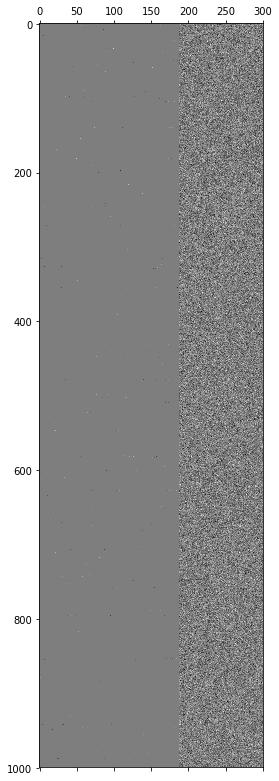

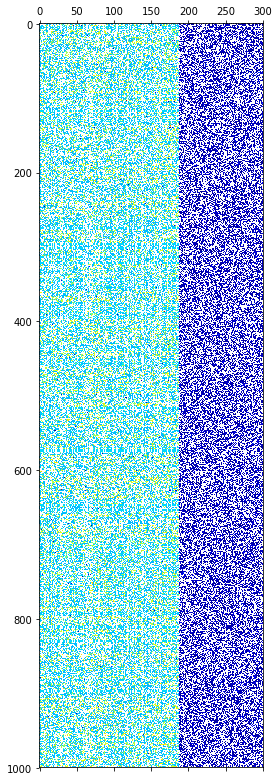

In [108]:
#show the weights
x=model.get_weights()
w1=x[0]
#w1=reg_path
print("w1", w1.shape)
plt.matshow(w1[0:1000,0:1000], fignum=1, cmap='gray')
plt.matshow(-np.log(w1[0:1000,0:1000]), fignum=2, cmap='jet')


Z= (299, 4) [[259.          44.           1.57768206   2.        ]
 [192.         247.           1.58647154   2.        ]
 [277.          87.           1.70105889   2.        ]
 ...
 [588.         592.          15.27616735 116.        ]
 [596.         595.          17.10340079 221.        ]
 [594.         597.          18.88040204 300.        ]]


/home/brad/anaconda3/envs/xenas/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


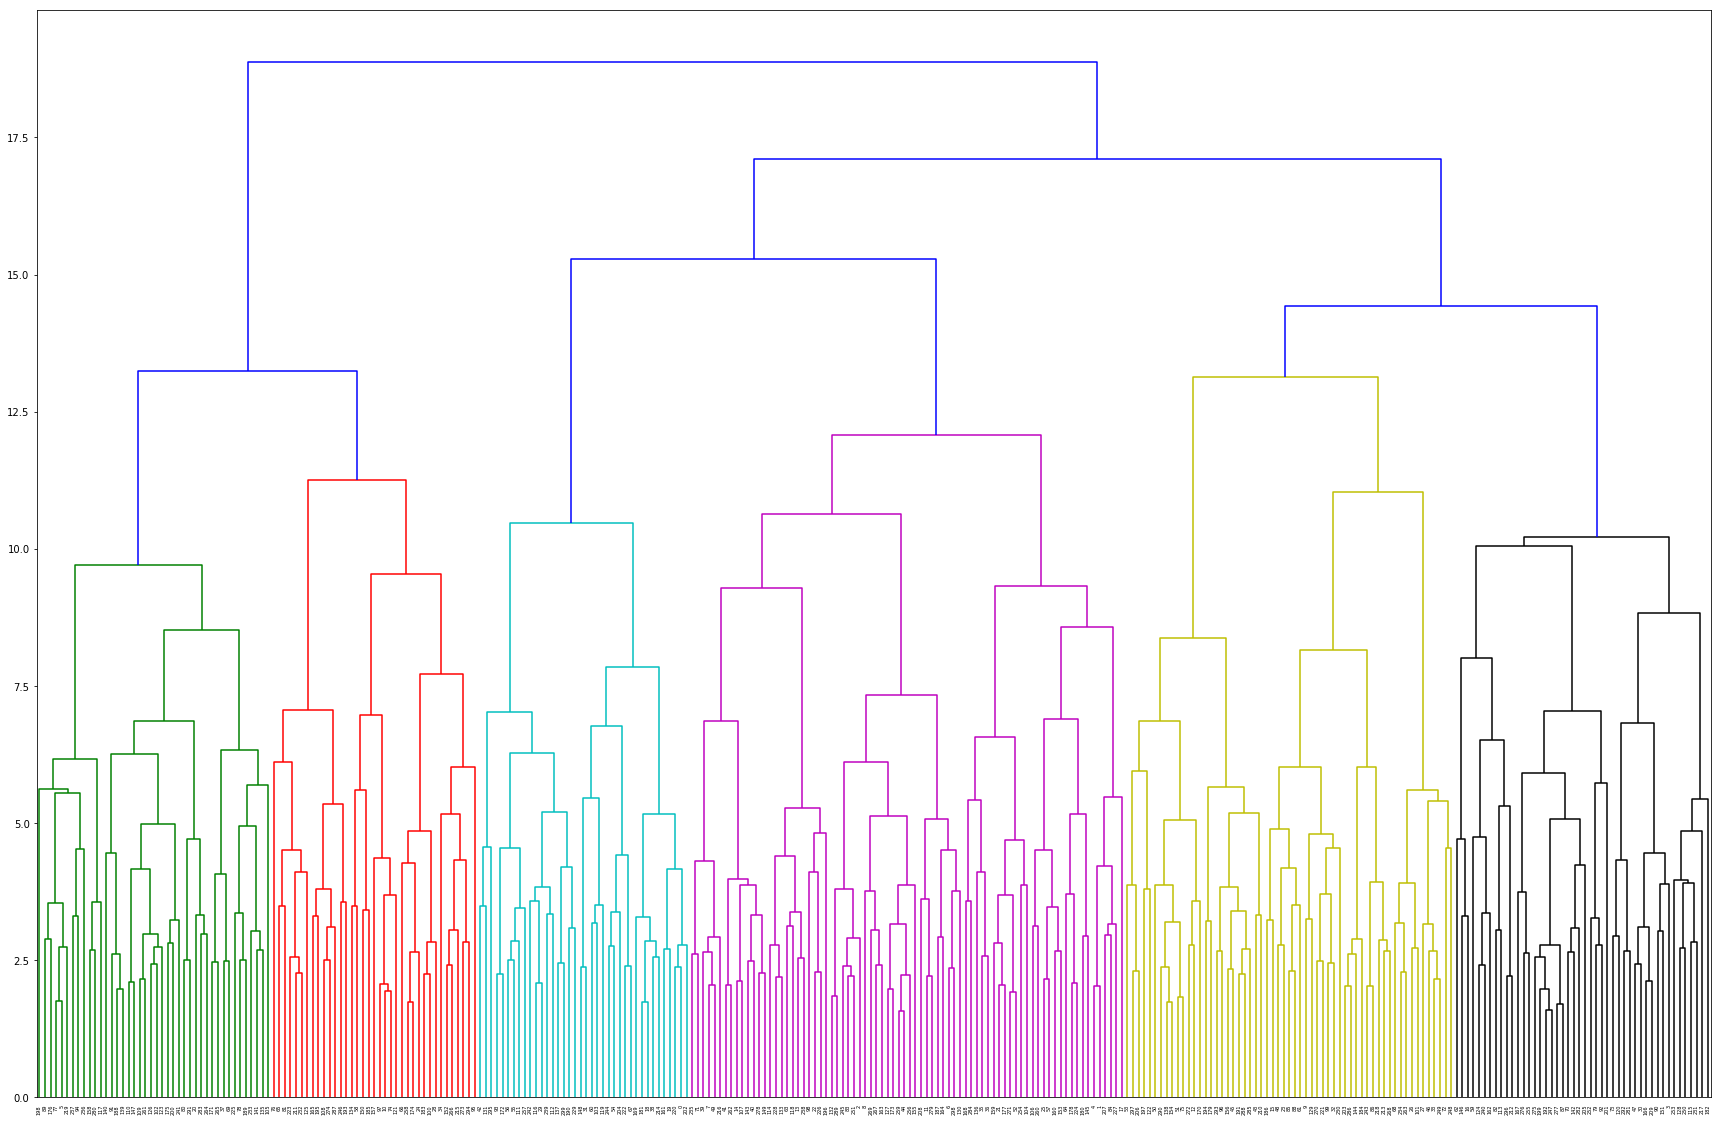

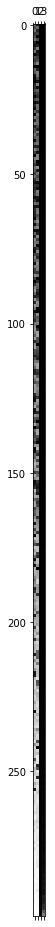

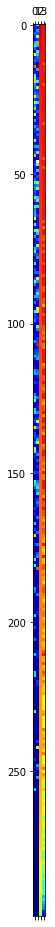

In [107]:
#seriation
from scipy.cluster.hierarchy import dendrogram, linkage



#X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
#Z = linkage(X, 'ward')
#fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(Z)
#
#Z = linkage(X, 'single')
#fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(Z)
#plt.show()


w2=w1[0:300,0:200]
Z = linkage(w2, method='ward', optimal_ordering=True)
fig = plt.figure(figsize=(30, 20))
dn = dendrogram(Z)
print('Z=', Z.shape, Z)

plt.matshow(Z, fignum=2, cmap='gray')
plt.matshow(-np.log(Z), fignum=3, cmap='jet')


In [106]:
from scipy.cluster import hierarchy
np.random.seed(21)
X = np.random.randn(10,10)
Z = hierarchy.ward(X)
print(hierarchy.leaves_list(Z))
print(hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, X)))


[9 7 8 3 6 2 5 4 0 1]
[9 8 7 3 6 5 2 1 0 4]


In [85]:
#normal training
sample_weights = class_weight.compute_sample_weight('balanced', classes_train[:]+46*y_train[:])

model.fit(X_train, Tclasses_train, epochs=20, batch_size=32, shuffle="true",sample_weight = sample_weights,validation_data=(X_test, Tclasses_test))
#print(model.metrics_names, model.evaluate(X_test, y_test))


Train on 15300 samples, validate on 3826 samples
Epoch 1/20
15300/15300 [==============================] - 8s 542us/step - loss: 5659.6961 - acc: 0.1721 - val_loss: 8435.8857 - val_acc: 0.3257
Epoch 2/20
15300/15300 [==============================] - 8s 535us/step - loss: 5658.5947 - acc: 0.1887 - val_loss: 2923.5282 - val_acc: 0.3544
Epoch 3/20
15300/15300 [==============================] - 8s 535us/step - loss: 5654.2159 - acc: 0.2077 - val_loss: 8347.7097 - val_acc: 0.3795
Epoch 4/20
15300/15300 [==============================] - 8s 543us/step - loss: 5652.9578 - acc: 0.2197 - val_loss: 2992.9278 - val_acc: 0.4020
Epoch 5/20
15300/15300 [==============================] - 8s 539us/step - loss: 5648.7038 - acc: 0.2339 - val_loss: 8260.9520 - val_acc: 0.4164
Epoch 6/20
15300/15300 [==============================] - 8s 537us/step - loss: 5647.4173 - acc: 0.2414 - val_loss: 3047.5384 - val_acc: 0.4334
Epoch 7/20
15300/15300 [==============================] - 8s 551us/step - loss: 5643.28

In [89]:
#Mixup like training
def RNA_mix(mix, naug):
    
    print( X_train.shape[0] )
    samples=X_train.shape[0]
    rmix=np.random.rand()*(1-mix)
    print(mix, 1-rmix)
    for i in range(naug) :
        i0 = np.random.randint(samples)
        i1 = np.random.randint(samples)
        Xmix0 = X_train[i0,:] *(1-rmix) 
        Xmix1 = X_train[i1,:] *(rmix)
        #print(1-rmix,rmix )
        #print(i0,i1 )
        #print(X_train[i0, 0:5] )
        #print(X_train[i1, 0:5] )
        #print(Xmix0[0:5] )
        #print(Xmix1[0:5] )
        X_aug[i,:]=Xmix0+Xmix1
        Y_aug[i,:]=Tclasses_train[i0,:]
        Y_augc[i] = classes_train[i0]+46*y_train[i0]
        
naug=5000
X_aug=np.zeros((naug,X_train.shape[1]))
Y_aug=np.zeros((naug,Tclasses_train.shape[1]))
Y_augc=np.zeros((naug))
X_aug_test=X_test

#RNA_mix(.4, naug)  

#print(X_aug[0,1:5] )
#print(Y_aug[0,:] )


for k in range(20):
 sample_weights = class_weight.compute_sample_weight('balanced', Y_augc)
 for i in range(20):
    RNA_mix(.5, naug)   
    model.fit(X_aug, Y_aug, epochs=1, batch_size=128, shuffle="true",sample_weight = sample_weights,validation_data=(X_aug_test, Tclasses_test))

 sample_weights = class_weight.compute_sample_weight('balanced', classes_train[:]+46*y_train[:])
 model.fit(X_train, Tclasses_train, epochs=3, batch_size=256, shuffle="true",sample_weight = sample_weights,validation_data=(X_test, Tclasses_test))



15300
0.5 0.6698582590726428
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 17s 3ms/step - loss: 5491.9376 - acc: 0.4142 - val_loss: 4031.7796 - val_acc: 0.6696
15300
0.5 0.8243527427223354
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 9s 2ms/step - loss: 5491.2919 - acc: 0.4482 - val_loss: 4031.6586 - val_acc: 0.6688
15300
0.5 0.9772987464631546
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 5s 1ms/step - loss: 5491.0681 - acc: 0.4542 - val_loss: 4035.5238 - val_acc: 0.6696
15300
0.5 0.550773139590512
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 389us/step - loss: 5491.6730 - acc: 0.3328 - val_loss: 4037.7827 - val_acc: 0.6709
15300
0.5 0.5841368164465466
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s

5000/5000 [==============================] - 2s 343us/step - loss: 5485.6430 - acc: 0.4420 - val_loss: 4096.1392 - val_acc: 0.6720
15300
0.5 0.7734952341336863
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 343us/step - loss: 5486.1748 - acc: 0.4422 - val_loss: 4104.6828 - val_acc: 0.6730
15300
0.5 0.7733603162966486
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 339us/step - loss: 5485.9668 - acc: 0.4490 - val_loss: 4108.8962 - val_acc: 0.6735
15300
0.5 0.6444985669394431
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 352us/step - loss: 5486.2912 - acc: 0.4076 - val_loss: 4115.7446 - val_acc: 0.6720
15300
0.5 0.8614692811327693
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 359us/step - loss: 5485.4906 - acc: 0.4404 - val_loss: 4116.2229 - val_acc: 0.67

5000/5000 [==============================] - 2s 343us/step - loss: 5478.7276 - acc: 0.4000 - val_loss: 4164.1807 - val_acc: 0.6738
15300
0.5 0.6915675057722289
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 345us/step - loss: 5478.8234 - acc: 0.4216 - val_loss: 4167.5956 - val_acc: 0.6733
15300
0.5 0.8591921014738695
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 365us/step - loss: 5478.3040 - acc: 0.4470 - val_loss: 4174.3247 - val_acc: 0.6728
15300
0.5 0.9234090483450295
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 359us/step - loss: 5477.7772 - acc: 0.4640 - val_loss: 4172.1497 - val_acc: 0.6735
15300
0.5 0.6528249803854003
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 352us/step - loss: 5478.0734 - acc: 0.4048 - val_loss: 4167.6385 - val_acc: 0.67

5000/5000 [==============================] - 2s 411us/step - loss: 5469.6112 - acc: 0.4634 - val_loss: 4175.5910 - val_acc: 0.6730
15300
0.5 0.6433929871148175
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 426us/step - loss: 5470.3662 - acc: 0.4138 - val_loss: 4174.8352 - val_acc: 0.6743
15300
0.5 0.7752300475152554
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 396us/step - loss: 5469.7342 - acc: 0.4498 - val_loss: 4171.1246 - val_acc: 0.6746
15300
0.5 0.7460753964835307
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 399us/step - loss: 5469.1524 - acc: 0.4490 - val_loss: 4181.7528 - val_acc: 0.6743
15300
0.5 0.5825672253277028
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 390us/step - loss: 5469.9417 - acc: 0.3868 - val_loss: 4182.7609 - val_acc: 0.67

15300
0.5 0.5022686199666984
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 346us/step - loss: 5463.8665 - acc: 0.2912 - val_loss: 4220.6718 - val_acc: 0.6793
15300
0.5 0.581411030385951
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 370us/step - loss: 5463.2651 - acc: 0.3672 - val_loss: 4224.3789 - val_acc: 0.6783
15300
0.5 0.9912539625217482
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 2s 373us/step - loss: 5462.3846 - acc: 0.4644 - val_loss: 4226.8668 - val_acc: 0.6769
Train on 15300 samples, validate on 3826 samples
Epoch 1/3
15300/15300 [==============================] - 3s 205us/step - loss: 5487.5693 - acc: 0.4621 - val_loss: 4233.0409 - val_acc: 0.6754
Epoch 2/3
15300/15300 [==============================] - 3s 222us/step - loss: 5486.8680 - acc: 0.4649 - val_loss: 4238.6316 - val_acc: 0.6743
Epoch 3/3
15

5000/5000 [==============================] - 3s 523us/step - loss: 5455.4386 - acc: 0.4626 - val_loss: 4284.6273 - val_acc: 0.6775
15300
0.5 0.502626055039996
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 529us/step - loss: 5456.0843 - acc: 0.3036 - val_loss: 4283.9485 - val_acc: 0.6777
15300
0.5 0.8853363140504079
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 532us/step - loss: 5454.8105 - acc: 0.4642 - val_loss: 4284.0420 - val_acc: 0.6772
15300
0.5 0.6249958431165643
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 564us/step - loss: 5455.1982 - acc: 0.4016 - val_loss: 4291.2445 - val_acc: 0.6777
15300
0.5 0.9172873851376109
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 552us/step - loss: 5454.6488 - acc: 0.4586 - val_loss: 4293.2562 - val_acc: 0.676

5000/5000 [==============================] - 3s 669us/step - loss: 5447.3308 - acc: 0.4368 - val_loss: 4320.2914 - val_acc: 0.6759
15300
0.5 0.6298838143789858
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 666us/step - loss: 5447.3082 - acc: 0.4020 - val_loss: 4324.7063 - val_acc: 0.6775
15300
0.5 0.7692033052749985
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 3s 673us/step - loss: 5446.7663 - acc: 0.4654 - val_loss: 4325.1742 - val_acc: 0.6785
15300
0.5 0.6349676890323428
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 4s 775us/step - loss: 5447.1638 - acc: 0.4230 - val_loss: 4332.2524 - val_acc: 0.6790
15300
0.5 0.9749431981663832
Train on 5000 samples, validate on 3826 samples
Epoch 1/1
5000/5000 [==============================] - 4s 760us/step - loss: 5446.2636 - acc: 0.4738 - val_loss: 4332.6238 - val_acc: 0.67

KeyboardInterrupt: 

classes_pred.shape: (3826,) (3826,) 91
pred [41 24 83 22 79 14 88 63 12  1 55 65  8 79 41 68 55 74 63]
test [41 24 33 22 19 14 30  4 31  1 23 35  8 42 41 22  9 28 17]


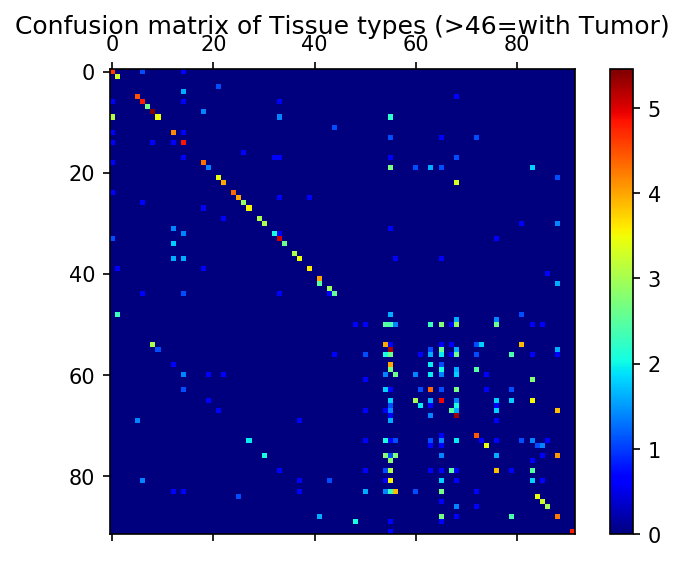

test classes in


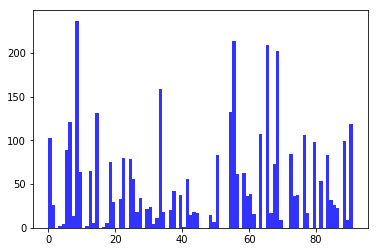

test classes out
test classes ratio
tot=3826 nn=0.427, nt=0.020, tn=0.022 tt=0.531 Tcorrect=0.958


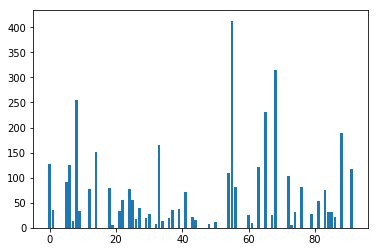

In [90]:
#plot results
from sklearn.metrics import confusion_matrix
#y_true = [2, 0, 2, 2, 0, 1]
#y_pred = [0, 0, 2, 2, 0, 2]
classes_pred=model.predict_classes( X_test)

print("classes_pred.shape:", classes_pred.shape,  classes_test.shape, classes_pred.max())
#confusion_matrix(y_true, y_pred)
print("pred", classes_pred[1:20])
print("test", classes_test[1:20])

cm = confusion_matrix(classes_test[:]+46*y_test[:], classes_pred[:], labels=np.arange(92))

plt.figure(num=1, dpi=150, frameon=1)

plt.matshow(np.log(cm+1), fignum=1, cmap='jet')
#plt.matshow(np.eye(96), fignum=1, cmap='jet')
plt.title('Confusion matrix of Tissue types (>46=with Tumor)')
plt.colorbar()
plt.show()

cm.shape

print('test classes in')

n, bins, patches = plt.hist(classes_test[:]+46*y_test[:], 91, facecolor='blue', alpha=0.8)
plt.show()
cm[0:10,0:10]

print('test classes out')

histc_out=np.zeros(92)
histr_out=np.zeros(92)

for col in range(92) :
    histc_out[col]    = np.sum(cm[ 0:92,col] )  
plt.bar( range(92), histc_out)


#for row in range(92) :
#    histr_out[row]    = np.sum(cm[row, 0:92] )  
#plt.bar( range(92, 184), histr_out)

print('test classes ratio')
for row in range(92) :
    histr_out[row]    = np.sum(cm[row, 0:92] )  

#    plt.bar( range(92), histr_out/histc_out)

histc_out[:]

tot=np.sum(cm[0:92,0:92])
sum_nn=np.sum(cm[0:46,0:45])/tot
sum_tn=np.sum(cm[0:46,46:92])/tot
sum_nt=np.sum(cm[46:92,0:46])/tot
sum_tt=np.sum(cm[46:92,46:92])/tot
printf("tot=%d nn=%0.3f, nt=%0.3f, tn=%0.3f tt=%0.3f Tcorrect=%0.3f" , tot, sum_nn,sum_nt,sum_tn,sum_tt,sum_nn+sum_tt )

In [ ]:
#more results
pred_col=np.zeros(92)
for col in range(92) :
    pred_col[col]    = np.sum(cm[ 0:92,col] )  

for row in range(92) :
    T= 'Normal'
    if row > 45: T='Tumor '
    pred_tot    = np.sum(cm[row,  0:92] )  
    pred_n      = np.sum(cm[row,  0:46] )/ pred_tot
    pred_t      = np.sum(cm[row,  46:92])/ pred_tot
    pred_corr   = cm[row,row]/ pred_tot 
        
    printf("classes_label : %2.2d %s %15s  tin= %3d  tout=%3d pn= %.2f  pt= %.2f  correct= %.2f   ", row, T,  Tclass_labels[row], pred_tot
           , pred_col[row]
           , pred_n, pred_t, pred_corr )



In [65]:
#results per class
tot=np.sum(Tclasses_test [:,:] )
printf("tot=%d", tot)

for k in range(92) :
    T= 'Normal'
    if k > 45: T='Tumor '
    class_tot_test   = np.sum(Tclasses_test [:,k] )
    class_tot_train  = np.sum(Tclasses_train[:,k] )
        
    printf("classes_label : %2.2d %s %15s  test= %3d train= %3d    ", k, T, Tclass_labels[k], class_tot_test, class_tot_train  )



tot=3826
classes_label : 00 Normal [b'Adipose Ti']  test= 103 train= 412    
classes_label : 01 Normal [b'Adrenal Gl']  test=  26 train= 102    
classes_label : 02 Normal [b'Adrenal gl']  test=   0 train=   0    
classes_label : 03 Normal  [b'Bile duct']  test=   2 train=   7    
classes_label : 04 Normal    [b'Bladder']  test=   4 train=  24    
classes_label : 05 Normal      [b'Blood']  test=  89 train= 355    
classes_label : 06 Normal [b'Blood Vess']  test= 121 train= 485    
classes_label : 07 Normal [b'Bone Marro']  test=  14 train=  56    
classes_label : 08 Normal      [b'Brain']  test= 237 train= 920    
classes_label : 09 Normal     [b'Breast']  test=  64 train= 228    
classes_label : 10 Normal     [b'Cervix']  test=   0 train=   3    
classes_label : 11 Normal [b'Cervix Ute']  test=   2 train=   8    
classes_label : 12 Normal      [b'Colon']  test=  65 train= 284    
classes_label : 13 Normal [b'Endometriu']  test=   5 train=  18    
classes_label : 14 Normal  [b'Esophagus

In [64]:
#results
col=68
printf("col=%3d %15s tot=%d\n", col, Tclass_labels[col], np.sum(cm[:,col]))    
for row in range(92) :
    printf("classes_label : %2.2d %2.2d %15s  tot= %3d    ", row, col,  Tclass_labels[row], cm[row,col] )
 


col= 68       [b'Lung'] tot=380

classes_label : 00 68 [b'Adipose Ti']  tot=   0    
classes_label : 01 68 [b'Adrenal Gl']  tot=   0    
classes_label : 02 68 [b'Adrenal gl']  tot=   0    
classes_label : 03 68  [b'Bile duct']  tot=   0    
classes_label : 04 68    [b'Bladder']  tot=   0    
classes_label : 05 68      [b'Blood']  tot=   1    
classes_label : 06 68 [b'Blood Vess']  tot=   0    
classes_label : 07 68 [b'Bone Marro']  tot=   0    
classes_label : 08 68      [b'Brain']  tot=   0    
classes_label : 09 68     [b'Breast']  tot=   0    
classes_label : 10 68     [b'Cervix']  tot=   0    
classes_label : 11 68 [b'Cervix Ute']  tot=   0    
classes_label : 12 68      [b'Colon']  tot=   0    
classes_label : 13 68 [b'Endometriu']  tot=   2    
classes_label : 14 68  [b'Esophagus']  tot=   0    
classes_label : 15 68        [b'Eye']  tot=   0    
classes_label : 16 68 [b'Fallopian ']  tot=   0    
classes_label : 17 68 [b'Head and N']  tot=   0    
classes_label : 18 68      [b'H

In [ ]:
#fit for exponential data
model.fit(eX_train, Tclasses_train, epochs=20, batch_size=256, shuffle="true",validation_data=(eX_test, Tclasses_test))


In [ ]:
"""
Save model and weights so we can copy them back from the GPU machine
to visualize and evaluate locally.
"""
model_json = model.to_json()
if not os.path.exists("models"):
    os.makedirs("models")
with open("models/model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/weights.h5")
print("Saved to model.json and weights.json")